<a href="https://colab.research.google.com/github/kvame96/NOVIA/blob/main/%22Industrial_AI%22_Assignment1_Optimization_LpProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%reset -f
!pip install --upgrade pandas
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
from google.colab import drive
drive.mount('/content/drive')
import os
google_drive_root = '/content/drive/MyDrive'
assignment_loc = '/Novia/Industrial_AI/Assignment1'
os.chdir(google_drive_root + assignment_loc)
xlsx_file_name = 'PowerDemand_SpotPrices_Corrected.xlsx'
data = pd.read_excel(xlsx_file_name, engine='openpyxl')

In [2]:
data.head()

,Timestamp,Power demand (MW),Spot price (€/MWh),CORRECT Spot price (€/MWh),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2021-01-01 00:00:00.015,69.92,24.07,24.07,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00.010,68.92,24.95,24.95,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00.005,74.27,24.35,24.35,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00.000,80.68,23.98,23.98,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00.000,82.06,23.72,23.72,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Information on existing boilers
boiler_data = {
    'Boiler Power max (MW)': [60, 45, 30, 25, 20, 15],
    'Power min (MW)': [12, 8, 5, 5, 0, 0],
    'Cost (€/MWh)': [50, 60, 100, 120, 160, 200]
}

boiler_df = pd.DataFrame(boiler_data)
boiler_df

,Boiler Power max (MW),Power min (MW),Cost (€/MWh)
0,60,12,50
1,45,8,60
2,30,5,100
3,25,5,120
4,20,0,160
5,15,0,200


In [4]:
# Compute the power demand and hours for each week
weekly_demand = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Power demand (MW)'].sum()
weekly_hours = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Timestamp'].count()

# Create a DataFrame with three columns
weekly_data = pd.DataFrame({'Week': weekly_demand.index.strftime('%Y-%m-%d'),
                            'Power Demand (MW)': weekly_demand.values,
                            'Hours': weekly_hours.values})


# Display the results
print(weekly_data)

# Display the number of weeks
print('\n')
print(f"Number of weeks:\n{len(weekly_demand)}")


          Week  Power Demand (MW)  Hours
0   2021-01-03            6215.93     72
1   2021-01-10           19463.08    168
2   2021-01-17           19666.59    168
3   2021-01-24           15377.93    168
4   2021-01-31           16720.59    168
5   2021-02-07           21266.55    168
6   2021-02-14           19826.70    168
7   2021-02-21           19553.90    168
8   2021-02-28           14873.44    168
9   2021-03-07           14677.00    168
10  2021-03-14           17132.02    168
11  2021-03-21           14305.70    168
12  2021-03-28           10970.72    167
13  2021-04-04           10357.67    168
14  2021-04-11           11534.90    168
15  2021-04-18            9091.82    168
16  2021-04-25            8970.06    168
17  2021-05-02           11147.37    168
18  2021-05-09            9432.78    168
19  2021-05-16            4761.67    168
20  2021-05-23            6699.08    168
21  2021-05-30            6630.92    168
22  2021-06-06            3639.51    168
23  2021-06-13  

# Point 1

Find the minimal cost over year 2021 for the boiler configuration in table 1. Visualize the
result as a proper chart (zoom in on and highlight interesting parts). Present cost and
operating time distributions over the year for the boilers. Discuss the result.


In [5]:
%%capture

!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# initialize the output
results = []

for i in range(len(weekly_demand)):

  # Define the model
  model = LpProblem("Power_Optimization", sense = LpMinimize)

  # Define the decision variables

  # Power of each boiler for which the cost is minimized
  P_B1 = LpVariable("P_B1", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][0], cat="Continuous")
  P_B2 = LpVariable("P_B2", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][1], cat="Continuous")
  P_B3 = LpVariable("P_B3", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][2], cat="Continuous")
  P_B4 = LpVariable("P_B4", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][3], cat="Continuous")
  P_B5 = LpVariable("P_B5", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][4], cat="Continuous")
  P_B6 = LpVariable("P_B6", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][5], cat="Continuous")


  # Binary variables to control on/off status of boilers
  B_B1 = LpVariable("B_B1", cat="Binary")
  B_B2 = LpVariable("B_B2", cat="Binary")
  B_B3 = LpVariable("B_B3", cat="Binary")
  B_B4 = LpVariable("B_B4", cat="Binary")
  B_B5 = LpVariable("B_B5", cat="Binary")
  B_B6 = LpVariable("B_B6", cat="Binary")

  # Objective function: Minimize total production cost (€/h)
  model += (P_B1 * boiler_df['Cost (€/MWh)'][0] +
           P_B2 * boiler_df['Cost (€/MWh)'][1] +
           P_B3 * boiler_df['Cost (€/MWh)'][2] +
           P_B4 * boiler_df['Cost (€/MWh)'][3] +
           P_B5 * boiler_df['Cost (€/MWh)'][4] +
           P_B6 * boiler_df['Cost (€/MWh)'][5])

  # Constraints: Meet weekly demand
  model += (P_B1 + P_B2 + P_B3 + P_B4 + P_B5 + P_B6) * weekly_hours[i] >= weekly_demand[i], f"Demand_Constraint_Week_{i}"

  # Constraints to link binary variables with power output
  model += P_B1 <= boiler_df['Boiler Power max (MW)'][0] * B_B1
  model += P_B1 >= boiler_df['Power min (MW)'][0] * B_B1
  model += P_B2 <= boiler_df['Boiler Power max (MW)'][1] * B_B2
  model += P_B2 >= boiler_df['Power min (MW)'][1] * B_B2
  model += P_B3 <= boiler_df['Boiler Power max (MW)'][2] * B_B3
  model += P_B3 >= boiler_df['Power min (MW)'][2] * B_B3
  model += P_B4 <= boiler_df['Boiler Power max (MW)'][3] * B_B4
  model += P_B4 >= boiler_df['Power min (MW)'][3] * B_B4
  model += P_B5 <= boiler_df['Boiler Power max (MW)'][4] * B_B5
  model += P_B5 >= boiler_df['Power min (MW)'][4] * B_B5
  model += P_B6 <= boiler_df['Boiler Power max (MW)'][5] * B_B6
  model += P_B6 >= boiler_df['Power min (MW)'][5] * B_B6

  # Solve the problem
  model.solve()

  # Append the results to the list
  results.append([P_B1.varValue])
  results.append([P_B2.varValue])
  results.append([P_B3.varValue])
  results.append([P_B4.varValue])
  results.append([P_B5.varValue])
  results.append([P_B6.varValue])

# Convert the list to a NumPy array for easier manipulation
results_array = np.array(results)

Down Time (Not Required)

- Definition: Down time refers to periods when a power plant or industrial process is not operational. This could be due to planned maintenance, unexpected failures, or other reasons.

- Importance: Down times can significantly impact production and costs. In the context of power generation, down times can lead to supply shortages and potential blackouts if not properly managed. For industrial processes, down times can result in lost production and revenue.

In practice many larger boilers can/should not be operated at low power
levels due to inefficiency or even impossibility.
this condition was taken into account selecting 'Power min (MW)' and 'Power max (MW)'.
Nevertheless sometimes it is better to shut down completely a boiler when another larger and cheaper can be still used within its operative margin.
Because of that a binary condition can be introduced to set the on-off switching.

\

Model Hypothesis:
The model solves the probelm for a week of timespan. It finds the optimal power at which the boilers must work for a certain week.
The powert that the model returns assumes that the boiler willl work for that certain week with that designed level of power.
This is a reasonable assumption. If the boiler, instead of deploying the power constantly over the time of a week, deployed all the power during few hours (operating at its maximum instead of at the designed level, and then shutting down) other problems could arise, as energy storage and wear out of the boiler due to functioning at its maximum power (usually if a boiler works at its maximum power for a short period of time it is more likely to wear out compared to one that works constantly over time at a low power)


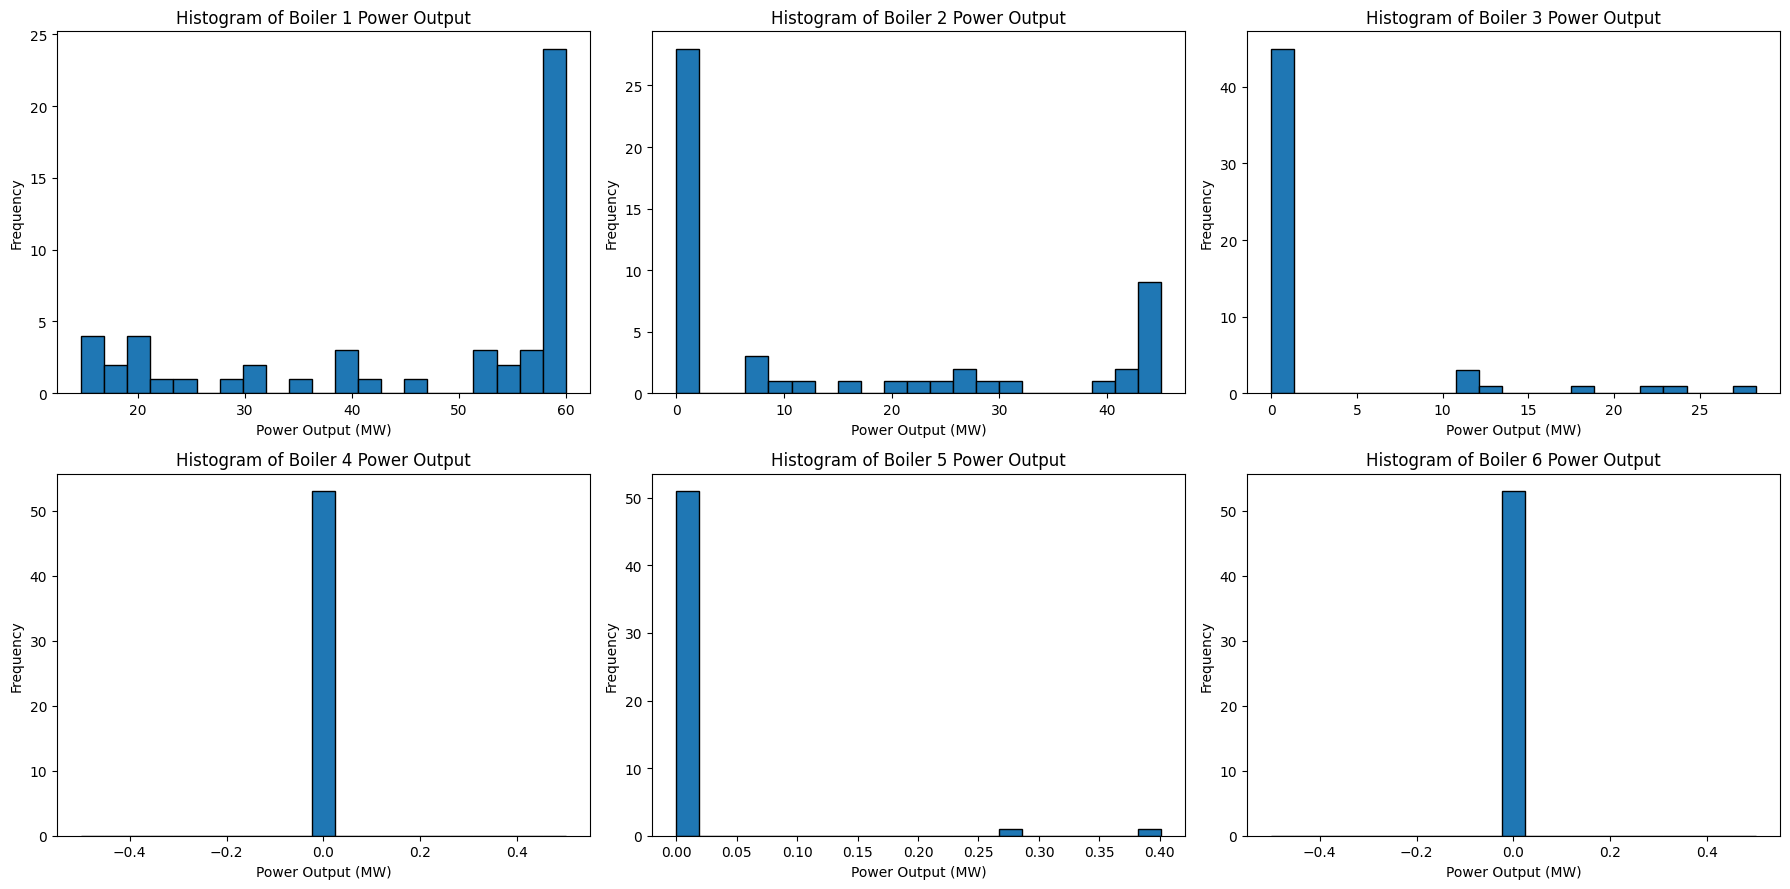

In [6]:
# Operational power of each boiler per week

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a histogram for each boiler in a separate subplot
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[i]  # Get the current subplot axis
    ax.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=21, edgecolor='black')
    ax.set_title(f'Histogram of Boiler {i+1} Power Output')
    ax.set_xlabel('Power Output (MW)')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

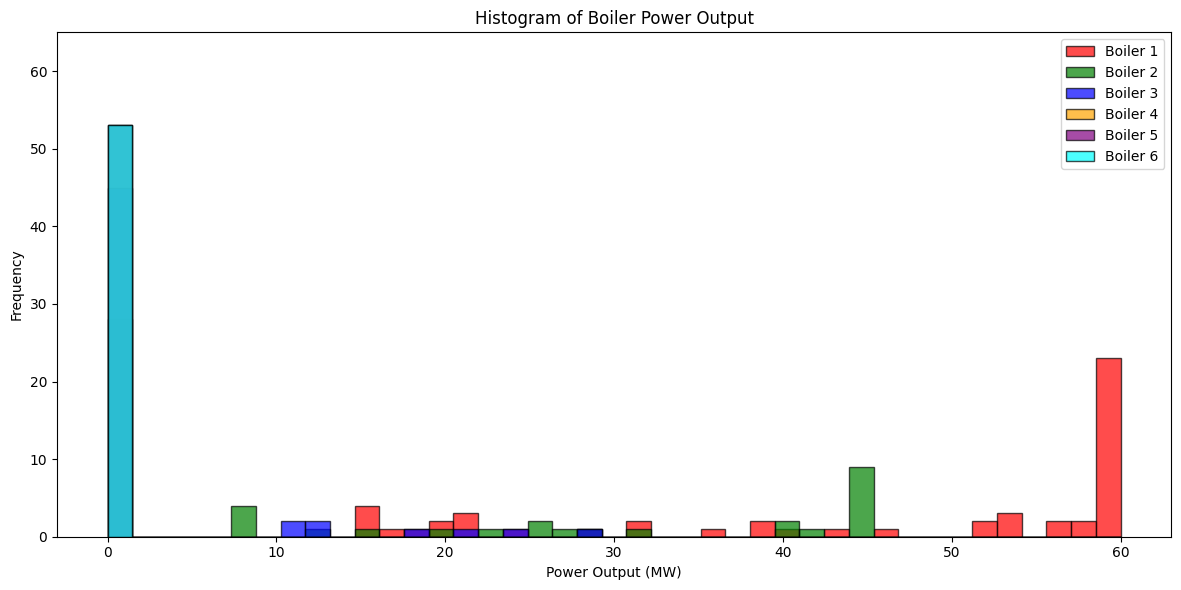

In [7]:
# Colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Create a single plot
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Define a common bins for all histograms
all_boiler_data = results_array[:, 0]  # Combine all boiler data for determining the bins
num_bins = 41
_, bins, _ = plt.hist(all_boiler_data, bins=num_bins, edgecolor='black', alpha=0) # Get common bins for all boilers

# Plot the data for each boiler on the same plot using shared bins
for i in range(boiler_df['Boiler Power max (MW)'].size):
    plt.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=bins, edgecolor='black', alpha=0.7, label=f'Boiler {i+1}', color=colors[i])

plt.title('Histogram of Boiler Power Output')
plt.xlabel('Power Output (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(0, 65)
plt.show()

Here's a breakdown:

- X-axis (Power Output (MW)): This axis represents the different levels of power output (in megawatts) that Boiler 1 operated at during the simulation period (likely the year 2021, as per the provided context).
- Y-axis (Frequency): This axis shows how often the boiler operated at each power output level. The height of each bar indicates the frequency or number of times that the boiler produced that specific power output.
- Bars: Each bar visually represents a range of power output values (determined by the bins parameter, which is set to 10 in your code). The height of each bar indicates how often the boiler's output fell within that range during the simulation.

In essence, the histogram shows the distribution of Boiler 1's operating points throughout the simulation period. It tells you:

- Most frequent power output levels: The tallest bars indicate the power output levels at which the boiler operated most frequently.
- Range of power output: The width of the histogram shows the overall range of power output levels used by the boiler.
- Distribution shape: The shape of the histogram (e.g., bell-shaped, skewed) can provide insights into the boiler's usage patterns and efficiency.

# Present Power and Time Distribution

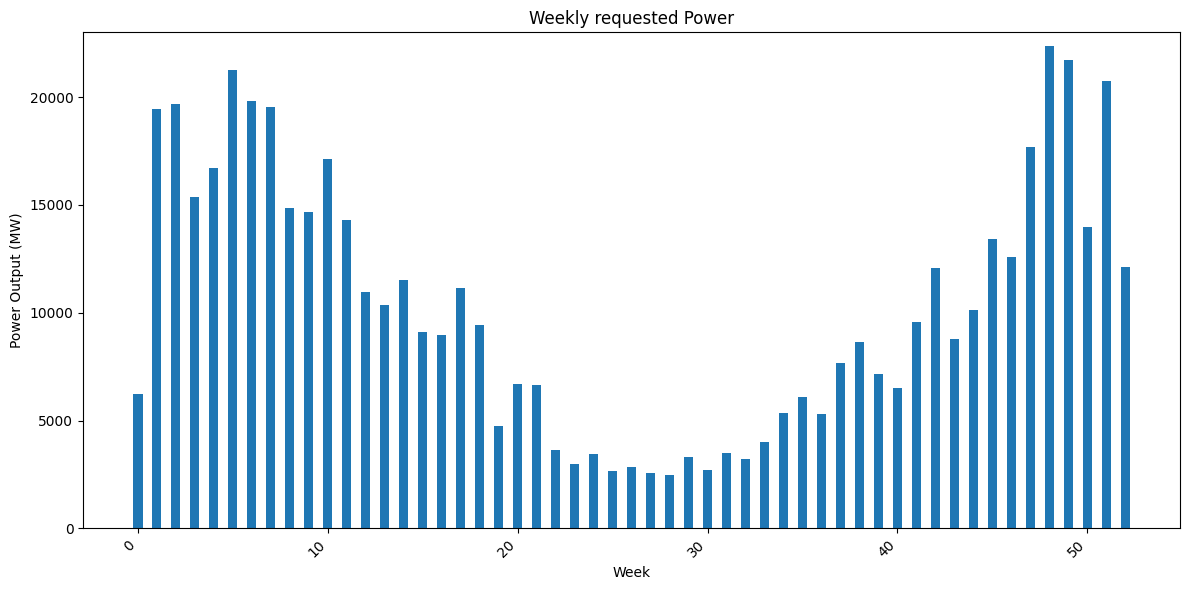

In [8]:
# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, weekly_data['Power Demand (MW)'], width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Weekly requested Power')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.ylim(0, 23000)
plt.show()


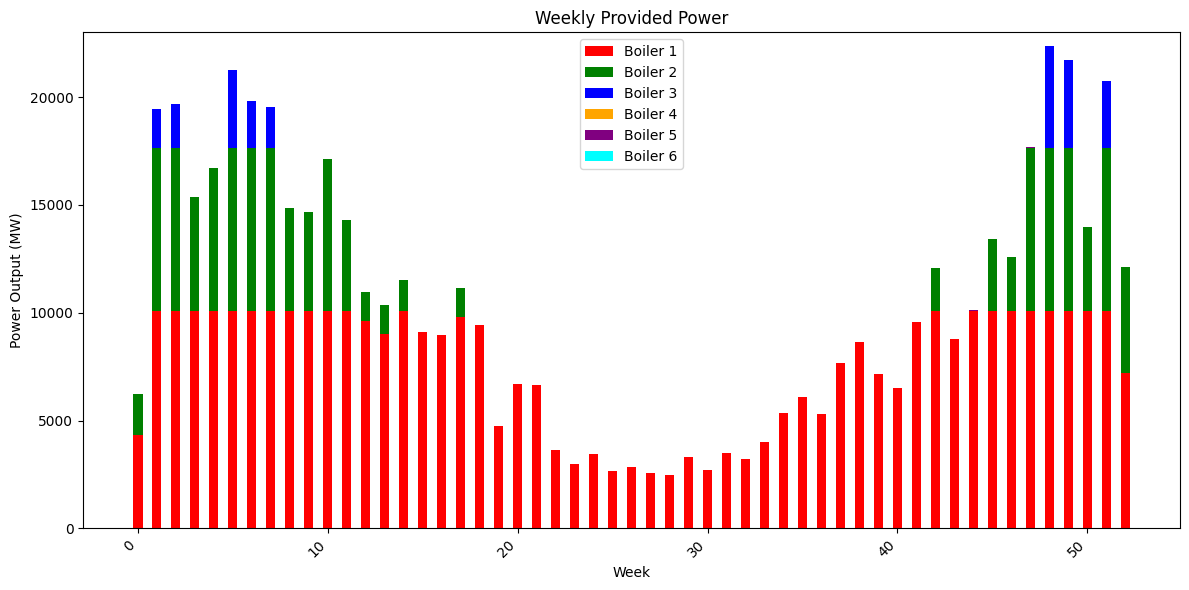

In [9]:
# Define colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Sum the elements of each row (week) to get a vector of 52 elements
reshaped_results_scaled = reshaped_results * weekly_hours.values[:, np.newaxis]
weekly_sums = np.sum(reshaped_results_scaled, axis=1)

# Plot each boiler's power output over time, stacking them
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_scaled[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i],
           bottom=np.sum(reshaped_results_scaled[:, :i], axis=1))  # Stack bars

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Power Output (MW)')
ax.set_title('Weekly Provided Power')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 23000)
plt.show()

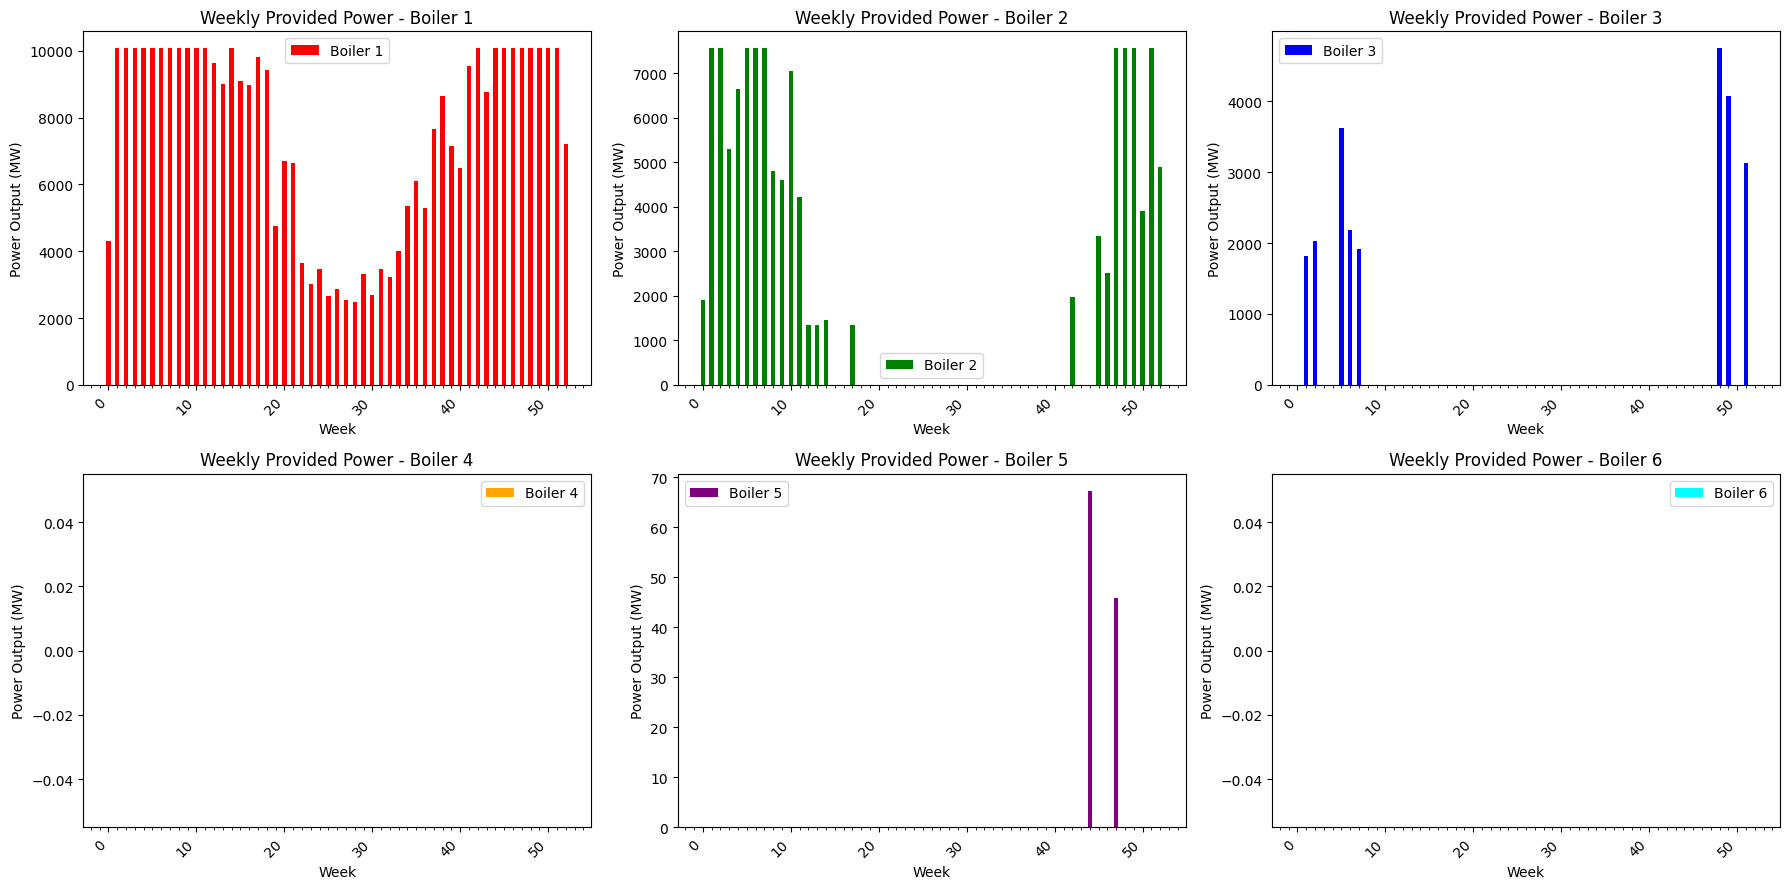

In [10]:
import matplotlib.ticker as ticker

# Create subplots (2 rows, 3 columns to accommodate 6 boilers)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each boiler and plot its data on a separate subplot
for ii in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[ii]  # Get the current subplot axis

    ax.bar(weeks, reshaped_results_scaled[:, ii], width=0.5,
           label=f'Boiler {ii+1}', color=colors[ii])

    # Customize the subplot
    ax.set_xlabel('Week')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(f'Weekly Provided Power - Boiler {ii+1}')
    ax.legend()

    # Set x-axis ticks (same as before)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}' if x % 10 == 0 else ''))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlapping and display the subplots
plt.tight_layout()
plt.show()

In [11]:
boiler_power_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_power_over_year[i] = (reshaped_results_scaled[:, i]).sum()

df_boiler_power = pd.DataFrame(boiler_power_over_year, columns=['Annual Power Output (MW)'])
df_boiler_power.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_provided_power to the DataFrame
annual_provided_power = reshaped_results_scaled.sum()
df_boiler_power.loc['Annual provided power'] = annual_provided_power  # Adding a new row with the name 'Total Provided'

# Calculate and add annual_requested_power to the DataFrame
annual_requested_power = weekly_data['Power Demand (MW)'].sum()
df_boiler_power.loc['Annual requested power'] = annual_requested_power  # Adding a new row with the name 'Total Requested'

# Calculate and add surplus/deficit to the DataFrame
surplus_deficit = annual_provided_power - annual_requested_power
df_boiler_power.loc['Surplus/Deficit'] = surplus_deficit  # Adding a new row for surplus/deficit

# Calculate the percentage for each boiler
df_boiler_power['Power output as percentage of Annual provided power'] = (df_boiler_power['Annual Power Output (MW)'] / annual_provided_power) * 100

# Filter out rows that are not boilers
boiler_rows = df_boiler_power.index.isin(['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6'])
df_boiler_power_filtered = df_boiler_power[boiler_rows]

# Format the percentage column
df_boiler_power['Power output as percentage of Annual provided power'] = df_boiler_power['Power output as percentage of Annual provided power'].map('{:.2f}%'.format)

df_boiler_power  # Displaying the DataFrame


,Annual Power Output (MW),Power output as percentage of Annual provided power
Boiler 1,399625.960221,72.93%
Boiler 2,124661.090008,22.75%
Boiler 3,23522.390136,4.29%
Boiler 4,0.000000,0.00%
Boiler 5,113.100001,0.02%
Boiler 6,0.000000,0.00%
Annual provided power,547922.540366,100.00%
Annual requested power,547922.540000,100.00%
Surplus/Deficit,0.000366,0.00%


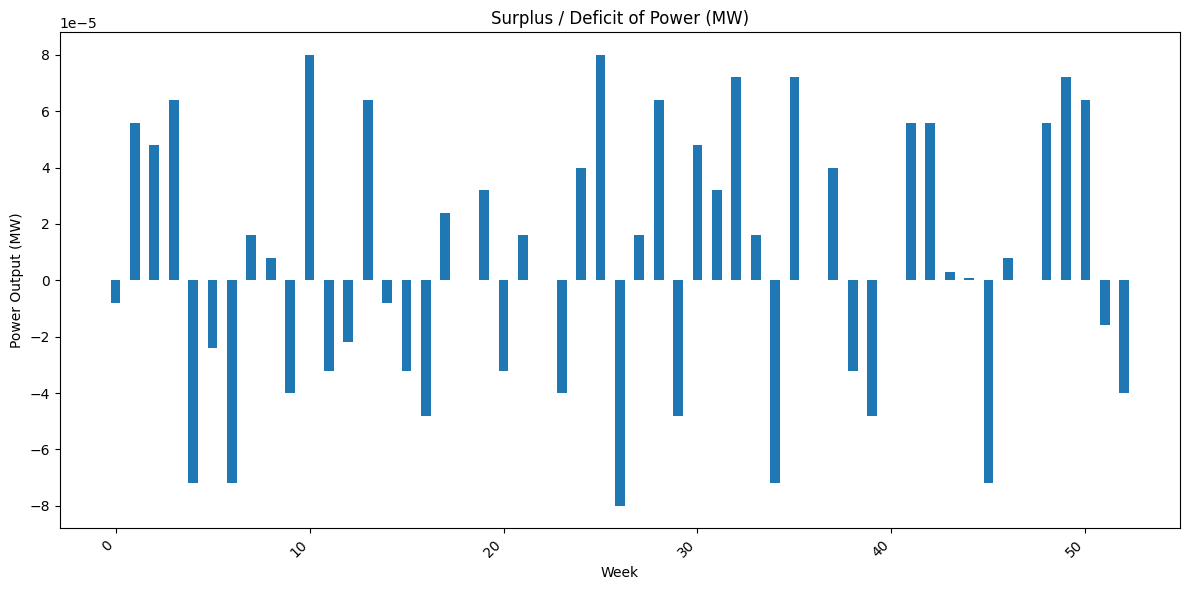

In [12]:
# Copmpute the error
error = weekly_sums - weekly_demand.values

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, error, width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Surplus / Deficit of Power (MW)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()



#Present Cost distribution

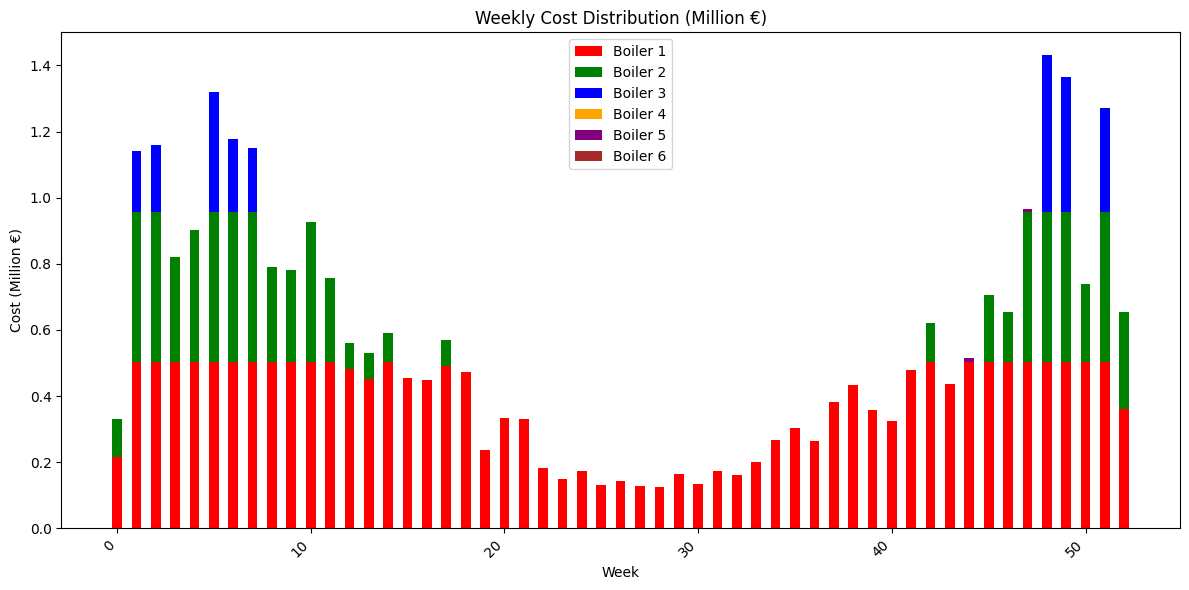

In [13]:
# Define colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Multiply power output by cost per MWh and hours to get cost for each boiler per week
reshaped_results_cost = reshaped_results * boiler_df['Cost (€/MWh)'].values * weekly_hours.values[:, np.newaxis]

# Scale the weekly cost data to millions of euros
reshaped_results_cost_millions = reshaped_results_cost / 1000000

# Calculate weekly cost sums
weekly_cost_sums = np.sum(reshaped_results_cost, axis=1)

# Plot each boiler's cost over time, stacking them
bottom = np.zeros(len(weekly_demand))  # Initialize bottom for stacking
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_cost_millions[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i], bottom=bottom)
    bottom += reshaped_results_cost_millions[:, i]  # Update bottom for next boiler's stack

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Cost (Million €)')  # Update y-axis label
ax.set_title('Weekly Cost Distribution (Million €)')  # Update title
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 1.5)  # Update ylim to reflect million € scale
plt.show()

In [14]:
boiler_cost_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_cost_over_year[i] = (reshaped_results_cost_millions[:, i]).sum() # Use reshaped_results_cost_millions here

df_boiler_cost = pd.DataFrame(boiler_cost_over_year, columns=['Annual Cost (Million €)']) # Changed column name
df_boiler_cost.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_total_cost to the DataFrame
saving_list=[]
annual_total_cost = reshaped_results_cost_millions.sum() # Use reshaped_results_cost_millions here
saving_list.append(annual_total_cost)
df_boiler_cost.loc['Annual total cost'] = annual_total_cost  # Adding a new row with the name 'Annual total cost'

# Calculate the percentage for each boiler (based on cost)
df_boiler_cost['Cost as percentage of Annual total cost'] = (df_boiler_cost['Annual Cost (Million €)'] / annual_total_cost) * 100 # Changed column name

# Format the percentage column
df_boiler_cost['Cost as percentage of Annual total cost'] = df_boiler_cost['Cost as percentage of Annual total cost'].map('{:.2f}%'.format)

df_boiler_cost  # Displaying the DataFrame

,Annual Cost (Million €),Cost as percentage of Annual total cost
Boiler 1,19.981298,66.98%
Boiler 2,7.479665,25.07%
Boiler 3,2.352239,7.89%
Boiler 4,0.000000,0.00%
Boiler 5,0.018096,0.06%
Boiler 6,0.000000,0.00%
Annual total cost,29.831298,100.00%


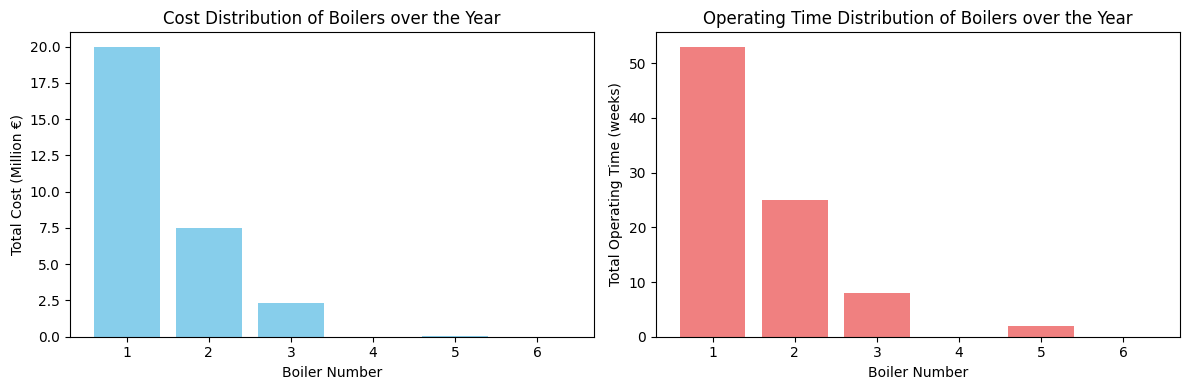

In [15]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot cost distribution on the first subplot
axes[0].bar(range(1, len(boiler_cost_over_year) + 1), boiler_cost_over_year, color='skyblue')
axes[0].set_xlabel("Boiler Number")
axes[0].set_ylabel("Total Cost (Million €)")
axes[0].set_title("Cost Distribution of Boilers over the Year")
axes[0].set_xticks(range(1, len(boiler_cost_over_year) + 1))

# Assuming reshaped_results_scaled contains weekly power output for each boiler
total_operating_time = (reshaped_results_scaled > 0).sum(axis=0)

# Plot operating time distribution on the second subplot
axes[1].bar(range(1, len(total_operating_time) + 1), total_operating_time, color='lightcoral')
axes[1].set_xlabel("Boiler Number")
axes[1].set_ylabel("Total Operating Time (weeks)")
axes[1].set_title("Operating Time Distribution of Boilers over the Year")
axes[1].set_xticks(range(1, len(total_operating_time) + 1))

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

Boilers 5 and 6 are old and expensive so these could be replaced by a larger electric boiler. Assume
that the company is considering investing in a 40 MW electric boiler (min power 0 MW). The
electrical boiler uses spot prices for producing heat plus a margin of 10 €/MWh, including additional
costs such as distribution, losses and regular maintenance. That is, if spot price is 35.5 €/MWh it costs
45.5 €/MWh to produce 1 MW for 1 hour.

Add the electric boiler to the configuration.

# Point 2
Assume that the most expensive boiler (boiler 6) is replaced by the electric boiler. Compute
the yearly cost using this configuration. Present cost and operating time distribution over the
year for the boilers. Visualize the result and discuss the findings in relation to part 1.

In [16]:
data.head()

,Timestamp,Power demand (MW),Spot price (€/MWh),CORRECT Spot price (€/MWh),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2021-01-01 00:00:00.015,69.92,24.07,24.07,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00.010,68.92,24.95,24.95,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00.005,74.27,24.35,24.35,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00.000,80.68,23.98,23.98,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00.000,82.06,23.72,23.72,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Information on existing boilers
# Assuming data['Spot Price (€/MWh)'] contains the spot prices
spot_prices = data['CORRECT Spot price (€/MWh)'].values

# Information on existing boilers
boiler_data = {
    'Boiler Power max (MW)': [60, 45, 30, 25, 20, 40],
    'Power min (MW)': [12, 8, 5, 5, 0, 0],
    'Cost (€/MWh)': [50, 60, 100, 120, 160, spot_prices + 10]
}

boiler_df = pd.DataFrame(boiler_data)
boiler_df

,Boiler Power max (MW),Power min (MW),Cost (€/MWh)
0,60,12,50
1,45,8,60
2,30,5,100
3,25,5,120
4,20,0,160
5,40,0,"[34.07, 34.95, 34.35, 33.980000000000004, 33.7..."


In [18]:
# prompt: rewrite the 'Cost (€/MWh)' with the following vector. compute the mean of spot_prices as stated in weekly_hours. The first element of weekly_hours is 72, so compute the mean value of  the first 72 elements of spot_prices. This is the first element of the new vector. The second element of weekly_hours is 168, so compute the mean value of the next 168 elements of spot prices. This is the second element of the new vector. the new vector must have 53 elements

new_cost_vector = []
start_index = 0

for hours in weekly_hours:
    end_index = start_index + hours
    # Handle cases where end_index exceeds the length of spot_prices
#    if end_index > len(spot_prices):
#      end_index = len(spot_prices)

    mean_spot_price = np.mean(spot_prices[start_index:end_index])
    new_cost_vector.append(mean_spot_price)
    start_index = end_index

# add the value 10 to each element of new_cost_vector
new_cost_vector = [x + 10 for x in new_cost_vector]

# Now new_cost_vector contains the mean spot prices for each period defined in weekly_hours
# Update the 'Cost (€/MWh)' column in your boiler_df DataFrame
# Assuming your DataFrame is called 'boiler_df'

# Replace the last element with new_cost_vector
boiler_df['Cost (€/MWh)'] = boiler_df['Cost (€/MWh)'].astype(object) # This is necessary to store a list in a column
boiler_df.at[boiler_df.index[-1], 'Cost (€/MWh)'] = new_cost_vector
# boiler_df['Cost (€/MWh)'] = new_cost_vector[:len(boiler_df)]

boiler_df


,Boiler Power max (MW),Power min (MW),Cost (€/MWh)
0,60,12,50
1,45,8,60
2,30,5,100
3,25,5,120
4,20,0,160
5,40,0,"[38.28472222222222, 63.286428571428566, 68.327..."


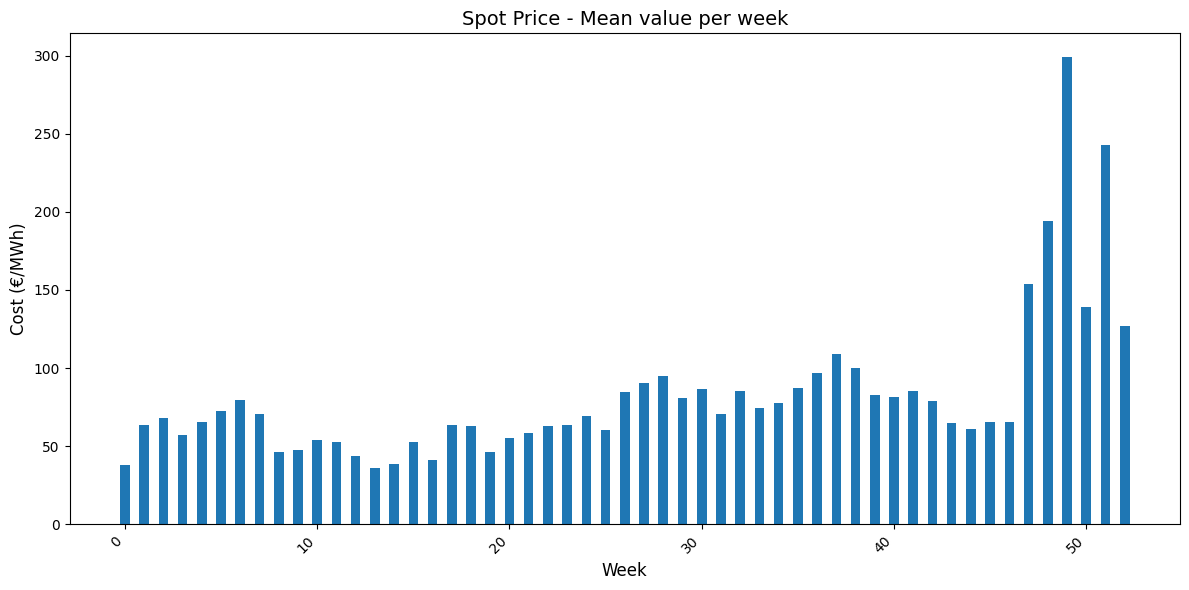

In [19]:
# Assuming 'weeks' is defined as in the previous code (e.g., weekly_data.index)
plt.figure(figsize=(12, 6))
plt.bar(weeks, new_cost_vector, width=0.5)
plt.xlabel('Week', fontsize=12)  # Tick the x-axis label
plt.ylabel('Cost (€/MWh)', fontsize=12)
plt.title('Spot Price - Mean value per week', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [20]:
# Compute the power demand and hours for each week
weekly_demand = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Power demand (MW)'].sum()
weekly_hours = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Timestamp'].count()

# Create a DataFrame with three columns
weekly_data = pd.DataFrame({'Week': weekly_demand.index.strftime('%Y-%m-%d'),
                            'Power Demand (MW)': weekly_demand.values,
                            'Hours': weekly_hours.values})


# Display the results
print(weekly_data)

# Display the number of weeks
print('\n')
print(f"Number of weeks:\n{len(weekly_demand)}")

          Week  Power Demand (MW)  Hours
0   2021-01-03            6215.93     72
1   2021-01-10           19463.08    168
2   2021-01-17           19666.59    168
3   2021-01-24           15377.93    168
4   2021-01-31           16720.59    168
5   2021-02-07           21266.55    168
6   2021-02-14           19826.70    168
7   2021-02-21           19553.90    168
8   2021-02-28           14873.44    168
9   2021-03-07           14677.00    168
10  2021-03-14           17132.02    168
11  2021-03-21           14305.70    168
12  2021-03-28           10970.72    167
13  2021-04-04           10357.67    168
14  2021-04-11           11534.90    168
15  2021-04-18            9091.82    168
16  2021-04-25            8970.06    168
17  2021-05-02           11147.37    168
18  2021-05-09            9432.78    168
19  2021-05-16            4761.67    168
20  2021-05-23            6699.08    168
21  2021-05-30            6630.92    168
22  2021-06-06            3639.51    168
23  2021-06-13  

In [21]:
%%capture

!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# initialize the output
results = []

for i in range(len(weekly_demand)):

  # Define the model
  model = LpProblem("Power_Optimization", sense = LpMinimize)

  # Define the decision variables

  # Power of each boiler for which the cost is minimized
  P_B1 = LpVariable("P_B1", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][0], cat="Continuous")
  P_B2 = LpVariable("P_B2", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][1], cat="Continuous")
  P_B3 = LpVariable("P_B3", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][2], cat="Continuous")
  P_B4 = LpVariable("P_B4", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][3], cat="Continuous")
  P_B5 = LpVariable("P_B5", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][4], cat="Continuous")
  P_B6 = LpVariable("P_B6", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][5], cat="Continuous")


  # Binary variables to control on/off status of boilers
  B_B1 = LpVariable("B_B1", cat="Binary")
  B_B2 = LpVariable("B_B2", cat="Binary")
  B_B3 = LpVariable("B_B3", cat="Binary")
  B_B4 = LpVariable("B_B4", cat="Binary")
  B_B5 = LpVariable("B_B5", cat="Binary")
  B_B6 = LpVariable("B_B6", cat="Binary")

  # Objective function: Minimize total production cost (€/h)
  model += (P_B1 * boiler_df['Cost (€/MWh)'][0] +
           P_B2 * boiler_df['Cost (€/MWh)'][1] +
           P_B3 * boiler_df['Cost (€/MWh)'][2] +
           P_B4 * boiler_df['Cost (€/MWh)'][3] +
           P_B5 * boiler_df['Cost (€/MWh)'][4] +
           P_B6 * boiler_df['Cost (€/MWh)'][5][i])

  # Constraints: Meet weekly demand
  model += (P_B1 + P_B2 + P_B3 + P_B4 + P_B5 + P_B6) * weekly_hours[i] >= weekly_demand[i], f"Demand_Constraint_Week_{i}"

  # Constraints to link binary variables with power output
  model += P_B1 <= boiler_df['Boiler Power max (MW)'][0] * B_B1
  model += P_B1 >= boiler_df['Power min (MW)'][0] * B_B1
  model += P_B2 <= boiler_df['Boiler Power max (MW)'][1] * B_B2
  model += P_B2 >= boiler_df['Power min (MW)'][1] * B_B2
  model += P_B3 <= boiler_df['Boiler Power max (MW)'][2] * B_B3
  model += P_B3 >= boiler_df['Power min (MW)'][2] * B_B3
  model += P_B4 <= boiler_df['Boiler Power max (MW)'][3] * B_B4
  model += P_B4 >= boiler_df['Power min (MW)'][3] * B_B4
  model += P_B5 <= boiler_df['Boiler Power max (MW)'][4] * B_B5
  model += P_B5 >= boiler_df['Power min (MW)'][4] * B_B5
  model += P_B6 <= boiler_df['Boiler Power max (MW)'][5] * B_B6
  model += P_B6 >= boiler_df['Power min (MW)'][5] * B_B6

  # Solve the problem
  model.solve()

  # Append the results to the list
  results.append([P_B1.varValue])
  results.append([P_B2.varValue])
  results.append([P_B3.varValue])
  results.append([P_B4.varValue])
  results.append([P_B5.varValue])
  results.append([P_B6.varValue])

# Convert the list to a NumPy array for easier manipulation
results_array = np.array(results)

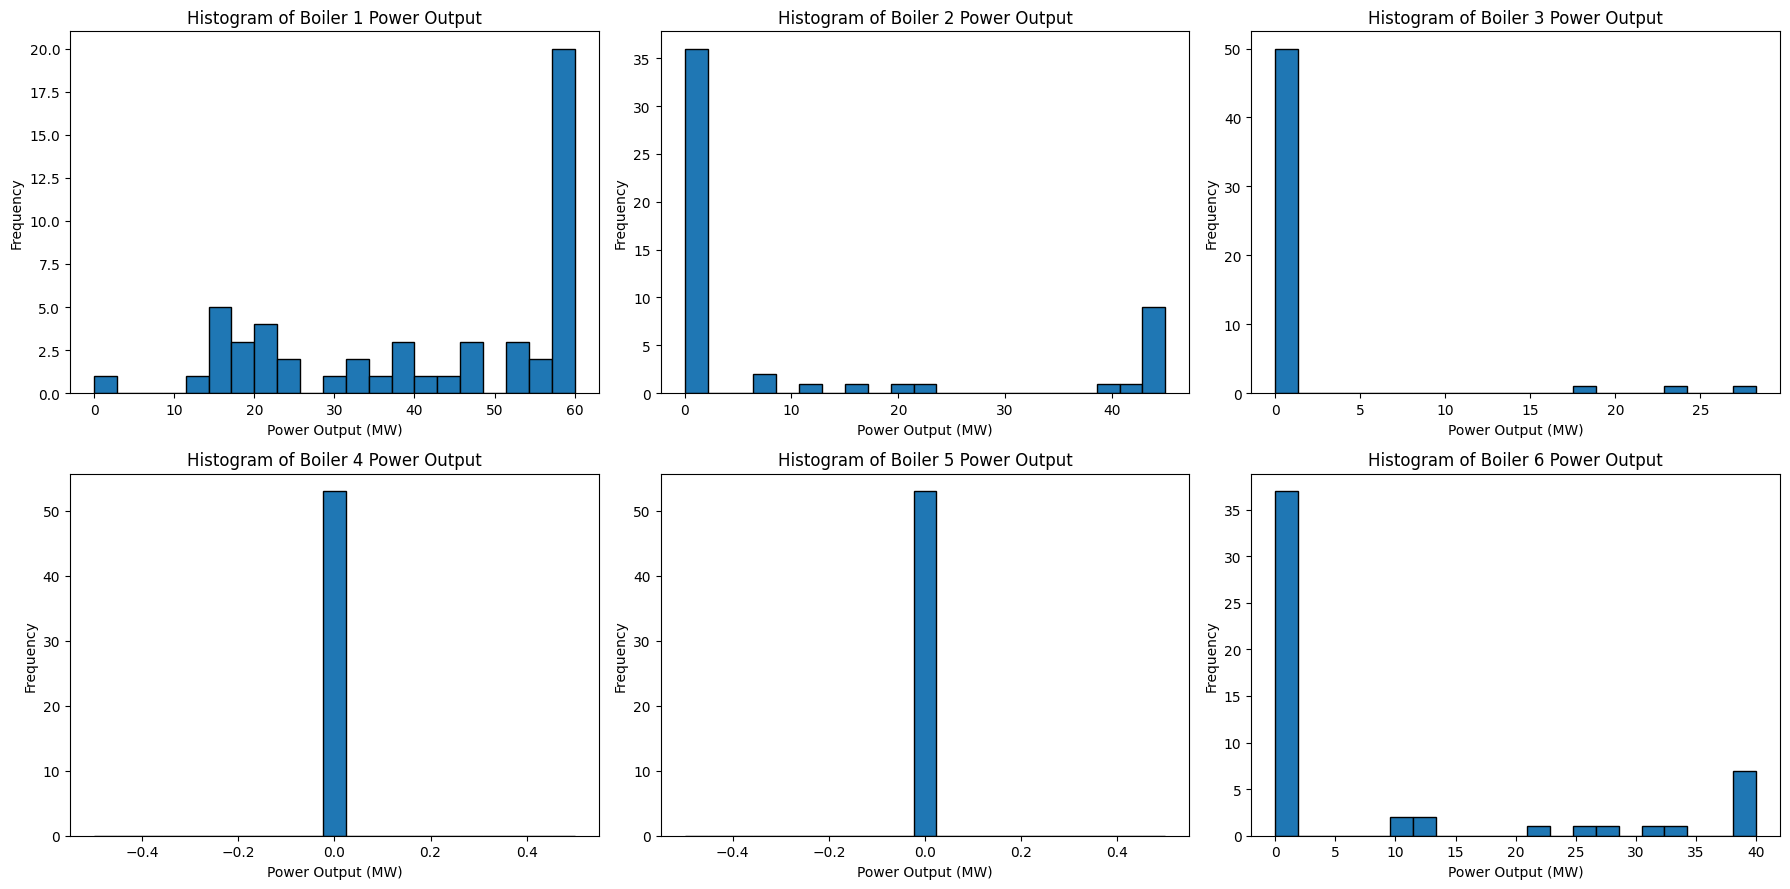

In [22]:
# Operational power of each boiler per week

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a histogram for each boiler in a separate subplot
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[i]  # Get the current subplot axis
    ax.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=21, edgecolor='black')
    ax.set_title(f'Histogram of Boiler {i+1} Power Output')
    ax.set_xlabel('Power Output (MW)')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

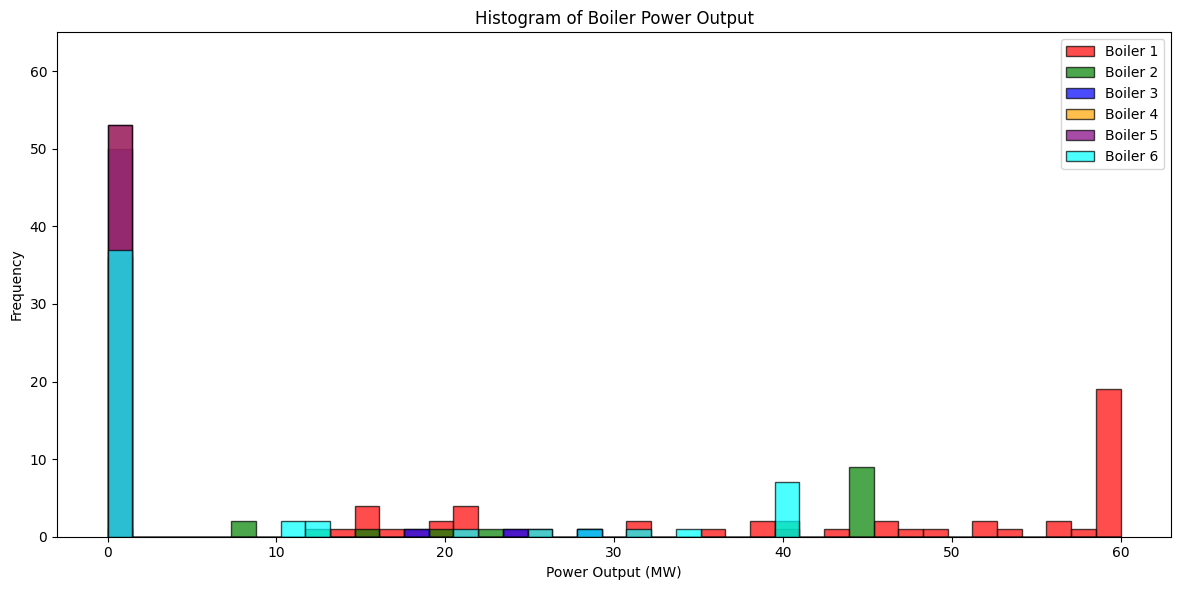

In [23]:
# Colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Create a single plot
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Define a common bins for all histograms
all_boiler_data = results_array[:, 0]  # Combine all boiler data for determining the bins
num_bins = 41
_, bins, _ = plt.hist(all_boiler_data, bins=num_bins, edgecolor='black', alpha=0) # Get common bins for all boilers

# Plot the data for each boiler on the same plot using shared bins
for i in range(boiler_df['Boiler Power max (MW)'].size):
    plt.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=bins, edgecolor='black', alpha=0.7, label=f'Boiler {i+1}', color=colors[i])

plt.title('Histogram of Boiler Power Output')
plt.xlabel('Power Output (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(0, 65)
plt.show()

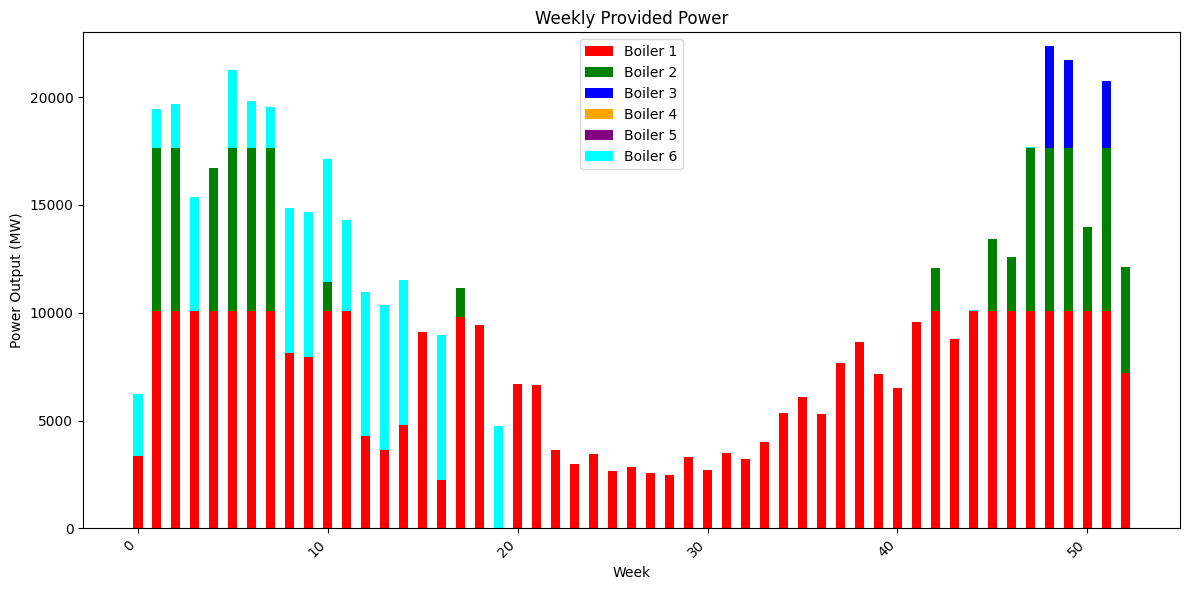

In [24]:
# Define colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Sum the elements of each row (week) to get a vector of 52 elements
reshaped_results_scaled = reshaped_results * weekly_hours.values[:, np.newaxis]
weekly_sums = np.sum(reshaped_results_scaled, axis=1)

# Plot each boiler's power output over time, stacking them
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_scaled[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i],
           bottom=np.sum(reshaped_results_scaled[:, :i], axis=1))  # Stack bars

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Power Output (MW)')
ax.set_title('Weekly Provided Power')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 23000)
plt.show()

In [25]:
boiler_power_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_power_over_year[i] = (reshaped_results_scaled[:, i]).sum()

df_boiler_power = pd.DataFrame(boiler_power_over_year, columns=['Annual Power Output (MW)'])
df_boiler_power.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_provided_power to the DataFrame
annual_provided_power = reshaped_results_scaled.sum()
df_boiler_power.loc['Annual provided power'] = annual_provided_power  # Adding a new row with the name 'Total Provided'

# Calculate and add annual_requested_power to the DataFrame
annual_requested_power = weekly_data['Power Demand (MW)'].sum()
df_boiler_power.loc['Annual requested power'] = annual_requested_power  # Adding a new row with the name 'Total Requested'

# Calculate and add surplus/deficit to the DataFrame
surplus_deficit = annual_provided_power - annual_requested_power
df_boiler_power.loc['Surplus/Deficit'] = surplus_deficit  # Adding a new row for surplus/deficit

# Calculate the percentage for each boiler
df_boiler_power['Power output as percentage of Annual provided power'] = (df_boiler_power['Annual Power Output (MW)'] / annual_provided_power) * 100

# Filter out rows that are not boilers
boiler_rows = df_boiler_power.index.isin(['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6'])
df_boiler_power_filtered = df_boiler_power[boiler_rows]

# Format the percentage column
df_boiler_power['Power output as percentage of Annual provided power'] = df_boiler_power['Power output as percentage of Annual provided power'].map('{:.2f}%'.format)

df_boiler_power  # Displaying the DataFrame


,Annual Power Output (MW),Power output as percentage of Annual provided power
Boiler 1,367125.560141,67.00%
Boiler 2,94008.169944,17.16%
Boiler 3,11945.570112,2.18%
Boiler 4,0.000000,0.00%
Boiler 5,0.000000,0.00%
Boiler 6,74843.240169,13.66%
Annual provided power,547922.540366,100.00%
Annual requested power,547922.540000,100.00%
Surplus/Deficit,0.000366,0.00%


Difference between gas boiler 6 surplus / deficit and electric boiler 6 = 0.0.
 The error is non-null.
Therefore although the distribution of surplus / deficit might look identical to the one of gas boiler 6, the results are correct and distinc.


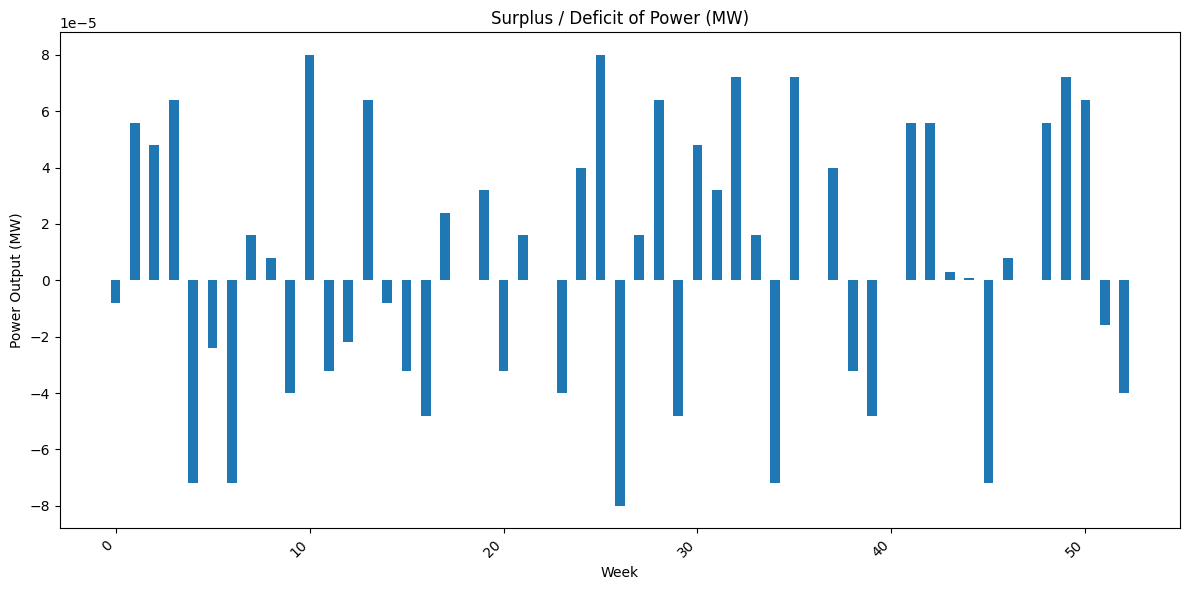

In [26]:
# Copmpute the error
error_2 = weekly_sums - weekly_demand.values
print(f'Difference between gas boiler 6 surplus / deficit and electric boiler 6 = {sum(error_2-error)}.\n'
      ' The error is non-null.\n'
      'Therefore although the distribution of surplus / deficit might look identical to the one of gas boiler 6, the results are correct and distinc.')

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, error_2, width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Surplus / Deficit of Power (MW)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

/tmp/ipython-input-3375574836.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]


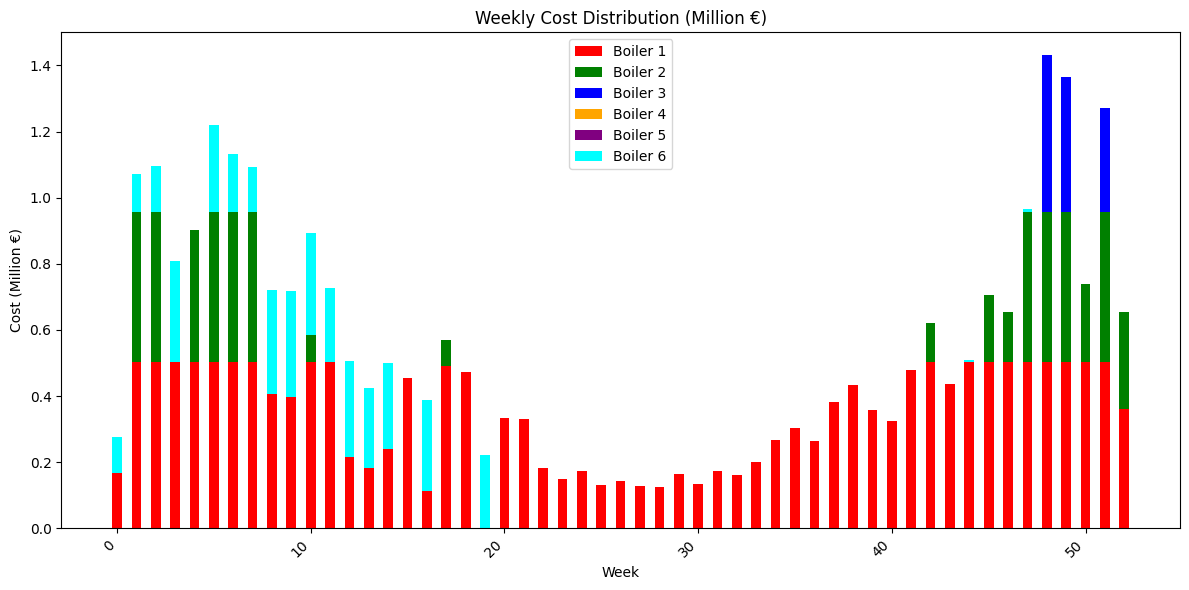

In [27]:
# Define colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# --- Adapted section to handle electric boiler's cost ---
# Initialize an array to store the cost for each boiler each week
reshaped_results_cost = np.zeros_like(reshaped_results, dtype=float)

# Iterate through weeks and boilers to calculate costs
for week_index in range(len(weekly_demand)):
    for boiler_index in range(boiler_df['Boiler Power max (MW)'].size):
        # For the electric boiler, use spot prices for that week
        if boiler_index == boiler_df['Boiler Power max (MW)'].size - 1:  # Assuming electric boiler is the last one
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index][week_index]  # Get spot price for the week
        else:
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index]  # Use fixed cost for other boilers

        # Calculate and store the cost for the boiler that week
        reshaped_results_cost[week_index, boiler_index] = (
            reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]
        )

# --- End of adapted section ---

# Scale the weekly cost data to millions of euros
reshaped_results_cost_millions = reshaped_results_cost / 1000000

# Calculate weekly cost sums
weekly_cost_sums = np.sum(reshaped_results_cost_millions, axis=1)

# Plot each boiler's cost over time, stacking them
bottom = np.zeros(len(weekly_demand))  # Initialize bottom for stacking
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_cost_millions[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i], bottom=bottom)
    bottom += reshaped_results_cost_millions[:, i]  # Update bottom for next boiler's stack

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Cost (Million €)')  # Update y-axis label
ax.set_title('Weekly Cost Distribution (Million €)')  # Update title
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 1.5)  # Update ylim to reflect million € scale
plt.show()

In [28]:
boiler_cost_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_cost_over_year[i] = (reshaped_results_cost_millions[:, i]).sum() # Use reshaped_results_cost_millions here

df_boiler_cost = pd.DataFrame(boiler_cost_over_year, columns=['Annual Cost (Million €)']) # Changed column name
df_boiler_cost.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_total_cost to the DataFrame
annual_total_cost = reshaped_results_cost_millions.sum() # Use reshaped_results_cost_millions here
saving_list.append(annual_total_cost)
df_boiler_cost.loc['Annual total cost'] = annual_total_cost  # Adding a new row with the name 'Annual total cost'

# Calculate the percentage for each boiler (based on cost)
df_boiler_cost['Cost as percentage of Annual total cost'] = (df_boiler_cost['Annual Cost (Million €)'] / annual_total_cost) * 100 # Changed column name

# Format the percentage column
df_boiler_cost['Cost as percentage of Annual total cost'] = df_boiler_cost['Cost as percentage of Annual total cost'].map('{:.2f}%'.format)

df_boiler_cost  # Displaying the DataFrame

,Annual Cost (Million €),Cost as percentage of Annual total cost
Boiler 1,18.356278,63.53%
Boiler 2,5.640490,19.52%
Boiler 3,1.194557,4.13%
Boiler 4,0.000000,0.00%
Boiler 5,0.000000,0.00%
Boiler 6,3.702783,12.82%
Annual total cost,28.894108,100.00%


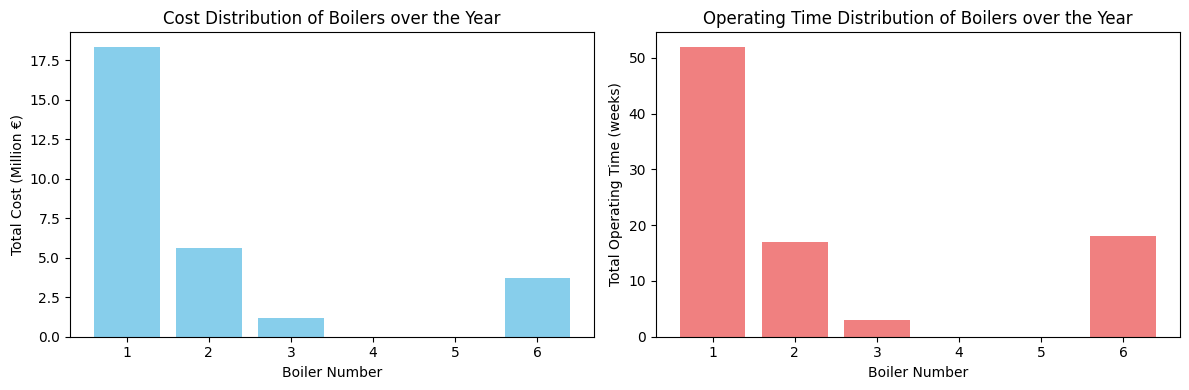

In [29]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot cost distribution on the first subplot
axes[0].bar(range(1, len(boiler_cost_over_year) + 1), boiler_cost_over_year, color='skyblue')
axes[0].set_xlabel("Boiler Number")
axes[0].set_ylabel("Total Cost (Million €)")
axes[0].set_title("Cost Distribution of Boilers over the Year")
axes[0].set_xticks(range(1, len(boiler_cost_over_year) + 1))

# Assuming reshaped_results_scaled contains weekly power output for each boiler
total_operating_time = (reshaped_results_scaled > 0).sum(axis=0)

# Plot operating time distribution on the second subplot
axes[1].bar(range(1, len(total_operating_time) + 1), total_operating_time, color='lightcoral')
axes[1].set_xlabel("Boiler Number")
axes[1].set_ylabel("Total Operating Time (weeks)")
axes[1].set_title("Operating Time Distribution of Boilers over the Year")
axes[1].set_xticks(range(1, len(total_operating_time) + 1))

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

#Part 3
It is clearly feasible to replace both boiler 5 and 6 with the 40 MW electric boiler. Compute
the yearly cost using this configuration. Present cost and operating time distribution over the
year for the boilers. Visualize the result and discuss the findings in relation to parts 1 and 2.

In [30]:
# Assuming you want to delete the row with index 4 (the fifth row)
boiler_df = boiler_df.drop(index=4)
boiler_df

# Re-index the [5] line of boiler_df ans the [4]
boiler_df = boiler_df.reset_index(drop=True)

In [31]:
%%capture

!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# initialize the output
results = []

for i in range(len(weekly_demand)):

  # Define the model
  model = LpProblem("Power_Optimization", sense = LpMinimize)

  # Define the decision variables

  # Power of each boiler for which the cost is minimized
  P_B1 = LpVariable("P_B1", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][0], cat="Continuous")
  P_B2 = LpVariable("P_B2", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][1], cat="Continuous")
  P_B3 = LpVariable("P_B3", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][2], cat="Continuous")
  P_B4 = LpVariable("P_B4", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][3], cat="Continuous")
  P_B5 = LpVariable("P_B5", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][4], cat="Continuous")


  # Binary variables to control on/off status of boilers
  B_B1 = LpVariable("B_B1", cat="Binary")
  B_B2 = LpVariable("B_B2", cat="Binary")
  B_B3 = LpVariable("B_B3", cat="Binary")
  B_B4 = LpVariable("B_B4", cat="Binary")
  B_B5 = LpVariable("B_B5", cat="Binary")

  # Objective function: Minimize total production cost (€/h)
  model += (P_B1 * boiler_df['Cost (€/MWh)'][0] +
           P_B2 * boiler_df['Cost (€/MWh)'][1] +
           P_B3 * boiler_df['Cost (€/MWh)'][2] +
           P_B4 * boiler_df['Cost (€/MWh)'][3] +
           P_B5 * boiler_df['Cost (€/MWh)'][4][i])

  # Constraints: Meet weekly demand
  model += (P_B1 + P_B2 + P_B3 + P_B4 + P_B5) * weekly_hours[i] >= weekly_demand[i], f"Demand_Constraint_Week_{i}"

  # Constraints to link binary variables with power output
  model += P_B1 <= boiler_df['Boiler Power max (MW)'][0] * B_B1
  model += P_B1 >= boiler_df['Power min (MW)'][0] * B_B1
  model += P_B2 <= boiler_df['Boiler Power max (MW)'][1] * B_B2
  model += P_B2 >= boiler_df['Power min (MW)'][1] * B_B2
  model += P_B3 <= boiler_df['Boiler Power max (MW)'][2] * B_B3
  model += P_B3 >= boiler_df['Power min (MW)'][2] * B_B3
  model += P_B4 <= boiler_df['Boiler Power max (MW)'][3] * B_B4
  model += P_B4 >= boiler_df['Power min (MW)'][3] * B_B4
  model += P_B5 <= boiler_df['Boiler Power max (MW)'][4] * B_B5
  model += P_B5 >= boiler_df['Power min (MW)'][4] * B_B5

  # Solve the problem
  model.solve()

  # Append the results to the list
  results.append([P_B1.varValue])
  results.append([P_B2.varValue])
  results.append([P_B3.varValue])
  results.append([P_B4.varValue])
  results.append([P_B5.varValue])

# Convert the list to a NumPy array for easier manipulation
results_array = np.array(results)

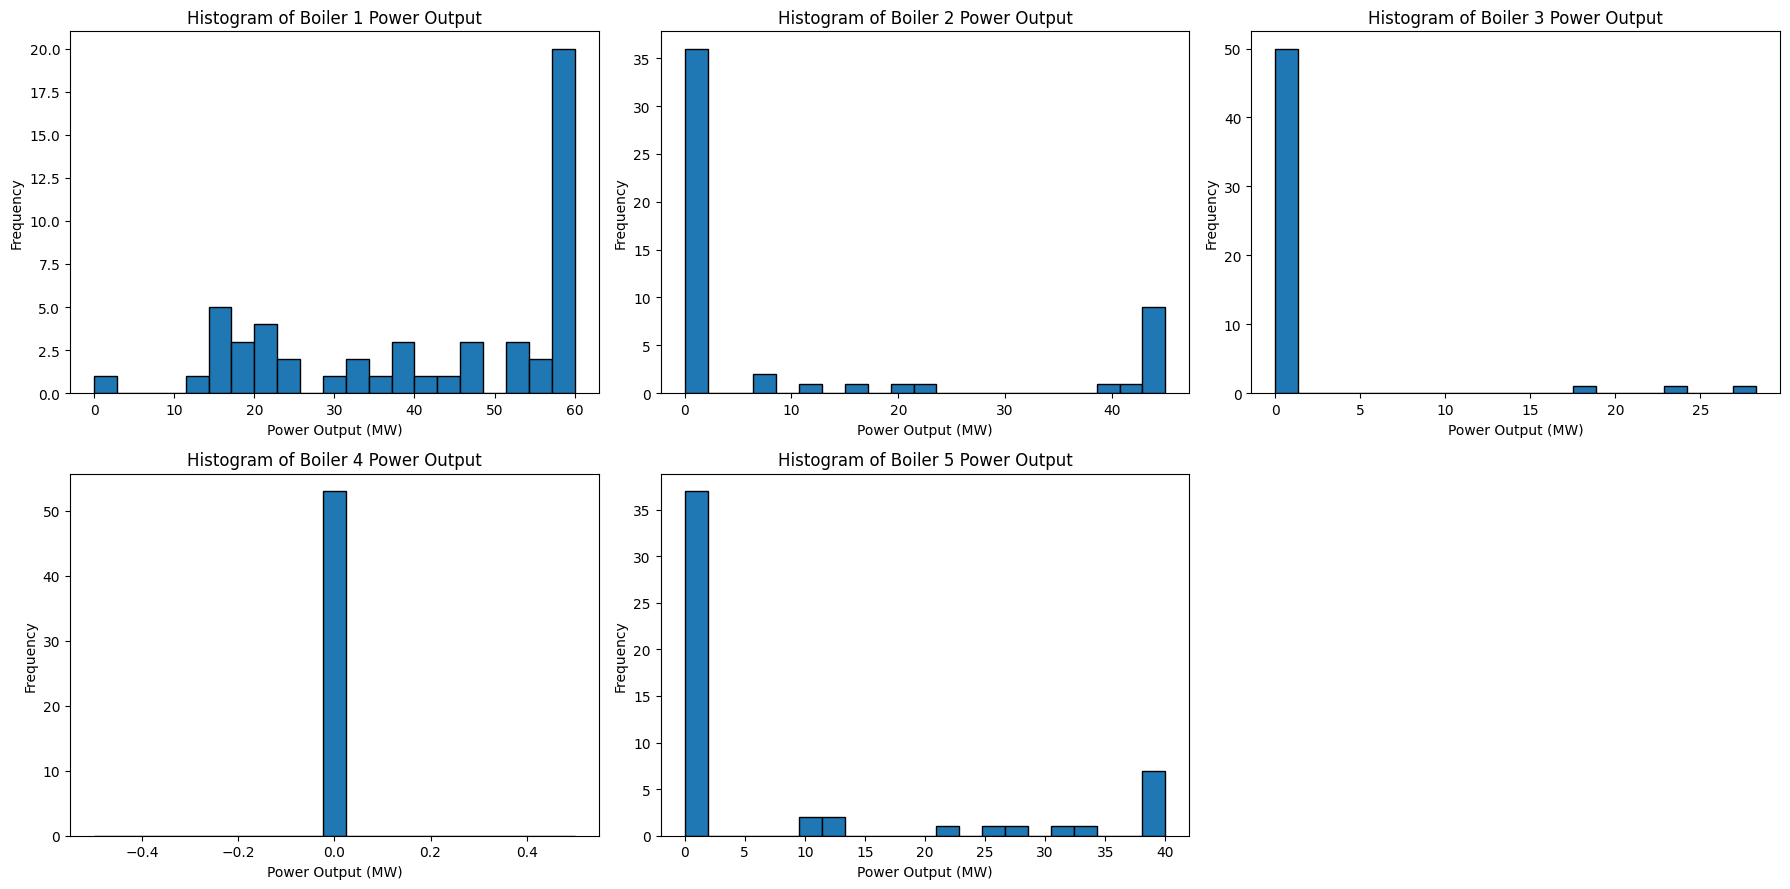

In [32]:
# Operational power of each boiler per week

# Create subplots with the correct number of boilers
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a histogram for each boiler in a separate subplot
num_boilers = boiler_df['Boiler Power max (MW)'].size  # Get the number of boilers
for i in range(num_boilers):
    ax = axes[i]  # Get the current subplot axis
    ax.hist(results_array[i::num_boilers, 0], bins=21, edgecolor='black')
    ax.set_title(f'Histogram of Boiler {i+1} Power Output')
    ax.set_xlabel('Power Output (MW)')
    ax.set_ylabel('Frequency')

# Hide the extra subplots if there are fewer than 6 boilers
num_subplots = axes.size
if num_boilers < num_subplots:
    for i in range(num_boilers, num_subplots):
        axes[i].set_visible(False)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

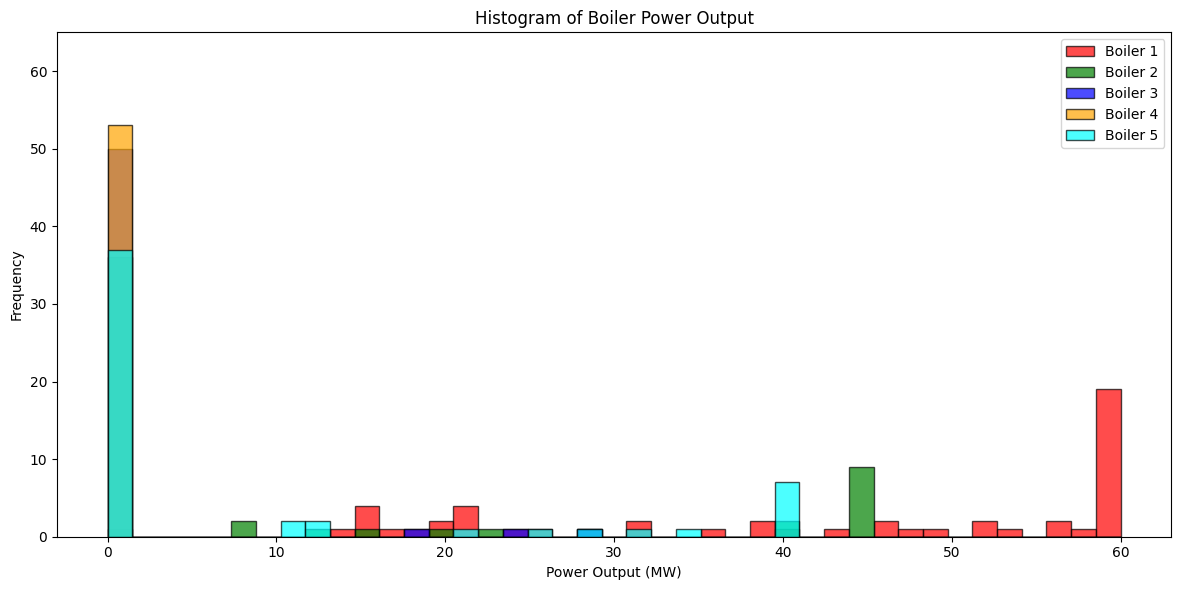

In [33]:
# Colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'cyan']

# Create a single plot
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Define a common bins for all histograms
all_boiler_data = results_array[:, 0]  # Combine all boiler data for determining the bins
num_bins = 41
_, bins, _ = plt.hist(all_boiler_data, bins=num_bins, edgecolor='black', alpha=0) # Get common bins for all boilers

# Plot the data for each boiler on the same plot using shared bins
for i in range(boiler_df['Boiler Power max (MW)'].size):
    plt.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=bins, edgecolor='black', alpha=0.7, label=f'Boiler {i+1}', color=colors[i])

plt.title('Histogram of Boiler Power Output')
plt.xlabel('Power Output (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(0, 65)
plt.show()

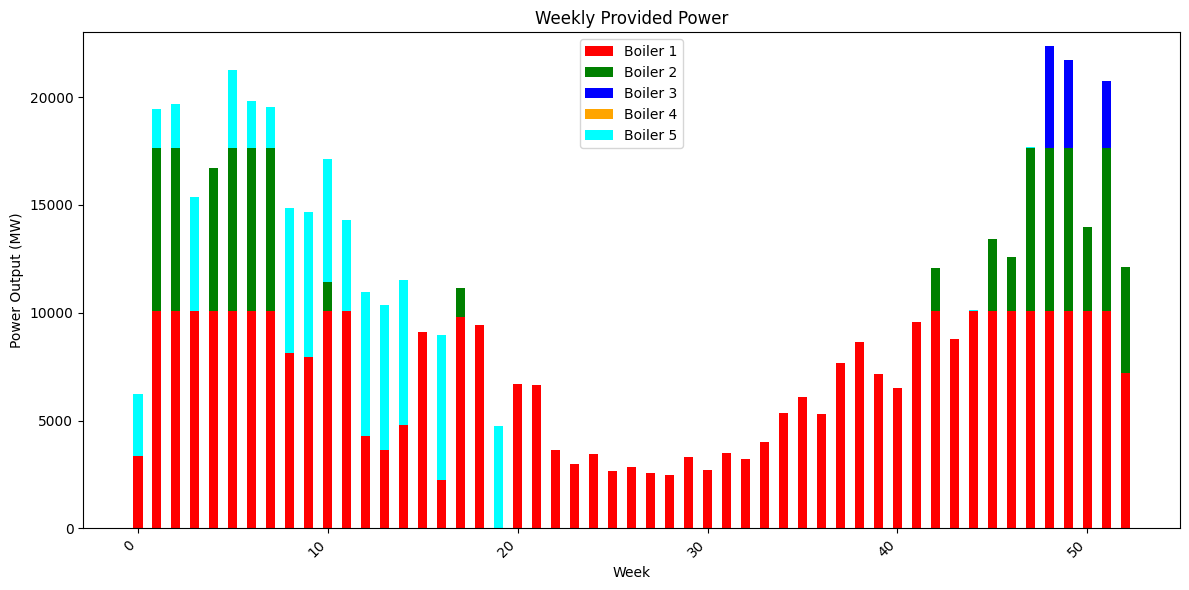

In [34]:
# Define colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'cyan']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Sum the elements of each row (week) to get a vector of 52 elements
reshaped_results_scaled = reshaped_results * weekly_hours.values[:, np.newaxis]
weekly_sums = np.sum(reshaped_results_scaled, axis=1)

# Plot each boiler's power output over time, stacking them
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_scaled[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i],
           bottom=np.sum(reshaped_results_scaled[:, :i], axis=1))  # Stack bars

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Power Output (MW)')
ax.set_title('Weekly Provided Power')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 23000)
plt.show()

In [35]:
boiler_power_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_power_over_year[i] = (reshaped_results_scaled[:, i]).sum()

df_boiler_power = pd.DataFrame(boiler_power_over_year, columns=['Annual Power Output (MW)'])
df_boiler_power.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5']

# Calculate and add annual_provided_power to the DataFrame
annual_provided_power = reshaped_results_scaled.sum()
df_boiler_power.loc['Annual provided power'] = annual_provided_power  # Adding a new row with the name 'Total Provided'

# Calculate and add annual_requested_power to the DataFrame
annual_requested_power = weekly_data['Power Demand (MW)'].sum()
df_boiler_power.loc['Annual requested power'] = annual_requested_power  # Adding a new row with the name 'Total Requested'

# Calculate and add surplus/deficit to the DataFrame
surplus_deficit = annual_provided_power - annual_requested_power
df_boiler_power.loc['Surplus/Deficit'] = surplus_deficit  # Adding a new row for surplus/deficit

# Calculate the percentage for each boiler
df_boiler_power['Power output as percentage of Annual provided power'] = (df_boiler_power['Annual Power Output (MW)'] / annual_provided_power) * 100

# Filter out rows that are not boilers
boiler_rows = df_boiler_power.index.isin(['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6'])
df_boiler_power_filtered = df_boiler_power[boiler_rows]

# Format the percentage column
df_boiler_power['Power output as percentage of Annual provided power'] = df_boiler_power['Power output as percentage of Annual provided power'].map('{:.2f}%'.format)

df_boiler_power  # Displaying the DataFrame


,Annual Power Output (MW),Power output as percentage of Annual provided power
Boiler 1,367125.560141,67.00%
Boiler 2,94008.169944,17.16%
Boiler 3,11945.570112,2.18%
Boiler 4,0.000000,0.00%
Boiler 5,74843.240169,13.66%
Annual provided power,547922.540366,100.00%
Annual requested power,547922.540000,100.00%
Surplus/Deficit,0.000366,0.00%


Difference between gas boiler 6 surplus / deficit and electric boiler 6 = 0.0.
 The error is non-null.
Therefore although the distribution of surplus / deficit might look identical to the one of gas boiler 6, the results are correct and distinc.


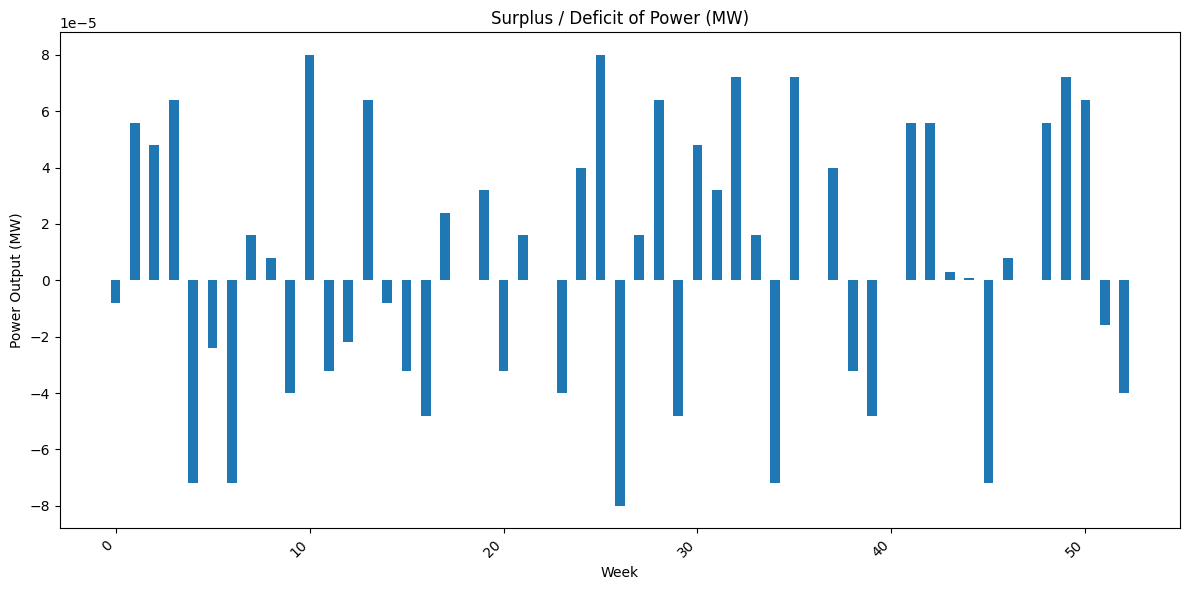

In [36]:
# Copmpute the error
error_3 = weekly_sums - weekly_demand.values
print(f'Difference between gas boiler 6 surplus / deficit and electric boiler 6 = {sum(error_2-error)}.\n'
      ' The error is non-null.\n'
      'Therefore although the distribution of surplus / deficit might look identical to the one of gas boiler 6, the results are correct and distinc.')

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, error_3, width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Surplus / Deficit of Power (MW)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


/tmp/ipython-input-14231236.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]


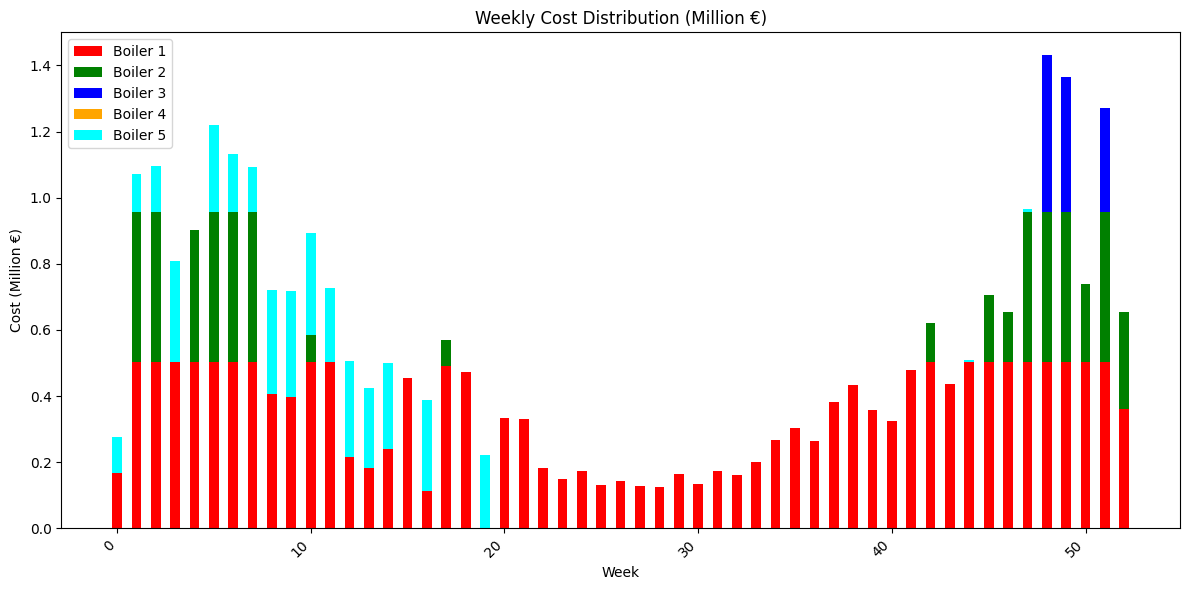

In [37]:
# Define colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'cyan']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# --- Adapted section to handle electric boiler's cost ---
# Initialize an array to store the cost for each boiler each week
reshaped_results_cost = np.zeros_like(reshaped_results, dtype=float)

# Iterate through weeks and boilers to calculate costs
for week_index in range(len(weekly_demand)):
    for boiler_index in range(boiler_df['Boiler Power max (MW)'].size):
        # For the electric boiler, use spot prices for that week
        if boiler_index == boiler_df['Boiler Power max (MW)'].size - 1:  # Assuming electric boiler is the last one
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index][week_index]  # Get spot price for the week
        else:
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index]  # Use fixed cost for other boilers

        # Calculate and store the cost for the boiler that week
        reshaped_results_cost[week_index, boiler_index] = (
            reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]
        )

# --- End of adapted section ---

# Scale the weekly cost data to millions of euros
reshaped_results_cost_millions = reshaped_results_cost / 1000000

# Calculate weekly cost sums
weekly_cost_sums = np.sum(reshaped_results_cost_millions, axis=1)

# Plot each boiler's cost over time, stacking them
bottom = np.zeros(len(weekly_demand))  # Initialize bottom for stacking
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_cost_millions[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i], bottom=bottom)
    bottom += reshaped_results_cost_millions[:, i]  # Update bottom for next boiler's stack

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Cost (Million €)')  # Update y-axis label
ax.set_title('Weekly Cost Distribution (Million €)')  # Update title
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 1.5)  # Update ylim to reflect million € scale
plt.show()

In [38]:
boiler_cost_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_cost_over_year[i] = (reshaped_results_cost_millions[:, i]).sum() # Use reshaped_results_cost_millions here

df_boiler_cost = pd.DataFrame(boiler_cost_over_year, columns=['Annual Cost (Million €)']) # Changed column name
df_boiler_cost.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5']

# Calculate and add annual_total_cost to the DataFrame
annual_total_cost = reshaped_results_cost_millions.sum() # Use reshaped_results_cost_millions here
saving_list.append(annual_total_cost)
df_boiler_cost.loc['Annual total cost'] = annual_total_cost  # Adding a new row with the name 'Annual total cost'

# Calculate the percentage for each boiler (based on cost)
df_boiler_cost['Cost as percentage of Annual total cost'] = (df_boiler_cost['Annual Cost (Million €)'] / annual_total_cost) * 100 # Changed column name

# Format the percentage column
df_boiler_cost['Cost as percentage of Annual total cost'] = df_boiler_cost['Cost as percentage of Annual total cost'].map('{:.2f}%'.format)

df_boiler_cost  # Displaying the DataFrame

,Annual Cost (Million €),Cost as percentage of Annual total cost
Boiler 1,18.356278,63.53%
Boiler 2,5.640490,19.52%
Boiler 3,1.194557,4.13%
Boiler 4,0.000000,0.00%
Boiler 5,3.702783,12.82%
Annual total cost,28.894108,100.00%


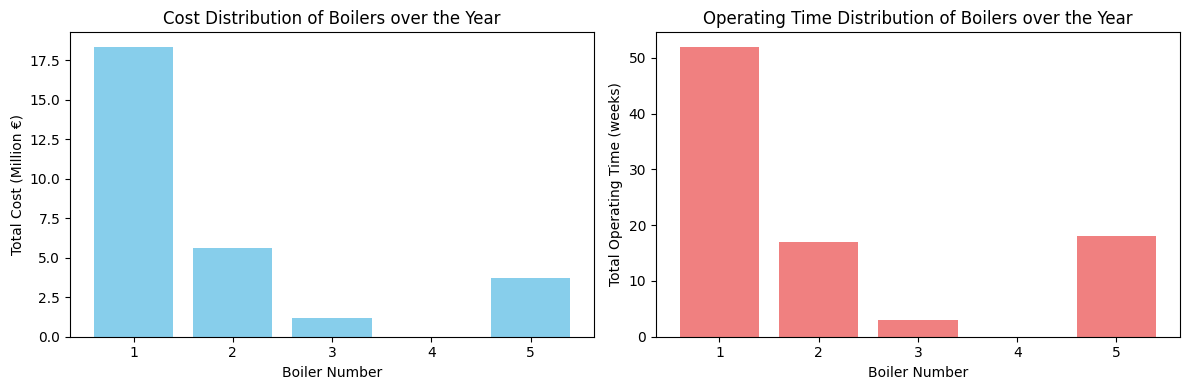

In [39]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot cost distribution on the first subplot
axes[0].bar(range(1, len(boiler_cost_over_year) + 1), boiler_cost_over_year, color='skyblue')
axes[0].set_xlabel("Boiler Number")
axes[0].set_ylabel("Total Cost (Million €)")
axes[0].set_title("Cost Distribution of Boilers over the Year")
axes[0].set_xticks(range(1, len(boiler_cost_over_year) + 1))

# Assuming reshaped_results_scaled contains weekly power output for each boiler
total_operating_time = (reshaped_results_scaled > 0).sum(axis=0)

# Plot operating time distribution on the second subplot
axes[1].bar(range(1, len(total_operating_time) + 1), total_operating_time, color='lightcoral')
axes[1].set_xlabel("Boiler Number")
axes[1].set_ylabel("Total Operating Time (weeks)")
axes[1].set_title("Operating Time Distribution of Boilers over the Year")
axes[1].set_xticks(range(1, len(total_operating_time) + 1))

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [40]:
# ADJUST saving_list BY EYE

# Analysis of Boiler Investment

# Given information
boiler_purchase_cost = 5  # Million €

# Data from previous analysis (assuming availability)
annual_total_cost = df_boiler_cost.loc['Annual total cost', 'Annual Cost (Million €)'] # Accessing the value directly

scenario_names = ['Scenario 1 (All Gas)', 'Scenario 2 (Electric for Boiler 6)', 'Scenario 3 (Electric for Boilers 5 & 6)']  # Adjust names if needed
data = {'Scenario': scenario_names, 'Total Cost (Million €)': saving_list}
df = pd.DataFrame(data)
display(df)
print('\n')

annual_total_cost_original = saving_list[0]
annual_total_cost_electric = saving_list[2]
annual_savings = annual_total_cost_original - annual_total_cost_electric
print(f"Annual savings: {annual_savings:.2f} Million €")


# Calculate Key Metrics
# 1. Payback Time:
#    Payback Time = Boiler Purchase Cost / Annual Savings
if annual_savings != 0:
  payback_time = boiler_purchase_cost / annual_savings
  payback_time_months = payback_time * 12  # Convert to months
  print(f"Payback Time: {payback_time_months} months")
else:
  print("Annual savings are needed to calculate payback time")


# 2. Return on Investment (ROI):
#    ROI = (Annual Savings / Boiler Purchase Cost) * 100
if annual_savings != 0:
  roi = (annual_savings / boiler_purchase_cost) * 100
  print(f"Return on Investment (ROI): {roi:.2f}%")
else:
  print("Annual savings are needed to calculate ROI")


,Scenario,Total Cost (Million €)
0,Scenario 1 (All Gas),29.831298
1,Scenario 2 (Electric for Boiler 6),28.894108
2,Scenario 3 (Electric for Boilers 5 & 6),28.894108




Annual savings: 0.94 Million €
Payback Time: 64.02116898616683 months
Return on Investment (ROI): 18.74%


# Point 5
Let' find out if optimizing the weekly_demand is a good strategy. Since there might be significant fluctuations during some days of the week, other boilers might eneter into the weekly consumption, or the operational distribution of other boilers over the week might be different.
I will implement a code that optimizes the power for each hour (so i grant that the power consumption during each hour is respected) and sums up the demanded power over each week.

In [41]:
%%capture
%reset -f
!pip install --upgrade pandas
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
from google.colab import drive
drive.mount('/content/drive')
import os
google_drive_root = '/content/drive/MyDrive'
assignment_loc = '/Novia/Industrial_AI/Assignment1'
os.chdir(google_drive_root + assignment_loc)
xlsx_file_name = 'PowerDemand_SpotPrices_Corrected.xlsx'
data = pd.read_excel(xlsx_file_name, engine='openpyxl')

In [42]:
data.head()

,Timestamp,Power demand (MW),Spot price (€/MWh),CORRECT Spot price (€/MWh),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2021-01-01 00:00:00.015,69.92,24.07,24.07,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00.010,68.92,24.95,24.95,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00.005,74.27,24.35,24.35,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00.000,80.68,23.98,23.98,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00.000,82.06,23.72,23.72,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Information on existing boilers
boiler_data = {
    'Boiler Power max (MW)': [60, 45, 30, 25, 20, 15],
    'Power min (MW)': [12, 8, 5, 5, 0, 0],
    'Cost (€/MWh)': [50, 60, 100, 120, 160, 200]
}

boiler_df = pd.DataFrame(boiler_data)
boiler_df

,Boiler Power max (MW),Power min (MW),Cost (€/MWh)
0,60,12,50
1,45,8,60
2,30,5,100
3,25,5,120
4,20,0,160
5,15,0,200


In [44]:
# Compute the power demand and hours for each week
weekly_demand = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Power demand (MW)'].sum()
weekly_hours = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Timestamp'].count()

# Create a DataFrame with three columns
weekly_data = pd.DataFrame({'Week': weekly_demand.index.strftime('%Y-%m-%d'),
                            'Power Demand (MW)': weekly_demand.values,
                            'Hours': weekly_hours.values})


# Display the results
print(weekly_data)

# Display the number of weeks
print('\n')
print(f"Number of weeks:\n{len(weekly_demand)}")


          Week  Power Demand (MW)  Hours
0   2021-01-03            6215.93     72
1   2021-01-10           19463.08    168
2   2021-01-17           19666.59    168
3   2021-01-24           15377.93    168
4   2021-01-31           16720.59    168
5   2021-02-07           21266.55    168
6   2021-02-14           19826.70    168
7   2021-02-21           19553.90    168
8   2021-02-28           14873.44    168
9   2021-03-07           14677.00    168
10  2021-03-14           17132.02    168
11  2021-03-21           14305.70    168
12  2021-03-28           10970.72    167
13  2021-04-04           10357.67    168
14  2021-04-11           11534.90    168
15  2021-04-18            9091.82    168
16  2021-04-25            8970.06    168
17  2021-05-02           11147.37    168
18  2021-05-09            9432.78    168
19  2021-05-16            4761.67    168
20  2021-05-23            6699.08    168
21  2021-05-30            6630.92    168
22  2021-06-06            3639.51    168
23  2021-06-13  

In [45]:
%%capture

!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# initialize the output
results = []

for i in range(len(data["Power demand (MW)"])):

  # Define the model
  model = LpProblem("Power_Optimization", sense = LpMinimize)

  # Define the decision variables

  # Power of each boiler for which the cost is minimized
  P_B1 = LpVariable("P_B1", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][0], cat="Continuous")
  P_B2 = LpVariable("P_B2", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][1], cat="Continuous")
  P_B3 = LpVariable("P_B3", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][2], cat="Continuous")
  P_B4 = LpVariable("P_B4", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][3], cat="Continuous")
  P_B5 = LpVariable("P_B5", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][4], cat="Continuous")
  P_B6 = LpVariable("P_B6", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][5], cat="Continuous")


  # Binary variables to control on/off status of boilers
  B_B1 = LpVariable("B_B1", cat="Binary")
  B_B2 = LpVariable("B_B2", cat="Binary")
  B_B3 = LpVariable("B_B3", cat="Binary")
  B_B4 = LpVariable("B_B4", cat="Binary")
  B_B5 = LpVariable("B_B5", cat="Binary")
  B_B6 = LpVariable("B_B6", cat="Binary")

  # Objective function: Minimize total production cost (€/h)
  model += (P_B1 * boiler_df['Cost (€/MWh)'][0] +
           P_B2 * boiler_df['Cost (€/MWh)'][1] +
           P_B3 * boiler_df['Cost (€/MWh)'][2] +
           P_B4 * boiler_df['Cost (€/MWh)'][3] +
           P_B5 * boiler_df['Cost (€/MWh)'][4] +
           P_B6 * boiler_df['Cost (€/MWh)'][5])

  # Constraints: Meet weekly demand
  model += (P_B1 + P_B2 + P_B3 + P_B4 + P_B5 + P_B6) >= data["Power demand (MW)"][i], f"Demand_Constraint_Hour_{i}"

  # Constraints to link binary variables with power output
  model += P_B1 <= boiler_df['Boiler Power max (MW)'][0] * B_B1
  model += P_B1 >= boiler_df['Power min (MW)'][0] * B_B1
  model += P_B2 <= boiler_df['Boiler Power max (MW)'][1] * B_B2
  model += P_B2 >= boiler_df['Power min (MW)'][1] * B_B2
  model += P_B3 <= boiler_df['Boiler Power max (MW)'][2] * B_B3
  model += P_B3 >= boiler_df['Power min (MW)'][2] * B_B3
  model += P_B4 <= boiler_df['Boiler Power max (MW)'][3] * B_B4
  model += P_B4 >= boiler_df['Power min (MW)'][3] * B_B4
  model += P_B5 <= boiler_df['Boiler Power max (MW)'][4] * B_B5
  model += P_B5 >= boiler_df['Power min (MW)'][4] * B_B5
  model += P_B6 <= boiler_df['Boiler Power max (MW)'][5] * B_B6
  model += P_B6 >= boiler_df['Power min (MW)'][5] * B_B6

  # Solve the problem
  model.solve()

  # Append the results to the list

  results.append([P_B1.varValue, P_B2.varValue, P_B3.varValue, P_B4.varValue, P_B5.varValue, P_B6.varValue])
  '''
  results.append([P_B1.varValue])
  results.append([P_B2.varValue])
  results.append([P_B3.varValue])
  results.append([P_B4.varValue])
  results.append([P_B5.varValue])
  results.append([P_B6.varValue])
  '''

# Convert the list to a NumPy array for easier manipulation
results_array = np.array(results)

In [46]:
%%capture
# compute the mean value per week for each boiler in results_array

# Calculate the mean value per week for each boiler
weekly_means = []
for i in range(results_array.shape[1]):  # Iterate through each boiler
    boiler_power = results_array[:, i]
    # Reshape the hourly data into weekly data using weekly_hours
    weekly_boiler_power = []
    start_index = 0
    for hours_in_week in weekly_hours:
        end_index = start_index + hours_in_week
        weekly_boiler_power.append(boiler_power[start_index:end_index])
        start_index = end_index

    # Calculate mean of the power output in each week for each boiler
    # The if statement checks if weekly_boiler_power[j] is empty
    weekly_boiler_mean = np.array([np.mean(week) if week.size else 0 for week in weekly_boiler_power])
    weekly_means.append(weekly_boiler_mean)

# Create a DataFrame to store the weekly means for each boiler
weekly_means_df = pd.DataFrame(weekly_means).T
weekly_means_df.columns = [f'Boiler {i+1}' for i in range(results_array.shape[1])]
weekly_means_df.index = weekly_data.index

# Now weekly_means_df contains the mean power output per week for each boiler
weekly_means_df

In [47]:
%%capture
# reshape weekly_means_df to meet the format of results_array

# Reshape weekly_means_df to a single column
results_array = weekly_means_df.values.reshape(-1, 1)

# Create a new DataFrame with the reshaped array
reshaped_df = pd.DataFrame(results_array, columns=['results_array'])

# Display or further process the reshaped DataFrame
reshaped_df

results_array = reshaped_df.values

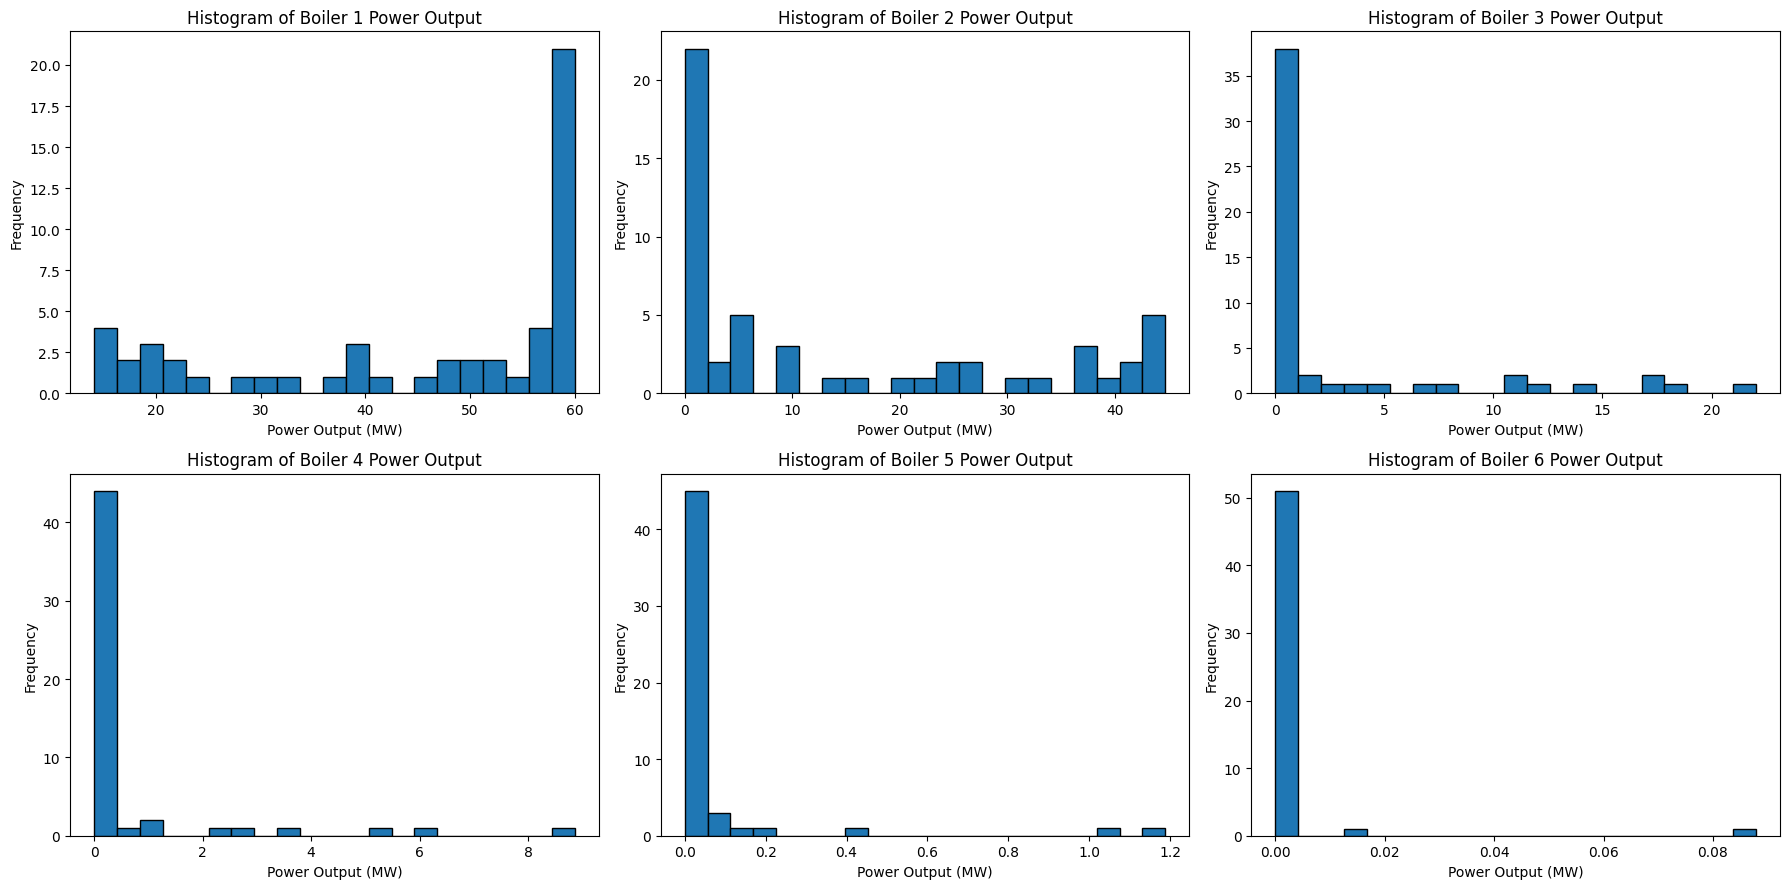

In [48]:
# Operational power of each boiler per week

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a histogram for each boiler in a separate subplot
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[i]  # Get the current subplot axis
    ax.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=21, edgecolor='black')
    ax.set_title(f'Histogram of Boiler {i+1} Power Output')
    ax.set_xlabel('Power Output (MW)')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

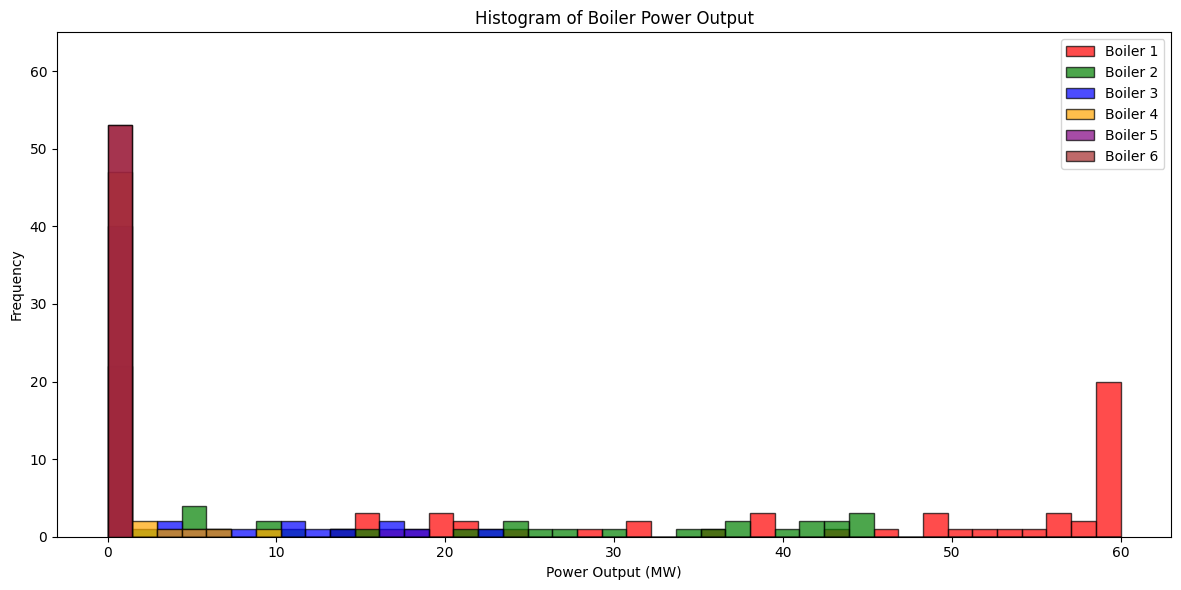

In [49]:
# Colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

# Create a single plot
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Define a common bins for all histograms
all_boiler_data = results_array[:, 0]  # Combine all boiler data for determining the bins
num_bins = 41
_, bins, _ = plt.hist(all_boiler_data, bins=num_bins, edgecolor='black', alpha=0) # Get common bins for all boilers

# Plot the data for each boiler on the same plot using shared bins
for i in range(boiler_df['Boiler Power max (MW)'].size):
    plt.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=bins, edgecolor='black', alpha=0.7, label=f'Boiler {i+1}', color=colors[i])

plt.title('Histogram of Boiler Power Output')
plt.xlabel('Power Output (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(0, 65)
plt.show()

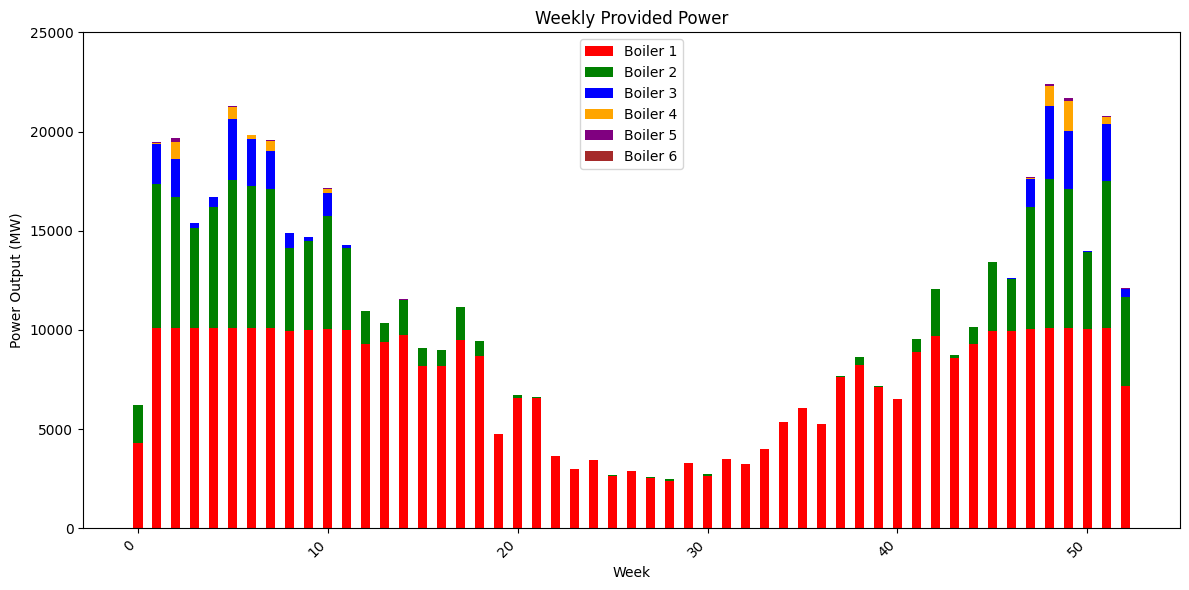

In [50]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Sum the elements of each row (week) to get a vector of 52 elements
reshaped_results_scaled = reshaped_results.astype(float) * weekly_hours.values[:, np.newaxis].astype(float)    # Delete the .astype(float)
weekly_sums = np.sum(reshaped_results_scaled, axis=1)

# Plot each boiler's power output over time, stacking them
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_scaled[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i],
           bottom=np.sum(reshaped_results_scaled[:, :i], axis=1))  # Stack bars

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Power Output (MW)')
ax.set_title('Weekly Provided Power')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 25000)
plt.show()

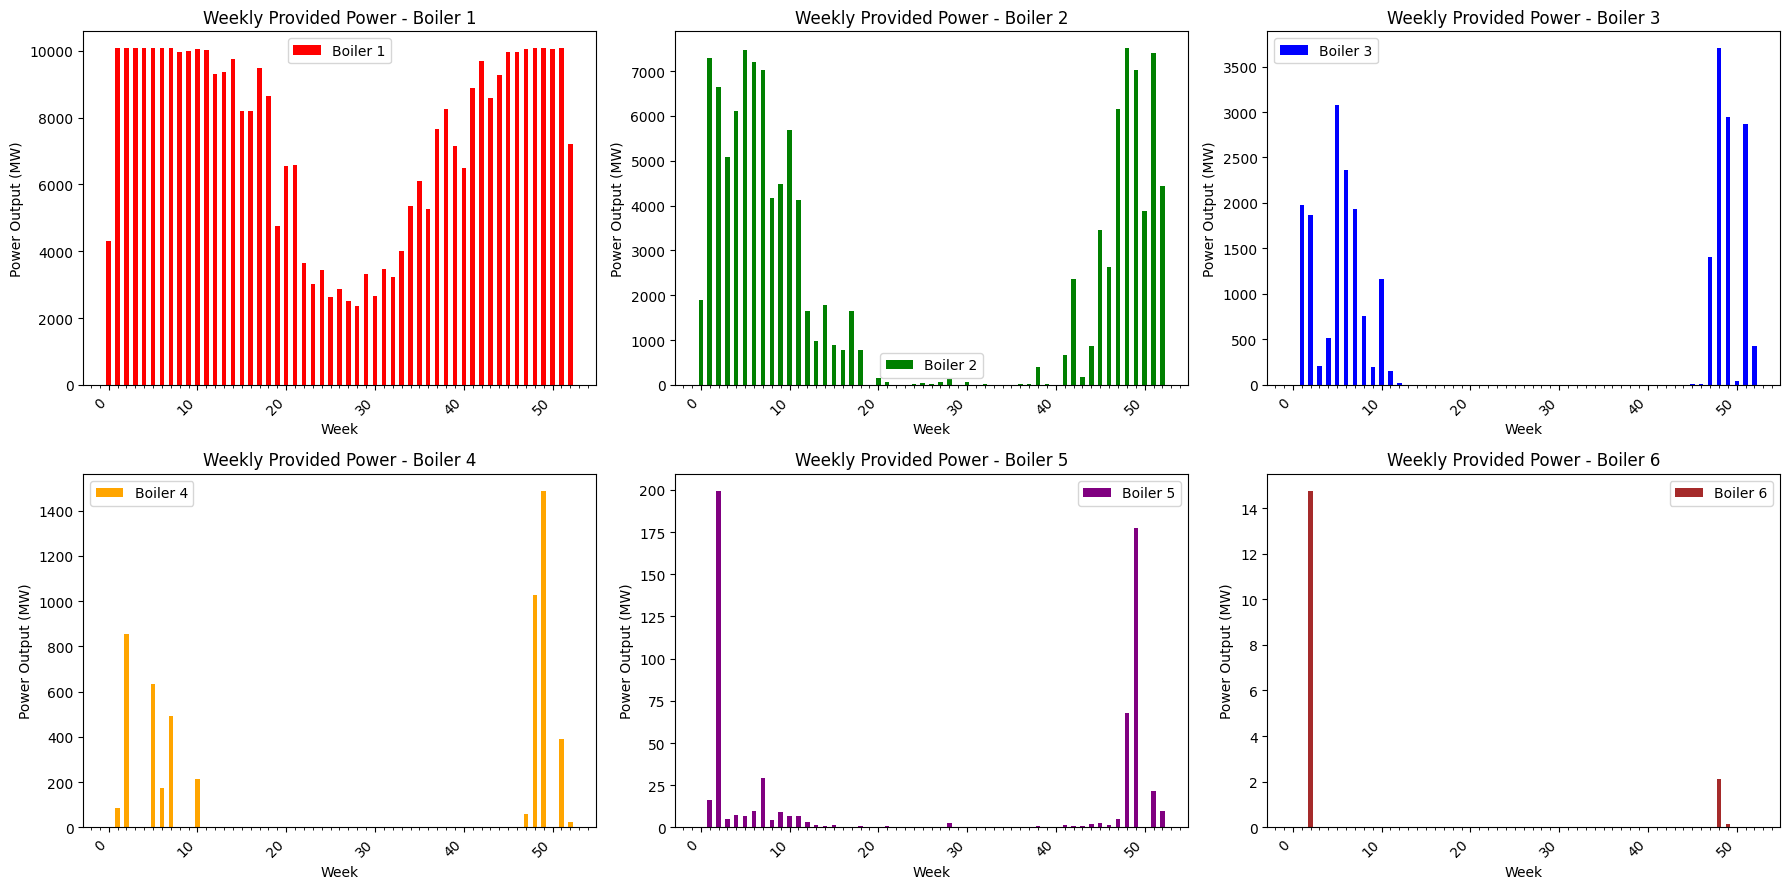

In [51]:
import matplotlib.ticker as ticker

# Create subplots (2 rows, 3 columns to accommodate 6 boilers)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each boiler and plot its data on a separate subplot
for ii in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[ii]  # Get the current subplot axis

    ax.bar(weeks, reshaped_results_scaled[:, ii], width=0.5,
           label=f'Boiler {ii+1}', color=colors[ii])

    # Customize the subplot
    ax.set_xlabel('Week')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(f'Weekly Provided Power - Boiler {ii+1}')
    ax.legend()

    # Set x-axis ticks (same as before)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}' if x % 10 == 0 else ''))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlapping and display the subplots
plt.tight_layout()
plt.show()

In [52]:
boiler_power_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_power_over_year[i] = (reshaped_results_scaled[:, i]).sum()

df_boiler_power = pd.DataFrame(boiler_power_over_year, columns=['Annual Power Output (MW)'])
df_boiler_power.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_provided_power to the DataFrame
annual_provided_power = reshaped_results_scaled.sum()
df_boiler_power.loc['Annual provided power'] = annual_provided_power  # Adding a new row with the name 'Total Provided'

# Calculate and add annual_requested_power to the DataFrame
annual_requested_power = weekly_data['Power Demand (MW)'].sum()
df_boiler_power.loc['Annual requested power'] = annual_requested_power  # Adding a new row with the name 'Total Requested'

# Calculate and add surplus/deficit to the DataFrame
surplus_deficit = annual_provided_power - annual_requested_power
df_boiler_power.loc['Surplus/Deficit'] = surplus_deficit  # Adding a new row for surplus/deficit

# Calculate the percentage for each boiler
df_boiler_power['Power output as percentage of Annual provided power'] = (df_boiler_power['Annual Power Output (MW)'] / annual_provided_power) * 100

# Filter out rows that are not boilers
boiler_rows = df_boiler_power.index.isin(['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6'])
df_boiler_power_filtered = df_boiler_power[boiler_rows]

# Format the percentage column
df_boiler_power['Power output as percentage of Annual provided power'] = df_boiler_power['Power output as percentage of Annual provided power'].map('{:.2f}%'.format)

df_boiler_power  # Displaying the DataFrame


,Annual Power Output (MW),Power output as percentage of Annual provided power
Boiler 1,393144.64,71.74%
Boiler 2,123184.70,22.48%
Boiler 3,25650.34,4.68%
Boiler 4,5437.26,0.99%
Boiler 5,603.70,0.11%
Boiler 6,17.02,0.00%
Annual provided power,548037.66,100.00%
Annual requested power,547922.54,99.98%
Surplus/Deficit,115.12,0.02%


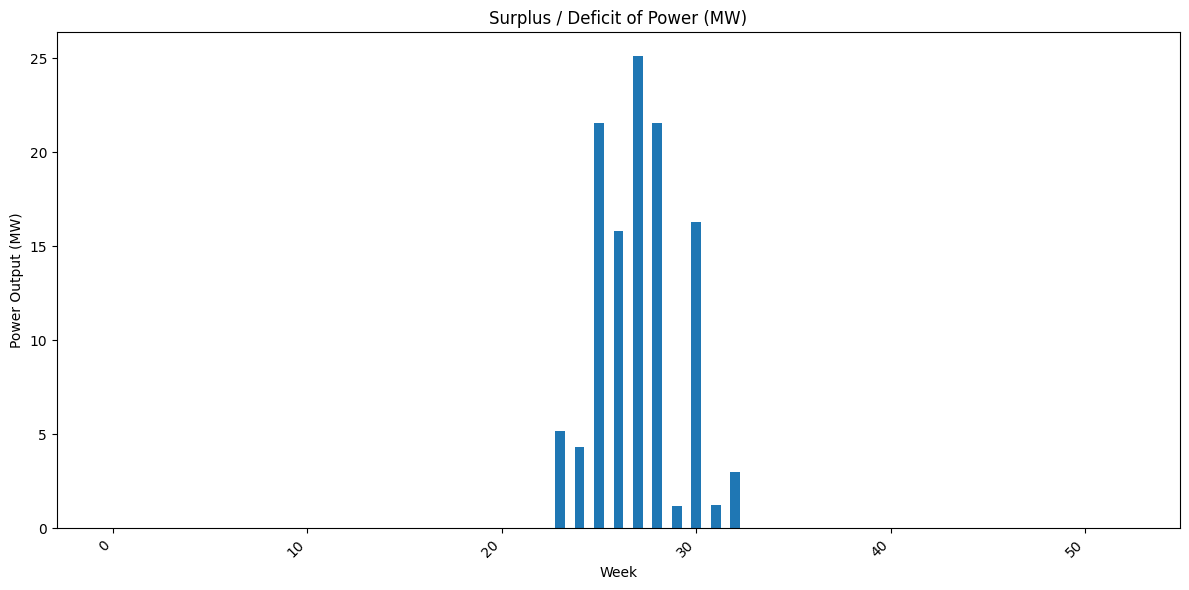

In [53]:
# Copmpute the error
error = weekly_sums - weekly_demand.values

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, error, width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Surplus / Deficit of Power (MW)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


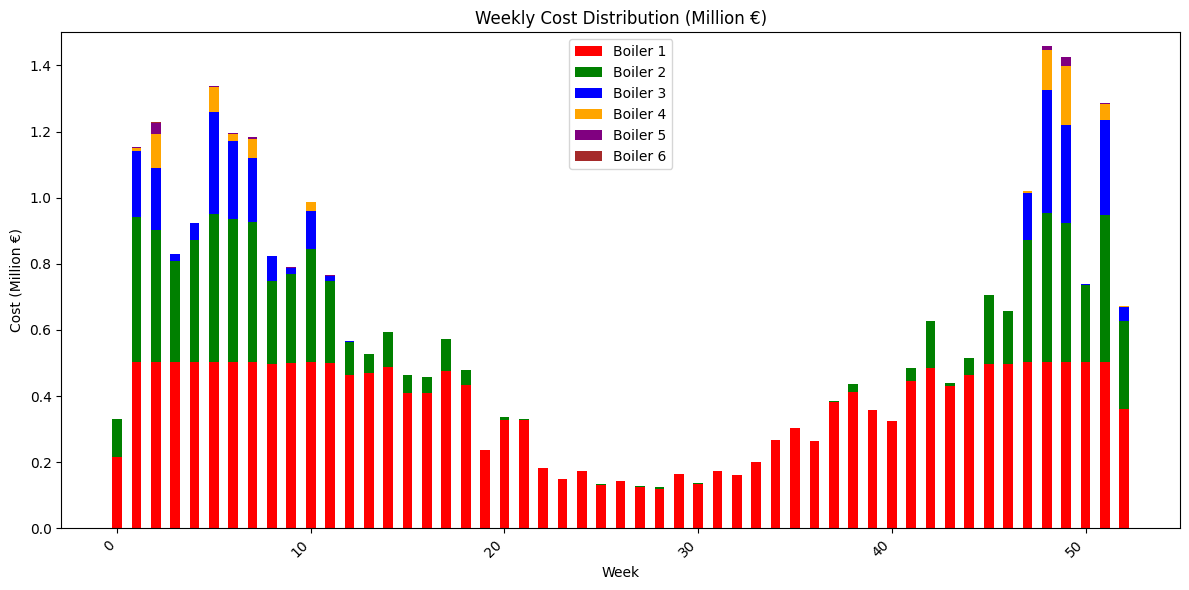

In [54]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Multiply power output by cost per MWh and hours to get cost for each boiler per week
reshaped_results_cost = reshaped_results * boiler_df['Cost (€/MWh)'].values * weekly_hours.values[:, np.newaxis]

# Scale the weekly cost data to millions of euros
reshaped_results_cost_millions = reshaped_results_cost / 1000000

# Calculate weekly cost sums
weekly_cost_sums = np.sum(reshaped_results_cost, axis=1)

# Plot each boiler's cost over time, stacking them
bottom = np.zeros(len(weekly_demand))  # Initialize bottom for stacking
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_cost_millions[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i], bottom=bottom)
    bottom += reshaped_results_cost_millions[:, i]  # Update bottom for next boiler's stack

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Cost (Million €)')  # Update y-axis label
ax.set_title('Weekly Cost Distribution (Million €)')  # Update title
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 1.5)  # Update ylim to reflect million € scale
plt.show()

In [55]:
boiler_cost_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_cost_over_year[i] = (reshaped_results_cost_millions[:, i]).sum() # Use reshaped_results_cost_millions here

df_boiler_cost = pd.DataFrame(boiler_cost_over_year, columns=['Annual Cost (Million €)']) # Changed column name
df_boiler_cost.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_total_cost to the DataFrame
saving_list=[]
annual_total_cost = reshaped_results_cost_millions.sum() # Use reshaped_results_cost_millions here
saving_list.append(annual_total_cost)
df_boiler_cost.loc['Annual total cost'] = annual_total_cost  # Adding a new row with the name 'Annual total cost'

# Calculate the percentage for each boiler (based on cost)
df_boiler_cost['Cost as percentage of Annual total cost'] = (df_boiler_cost['Annual Cost (Million €)'] / annual_total_cost) * 100 # Changed column name

# Format the percentage column
df_boiler_cost['Cost as percentage of Annual total cost'] = df_boiler_cost['Cost as percentage of Annual total cost'].map('{:.2f}%'.format)

df_boiler_cost  # Displaying the DataFrame

,Annual Cost (Million €),Cost as percentage of Annual total cost
Boiler 1,19.657232,64.73%
Boiler 2,7.391082,24.34%
Boiler 3,2.565034,8.45%
Boiler 4,0.652471,2.15%
Boiler 5,0.096592,0.32%
Boiler 6,0.003404,0.01%
Annual total cost,30.365815,100.00%


As visible the Annual Total Cost is higher. That's because we did not optimize the cost for weekly total energy demand, but we optimized hour per hour and we displayed the results week by week.\
Therefore, there might be hours in which the energy demand is higher than the mean, and therefore there is the need to provide more energy with the boiler.\ An objection might be that the mean value got during the weekly optimization takes into account the hours in which more power than the one provided by the boiler is needed, as well as moments in which the weekly power requested is inferior to the one provided by the boiler, thus the price per hour should stay the same.\
In reality, when the power demanded is higher than the power provided and there is the need of a power increase, the active boiler might already be near its maximum operating power, therefore there might be the need to turn on another boiler. If "backup" boiler is more expensive than the active boiler (as in our case) the costs during the down peaks are not compensated.\
This is the reason why the total cost is higher than for the weekly optimization problem, and why the boilers number 4 and 6 enter inside the process this time.

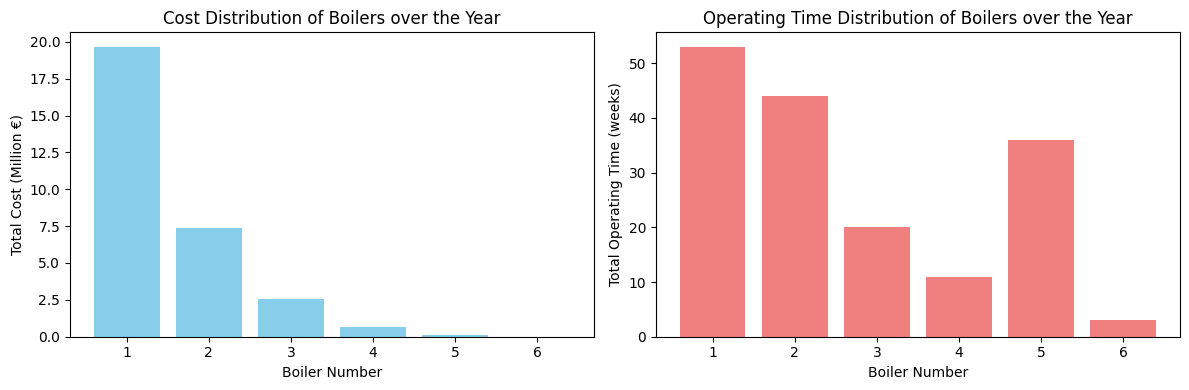

In [56]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot cost distribution on the first subplot
axes[0].bar(range(1, len(boiler_cost_over_year) + 1), boiler_cost_over_year, color='skyblue')
axes[0].set_xlabel("Boiler Number")
axes[0].set_ylabel("Total Cost (Million €)")
axes[0].set_title("Cost Distribution of Boilers over the Year")
axes[0].set_xticks(range(1, len(boiler_cost_over_year) + 1))

# Assuming reshaped_results_scaled contains weekly power output for each boiler
total_operating_time = (reshaped_results_scaled > 0).sum(axis=0)

# Plot operating time distribution on the second subplot
axes[1].bar(range(1, len(total_operating_time) + 1), total_operating_time, color='lightcoral')
axes[1].set_xlabel("Boiler Number")
axes[1].set_ylabel("Total Operating Time (weeks)")
axes[1].set_title("Operating Time Distribution of Boilers over the Year")
axes[1].set_xticks(range(1, len(total_operating_time) + 1))

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [57]:
%%capture
%reset -f
!pip install --upgrade pandas
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
from google.colab import drive
drive.mount('/content/drive')
import os
google_drive_root = '/content/drive/MyDrive'
assignment_loc = '/Novia/Industrial_AI/Assignment1'
os.chdir(google_drive_root + assignment_loc)
xlsx_file_name = 'PowerDemand_SpotPrices_Corrected.xlsx'
data = pd.read_excel(xlsx_file_name, engine='openpyxl')

In [58]:
data.head()

,Timestamp,Power demand (MW),Spot price (€/MWh),CORRECT Spot price (€/MWh),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2021-01-01 00:00:00.015,69.92,24.07,24.07,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00.010,68.92,24.95,24.95,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00.005,74.27,24.35,24.35,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00.000,80.68,23.98,23.98,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00.000,82.06,23.72,23.72,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Information on existing boilers
# Assuming data['Spot Price (€/MWh)'] contains the spot prices
spot_prices = data['CORRECT Spot price (€/MWh)'].values

boiler_data = {
    'Boiler Power max (MW)': [60, 45, 30, 25, 20, 40],
    'Power min (MW)': [12, 8, 5, 5, 0, 0],
    'Cost (€/MWh)': [50, 60, 100, 120, 160, spot_prices + 10]
}

boiler_df = pd.DataFrame(boiler_data)
boiler_df

,Boiler Power max (MW),Power min (MW),Cost (€/MWh)
0,60,12,50
1,45,8,60
2,30,5,100
3,25,5,120
4,20,0,160
5,40,0,"[34.07, 34.95, 34.35, 33.980000000000004, 33.7..."


In [60]:
# Compute the power demand and hours for each week
weekly_demand = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Power demand (MW)'].sum()
weekly_hours = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Timestamp'].count()

# Create a DataFrame with three columns
weekly_data = pd.DataFrame({'Week': weekly_demand.index.strftime('%Y-%m-%d'),
                            'Power Demand (MW)': weekly_demand.values,
                            'Hours': weekly_hours.values})


# Display the results
print(weekly_data)

# Display the number of weeks
print('\n')
print(f"Number of weeks:\n{len(weekly_demand)}")


          Week  Power Demand (MW)  Hours
0   2021-01-03            6215.93     72
1   2021-01-10           19463.08    168
2   2021-01-17           19666.59    168
3   2021-01-24           15377.93    168
4   2021-01-31           16720.59    168
5   2021-02-07           21266.55    168
6   2021-02-14           19826.70    168
7   2021-02-21           19553.90    168
8   2021-02-28           14873.44    168
9   2021-03-07           14677.00    168
10  2021-03-14           17132.02    168
11  2021-03-21           14305.70    168
12  2021-03-28           10970.72    167
13  2021-04-04           10357.67    168
14  2021-04-11           11534.90    168
15  2021-04-18            9091.82    168
16  2021-04-25            8970.06    168
17  2021-05-02           11147.37    168
18  2021-05-09            9432.78    168
19  2021-05-16            4761.67    168
20  2021-05-23            6699.08    168
21  2021-05-30            6630.92    168
22  2021-06-06            3639.51    168
23  2021-06-13  

In [61]:
%%capture

!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# initialize the output
results = []

for i in range(len(data["Power demand (MW)"])):

  # Define the model
  model = LpProblem("Power_Optimization", sense = LpMinimize)

  # Define the decision variables

  # Power of each boiler for which the cost is minimized
  P_B1 = LpVariable("P_B1", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][0], cat="Continuous")
  P_B2 = LpVariable("P_B2", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][1], cat="Continuous")
  P_B3 = LpVariable("P_B3", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][2], cat="Continuous")
  P_B4 = LpVariable("P_B4", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][3], cat="Continuous")
  P_B5 = LpVariable("P_B5", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][4], cat="Continuous")
  P_B6 = LpVariable("P_B6", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][5], cat="Continuous")


  # Binary variables to control on/off status of boilers
  B_B1 = LpVariable("B_B1", cat="Binary")
  B_B2 = LpVariable("B_B2", cat="Binary")
  B_B3 = LpVariable("B_B3", cat="Binary")
  B_B4 = LpVariable("B_B4", cat="Binary")
  B_B5 = LpVariable("B_B5", cat="Binary")
  B_B6 = LpVariable("B_B6", cat="Binary")

  # Objective function: Minimize total production cost (€/h)
  model += (P_B1 * boiler_df['Cost (€/MWh)'][0] +
           P_B2 * boiler_df['Cost (€/MWh)'][1] +
           P_B3 * boiler_df['Cost (€/MWh)'][2] +
           P_B4 * boiler_df['Cost (€/MWh)'][3] +
           P_B5 * boiler_df['Cost (€/MWh)'][4] +
           P_B6 * boiler_df['Cost (€/MWh)'][5][i])

  # Constraints: Meet hourly demand
  model += (P_B1 + P_B2 + P_B3 + P_B4 + P_B5 + P_B6) >= data["Power demand (MW)"][i], f"Demand_Constraint_Hour_{i}"

  # Constraints to link binary variables with power output
  model += P_B1 <= boiler_df['Boiler Power max (MW)'][0] * B_B1
  model += P_B1 >= boiler_df['Power min (MW)'][0] * B_B1
  model += P_B2 <= boiler_df['Boiler Power max (MW)'][1] * B_B2
  model += P_B2 >= boiler_df['Power min (MW)'][1] * B_B2
  model += P_B3 <= boiler_df['Boiler Power max (MW)'][2] * B_B3
  model += P_B3 >= boiler_df['Power min (MW)'][2] * B_B3
  model += P_B4 <= boiler_df['Boiler Power max (MW)'][3] * B_B4
  model += P_B4 >= boiler_df['Power min (MW)'][3] * B_B4
  model += P_B5 <= boiler_df['Boiler Power max (MW)'][4] * B_B5
  model += P_B5 >= boiler_df['Power min (MW)'][4] * B_B5
  model += P_B6 <= boiler_df['Boiler Power max (MW)'][5] * B_B6
  model += P_B6 >= boiler_df['Power min (MW)'][5] * B_B6

  # Solve the problem
  model.solve()

  # Append the results to the list
  results.append([P_B1.varValue, P_B2.varValue, P_B3.varValue, P_B4.varValue, P_B5.varValue, P_B6.varValue])
  '''
  results.append([P_B1.varValue])
  results.append([P_B2.varValue])
  results.append([P_B3.varValue])
  results.append([P_B4.varValue])
  results.append([P_B5.varValue])
  results.append([P_B6.varValue])
  '''

# Convert the list to a NumPy array for easier manipulation
results_array = np.array(results)

In [62]:
%%capture
# compute the mean value per week for each boiler in results_array

# Calculate the mean value per week for each boiler
weekly_means = []
for i in range(results_array.shape[1]):  # Iterate through each boiler
    boiler_power = results_array[:, i]
    # Reshape the hourly data into weekly data using weekly_hours
    weekly_boiler_power = []
    start_index = 0
    for hours_in_week in weekly_hours:
        end_index = start_index + hours_in_week
        weekly_boiler_power.append(boiler_power[start_index:end_index])
        start_index = end_index

    # Calculate mean of the power output in each week for each boiler
    # The if statement checks if weekly_boiler_power[j] is empty
    weekly_boiler_mean = np.array([np.mean(week) if week.size else 0 for week in weekly_boiler_power])
    weekly_means.append(weekly_boiler_mean)

# Create a DataFrame to store the weekly means for each boiler
weekly_means_df = pd.DataFrame(weekly_means).T
weekly_means_df.columns = [f'Boiler {i+1}' for i in range(results_array.shape[1])]
weekly_means_df.index = weekly_data.index

# Now weekly_means_df contains the mean power output per week for each boiler
weekly_means_df

In [63]:
%%capture
# reshape weekly_means_df to meet the format of results_array

# Reshape weekly_means_df to a single column
results_array = weekly_means_df.values.reshape(-1, 1)

# Create a new DataFrame with the reshaped array
reshaped_df = pd.DataFrame(results_array, columns=['results_array'])

# Display or further process the reshaped DataFrame
reshaped_df

results_array = reshaped_df.values

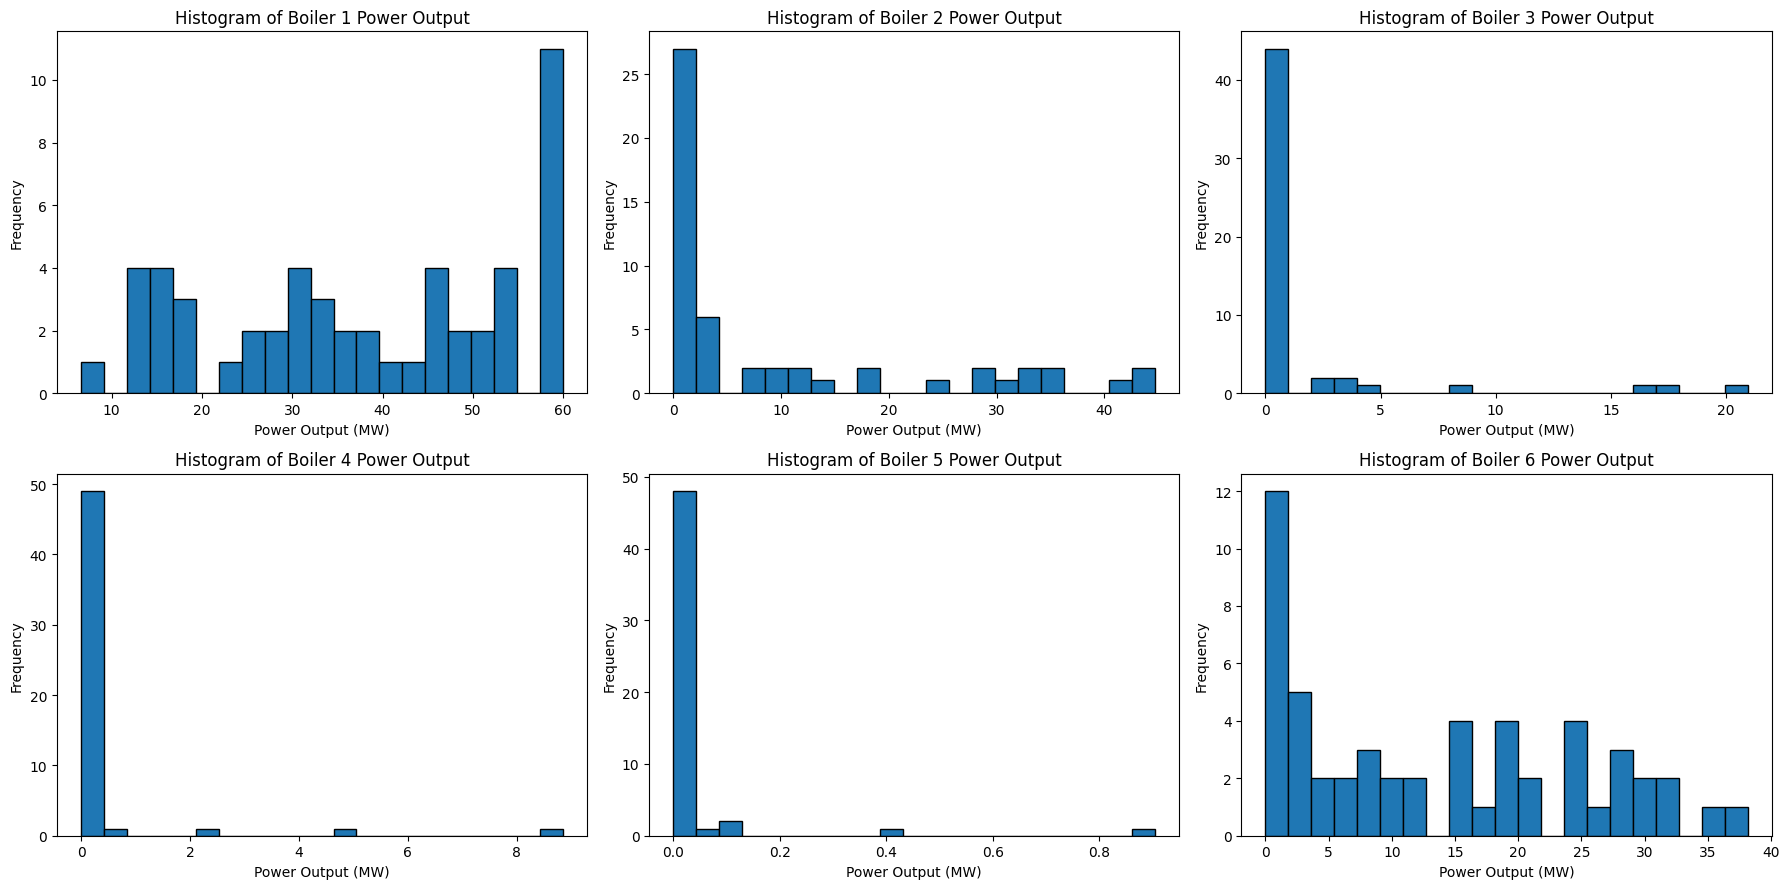

In [64]:
# Operational power of each boiler per week

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a histogram for each boiler in a separate subplot
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[i]  # Get the current subplot axis
    ax.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=21, edgecolor='black')
    ax.set_title(f'Histogram of Boiler {i+1} Power Output')
    ax.set_xlabel('Power Output (MW)')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

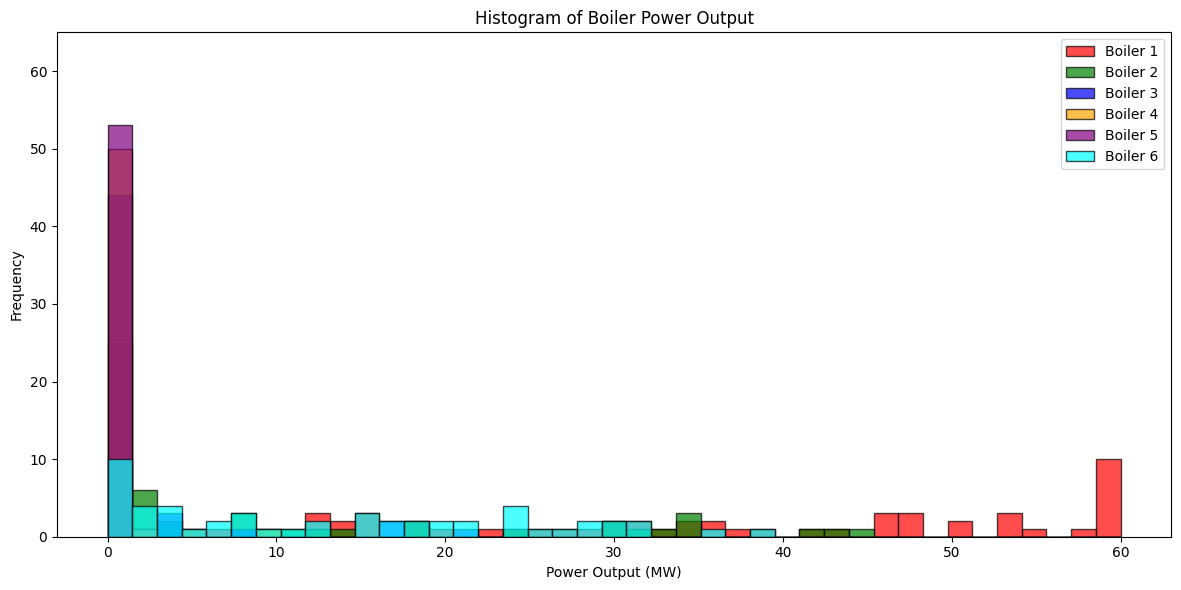

In [65]:
# Colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Create a single plot
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Define a common bins for all histograms
all_boiler_data = results_array[:, 0]  # Combine all boiler data for determining the bins
num_bins = 41
_, bins, _ = plt.hist(all_boiler_data, bins=num_bins, edgecolor='black', alpha=0) # Get common bins for all boilers

# Plot the data for each boiler on the same plot using shared bins
for i in range(boiler_df['Boiler Power max (MW)'].size):
    plt.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=bins, edgecolor='black', alpha=0.7, label=f'Boiler {i+1}', color=colors[i])

plt.title('Histogram of Boiler Power Output')
plt.xlabel('Power Output (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(0, 65)
plt.show()

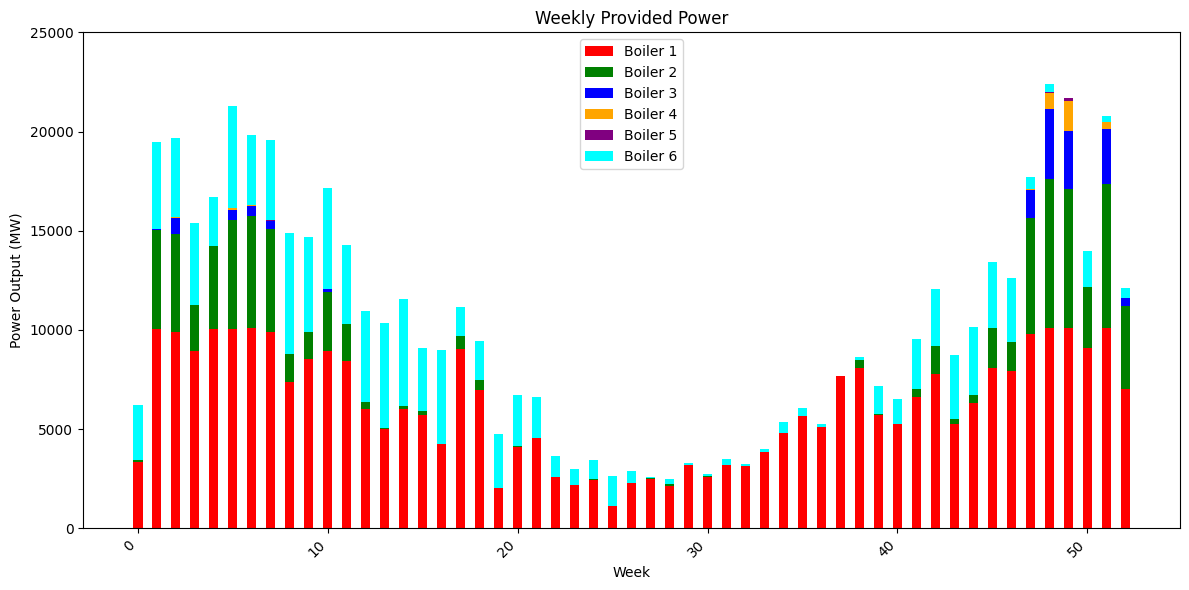

In [66]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Sum the elements of each row (week) to get a vector of 52 elements
reshaped_results_scaled = reshaped_results.astype(float) * weekly_hours.values[:, np.newaxis].astype(float)    # Delete the .astype(float)
weekly_sums = np.sum(reshaped_results_scaled, axis=1)

# Plot each boiler's power output over time, stacking them
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_scaled[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i],
           bottom=np.sum(reshaped_results_scaled[:, :i], axis=1))  # Stack bars

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Power Output (MW)')
ax.set_title('Weekly Provided Power')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 25000)
plt.show()

At first sight it might look strange to see boiler 3 on all that time. In the Weekly analysis boiler 6 was completely replacing boiler 3, so why do we see it here now?\
To figure out the reason, let's have a look at the energy spot price in the excel file. Let's focus on a region in which boiler 3 might be on.\
The spot price per hour is really high (with peaks of 144 euros / MW hour and probaly even higher). This makes the electric boiler more expensive than the gas boiler 3.\
This couldn't emerge from the weekly optimization analysis, where the power demand per hour was summed and the optimization performed over the total weekly power.

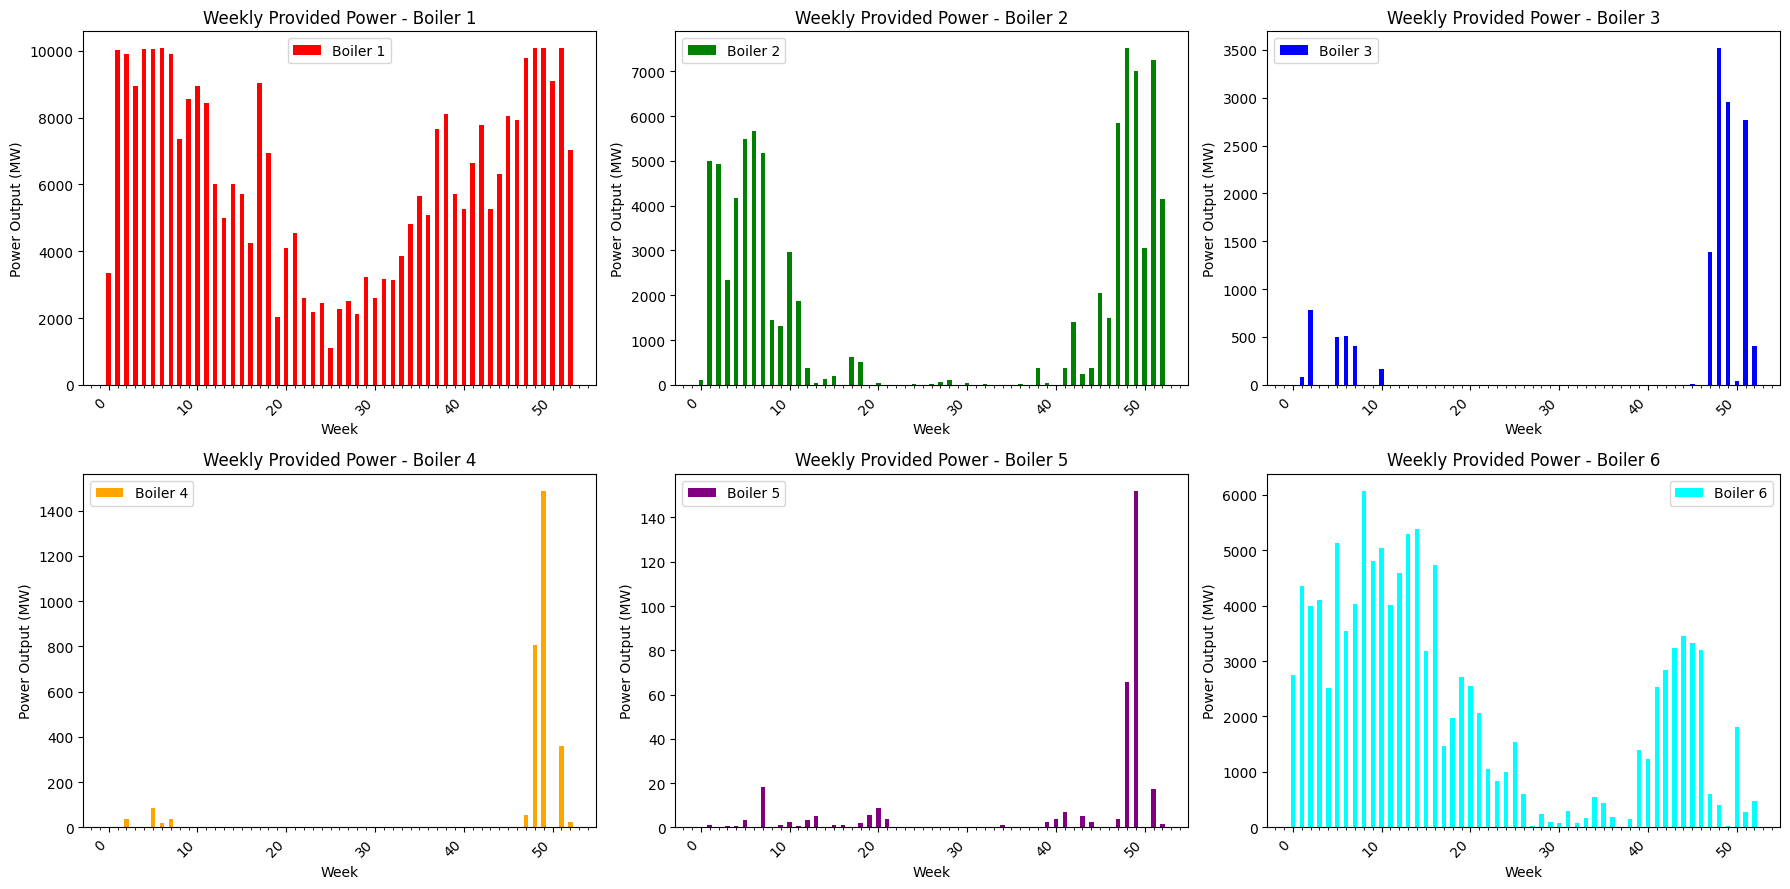

In [67]:
import matplotlib.ticker as ticker

# Create subplots (2 rows, 3 columns to accommodate 6 boilers)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each boiler and plot its data on a separate subplot
for ii in range(boiler_df['Boiler Power max (MW)'].size):
    ax = axes[ii]  # Get the current subplot axis

    ax.bar(weeks, reshaped_results_scaled[:, ii], width=0.5,
           label=f'Boiler {ii+1}', color=colors[ii])

    # Customize the subplot
    ax.set_xlabel('Week')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(f'Weekly Provided Power - Boiler {ii+1}')
    ax.legend()

    # Set x-axis ticks (same as before)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}' if x % 10 == 0 else ''))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlapping and display the subplots
plt.tight_layout()
plt.show()

In [68]:
boiler_power_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_power_over_year[i] = (reshaped_results_scaled[:, i]).sum()

df_boiler_power = pd.DataFrame(boiler_power_over_year, columns=['Annual Power Output (MW)'])
df_boiler_power.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_provided_power to the DataFrame
annual_provided_power = reshaped_results_scaled.sum()
df_boiler_power.loc['Annual provided power'] = annual_provided_power  # Adding a new row with the name 'Total Provided'

# Calculate and add annual_requested_power to the DataFrame
annual_requested_power = weekly_data['Power Demand (MW)'].sum()
df_boiler_power.loc['Annual requested power'] = annual_requested_power  # Adding a new row with the name 'Total Requested'

# Calculate and add surplus/deficit to the DataFrame
surplus_deficit = annual_provided_power - annual_requested_power
df_boiler_power.loc['Surplus/Deficit'] = surplus_deficit  # Adding a new row for surplus/deficit

# Calculate the percentage for each boiler
df_boiler_power['Power output as percentage of Annual provided power'] = (df_boiler_power['Annual Power Output (MW)'] / annual_provided_power) * 100

# Filter out rows that are not boilers
boiler_rows = df_boiler_power.index.isin(['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6'])
df_boiler_power_filtered = df_boiler_power[boiler_rows]

# Format the percentage column
df_boiler_power['Power output as percentage of Annual provided power'] = df_boiler_power['Power output as percentage of Annual provided power'].map('{:.2f}%'.format)

df_boiler_power  # Displaying the DataFrame


,Annual Power Output (MW),Power output as percentage of Annual provided power
Boiler 1,331020.68,60.40%
Boiler 2,83921.26,15.31%
Boiler 3,13516.27,2.47%
Boiler 4,2911.39,0.53%
Boiler 5,321.00,0.06%
Boiler 6,116321.43,21.23%
Annual provided power,548012.03,100.00%
Annual requested power,547922.54,99.98%
Surplus/Deficit,89.49,0.02%


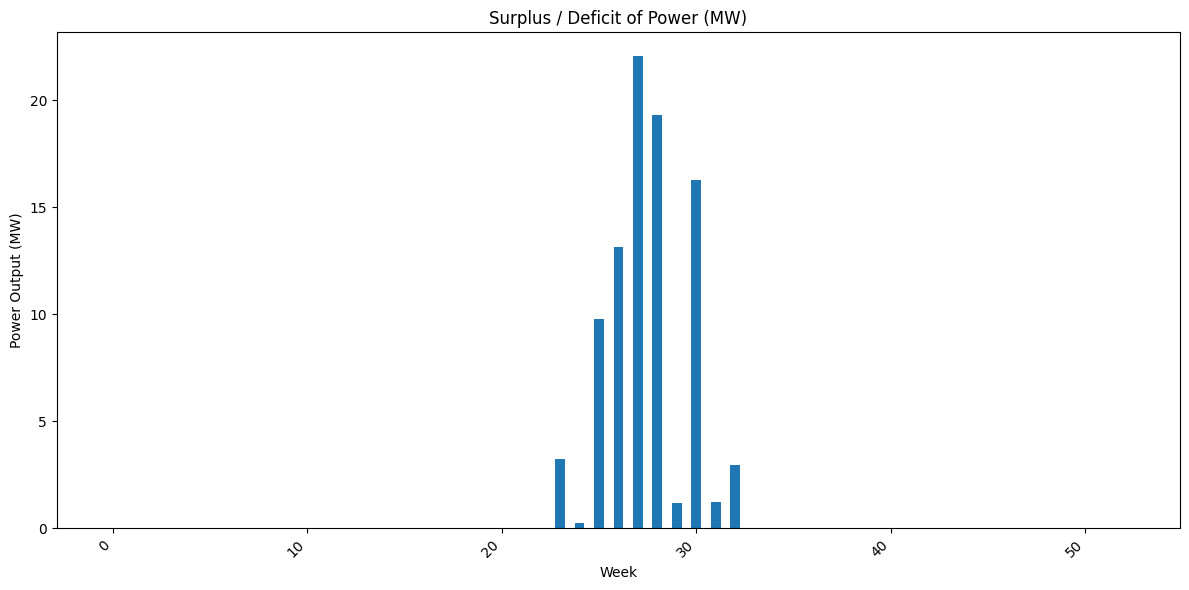

In [69]:
# Copmpute the error
error = weekly_sums - weekly_demand.values

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, error, width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Surplus / Deficit of Power (MW)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


/tmp/ipython-input-3276829451.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]


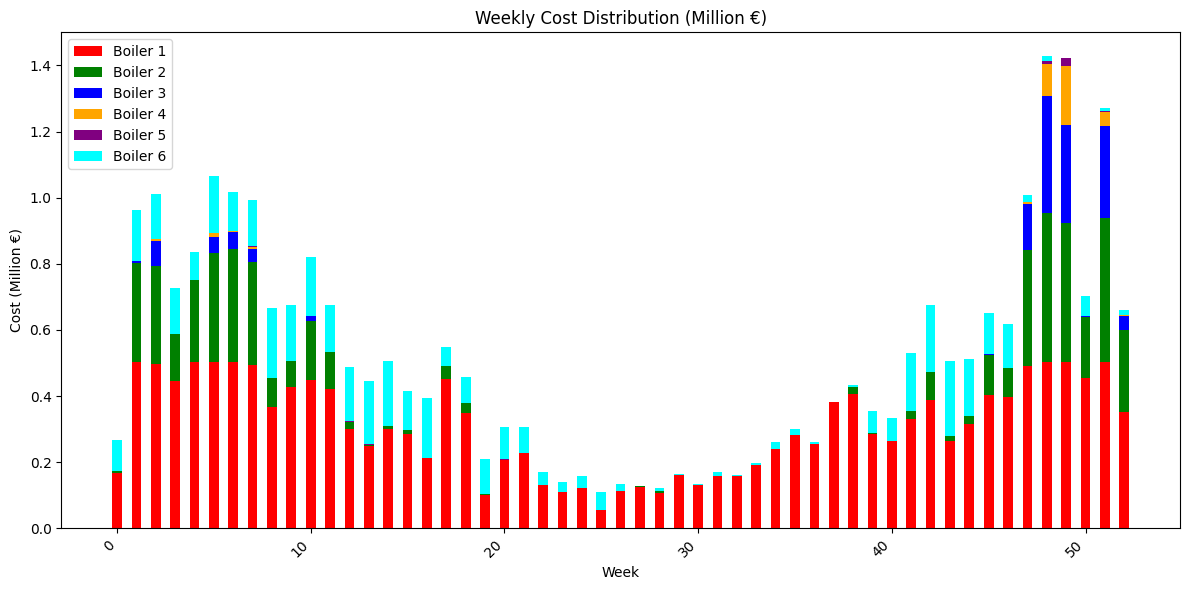

In [70]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# --- Adapted section to handle electric boiler's cost ---
# Initialize an array to store the cost for each boiler each week
reshaped_results_cost = np.zeros_like(reshaped_results, dtype=float)

# Iterate through weeks and boilers to calculate costs
for week_index in range(len(weekly_demand)):
    for boiler_index in range(boiler_df['Boiler Power max (MW)'].size):
        # For the electric boiler, use spot prices for that week
        if boiler_index == boiler_df['Boiler Power max (MW)'].size - 1:  # Assuming electric boiler is the last one
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index][week_index]  # Get spot price for the week
        else:
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index]  # Use fixed cost for other boilers

        # Calculate and store the cost for the boiler that week
        reshaped_results_cost[week_index, boiler_index] = (
            reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]
        )

# --- End of adapted section ---

# Scale the weekly cost data to millions of euros
reshaped_results_cost_millions = reshaped_results_cost / 1000000

# Calculate weekly cost sums
weekly_cost_sums = np.sum(reshaped_results_cost_millions, axis=1)

# Plot each boiler's cost over time, stacking them
bottom = np.zeros(len(weekly_demand))  # Initialize bottom for stacking
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_cost_millions[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i], bottom=bottom)
    bottom += reshaped_results_cost_millions[:, i]  # Update bottom for next boiler's stack

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Cost (Million €)')  # Update y-axis label
ax.set_title('Weekly Cost Distribution (Million €)')  # Update title
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 1.5)  # Update ylim to reflect million € scale
plt.show()

In [71]:
boiler_cost_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_cost_over_year[i] = (reshaped_results_cost_millions[:, i]).sum() # Use reshaped_results_cost_millions here

df_boiler_cost = pd.DataFrame(boiler_cost_over_year, columns=['Annual Cost (Million €)']) # Changed column name
df_boiler_cost.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5', 'Boiler 6']

# Calculate and add annual_total_cost to the DataFrame
saving_list = []
annual_total_cost = reshaped_results_cost_millions.sum() # Use reshaped_results_cost_millions here
saving_list.append(annual_total_cost)
df_boiler_cost.loc['Annual total cost'] = annual_total_cost  # Adding a new row with the name 'Annual total cost'

# Calculate the percentage for each boiler (based on cost)
df_boiler_cost['Cost as percentage of Annual total cost'] = (df_boiler_cost['Annual Cost (Million €)'] / annual_total_cost) * 100 # Changed column name

# Format the percentage column
df_boiler_cost['Cost as percentage of Annual total cost'] = df_boiler_cost['Cost as percentage of Annual total cost'].map('{:.2f}%'.format)

df_boiler_cost  # Displaying the DataFrame

,Annual Cost (Million €),Cost as percentage of Annual total cost
Boiler 1,16.551034,59.31%
Boiler 2,5.035276,18.04%
Boiler 3,1.351627,4.84%
Boiler 4,0.349367,1.25%
Boiler 5,0.051360,0.18%
Boiler 6,4.566397,16.36%
Annual total cost,27.905061,100.00%


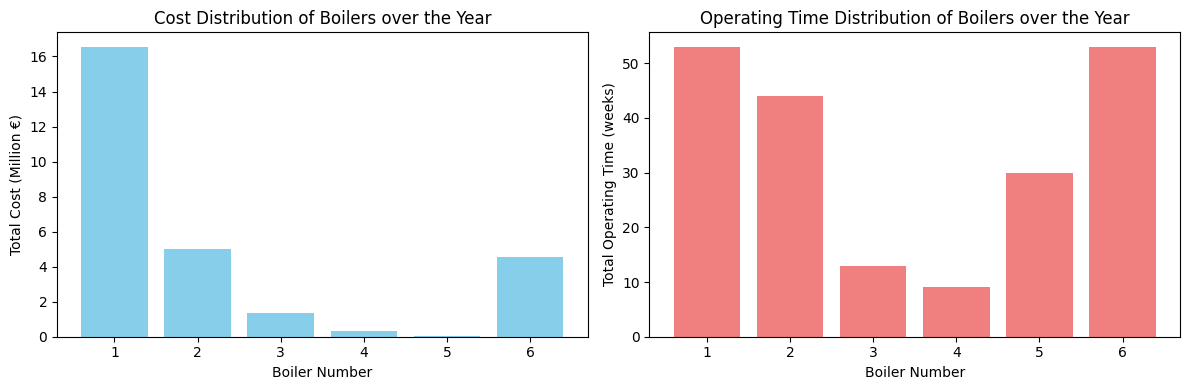

In [72]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot cost distribution on the first subplot
axes[0].bar(range(1, len(boiler_cost_over_year) + 1), boiler_cost_over_year, color='skyblue')
axes[0].set_xlabel("Boiler Number")
axes[0].set_ylabel("Total Cost (Million €)")
axes[0].set_title("Cost Distribution of Boilers over the Year")
axes[0].set_xticks(range(1, len(boiler_cost_over_year) + 1))

# Assuming reshaped_results_scaled contains weekly power output for each boiler
total_operating_time = (reshaped_results_scaled > 0).sum(axis=0)

# Plot operating time distribution on the second subplot
axes[1].bar(range(1, len(total_operating_time) + 1), total_operating_time, color='lightcoral')
axes[1].set_xlabel("Boiler Number")
axes[1].set_ylabel("Total Operating Time (weeks)")
axes[1].set_title("Operating Time Distribution of Boilers over the Year")
axes[1].set_xticks(range(1, len(total_operating_time) + 1))

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [73]:
%%capture
%reset -f
!pip install --upgrade pandas
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
from google.colab import drive
drive.mount('/content/drive')
import os
google_drive_root = '/content/drive/MyDrive'
assignment_loc = '/Novia/Industrial_AI/Assignment1'
os.chdir(google_drive_root + assignment_loc)
xlsx_file_name = 'PowerDemand_SpotPrices_Corrected.xlsx'
data = pd.read_excel(xlsx_file_name, engine='openpyxl')

In [74]:
data.head()

,Timestamp,Power demand (MW),Spot price (€/MWh),CORRECT Spot price (€/MWh),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2021-01-01 00:00:00.015,69.92,24.07,24.07,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00.010,68.92,24.95,24.95,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00.005,74.27,24.35,24.35,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00.000,80.68,23.98,23.98,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00.000,82.06,23.72,23.72,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Information on existing boilers
# Assuming data['Spot Price (€/MWh)'] contains the spot prices
spot_prices = data['CORRECT Spot price (€/MWh)'].values

boiler_data = {
    'Boiler Power max (MW)': [60, 45, 30, 25, 40],
    'Power min (MW)': [12, 8, 5, 5, 0],
    'Cost (€/MWh)': [50, 60, 100, 120, spot_prices + 10]
}

boiler_df = pd.DataFrame(boiler_data)
boiler_df

,Boiler Power max (MW),Power min (MW),Cost (€/MWh)
0,60,12,50
1,45,8,60
2,30,5,100
3,25,5,120
4,40,0,"[34.07, 34.95, 34.35, 33.980000000000004, 33.7..."


In [76]:
# Compute the power demand and hours for each week
weekly_demand = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Power demand (MW)'].sum()
weekly_hours = data.groupby(pd.Grouper(key='Timestamp', freq='W'))['Timestamp'].count()

# Create a DataFrame with three columns
weekly_data = pd.DataFrame({'Week': weekly_demand.index.strftime('%Y-%m-%d'),
                            'Power Demand (MW)': weekly_demand.values,
                            'Hours': weekly_hours.values})


# Display the results
print(weekly_data)

# Display the number of weeks
print('\n')
print(f"Number of weeks:\n{len(weekly_demand)}")


          Week  Power Demand (MW)  Hours
0   2021-01-03            6215.93     72
1   2021-01-10           19463.08    168
2   2021-01-17           19666.59    168
3   2021-01-24           15377.93    168
4   2021-01-31           16720.59    168
5   2021-02-07           21266.55    168
6   2021-02-14           19826.70    168
7   2021-02-21           19553.90    168
8   2021-02-28           14873.44    168
9   2021-03-07           14677.00    168
10  2021-03-14           17132.02    168
11  2021-03-21           14305.70    168
12  2021-03-28           10970.72    167
13  2021-04-04           10357.67    168
14  2021-04-11           11534.90    168
15  2021-04-18            9091.82    168
16  2021-04-25            8970.06    168
17  2021-05-02           11147.37    168
18  2021-05-09            9432.78    168
19  2021-05-16            4761.67    168
20  2021-05-23            6699.08    168
21  2021-05-30            6630.92    168
22  2021-06-06            3639.51    168
23  2021-06-13  

In [77]:
%%capture

!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# initialize the output
results = []

for i in range(len(data["Power demand (MW)"])):

  # Define the model
  model = LpProblem("Power_Optimization", sense = LpMinimize)

  # Define the decision variables

  # Power of each boiler for which the cost is minimized
  P_B1 = LpVariable("P_B1", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][0], cat="Continuous")
  P_B2 = LpVariable("P_B2", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][1], cat="Continuous")
  P_B3 = LpVariable("P_B3", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][2], cat="Continuous")
  P_B4 = LpVariable("P_B4", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][3], cat="Continuous")
  P_B5 = LpVariable("P_B5", lowBound=0, upBound=boiler_df['Boiler Power max (MW)'][4], cat="Continuous")


  # Binary variables to control on/off status of boilers
  B_B1 = LpVariable("B_B1", cat="Binary")
  B_B2 = LpVariable("B_B2", cat="Binary")
  B_B3 = LpVariable("B_B3", cat="Binary")
  B_B4 = LpVariable("B_B4", cat="Binary")
  B_B5 = LpVariable("B_B5", cat="Binary")

  # Objective function: Minimize total production cost (€/h)
  model += (P_B1 * boiler_df['Cost (€/MWh)'][0] +
           P_B2 * boiler_df['Cost (€/MWh)'][1] +
           P_B3 * boiler_df['Cost (€/MWh)'][2] +
           P_B4 * boiler_df['Cost (€/MWh)'][3] +
           P_B5 * boiler_df['Cost (€/MWh)'][4][i])

  # Constraints: Meet hourly demand
  model += (P_B1 + P_B2 + P_B3 + P_B4 + P_B5) >= data["Power demand (MW)"][i], f"Demand_Constraint_Hour_{i}"

  # Constraints to link binary variables with power output
  model += P_B1 <= boiler_df['Boiler Power max (MW)'][0] * B_B1
  model += P_B1 >= boiler_df['Power min (MW)'][0] * B_B1
  model += P_B2 <= boiler_df['Boiler Power max (MW)'][1] * B_B2
  model += P_B2 >= boiler_df['Power min (MW)'][1] * B_B2
  model += P_B3 <= boiler_df['Boiler Power max (MW)'][2] * B_B3
  model += P_B3 >= boiler_df['Power min (MW)'][2] * B_B3
  model += P_B4 <= boiler_df['Boiler Power max (MW)'][3] * B_B4
  model += P_B4 >= boiler_df['Power min (MW)'][3] * B_B4
  model += P_B5 <= boiler_df['Boiler Power max (MW)'][4] * B_B5
  model += P_B5 >= boiler_df['Power min (MW)'][4] * B_B5

  # Solve the problem
  model.solve()

  # Append the results to the list
  results.append([P_B1.varValue, P_B2.varValue, P_B3.varValue, P_B4.varValue, P_B5.varValue])
  '''
  results.append([P_B1.varValue])
  results.append([P_B2.varValue])
  results.append([P_B3.varValue])
  results.append([P_B4.varValue])
  results.append([P_B5.varValue])
  '''

# Convert the list to a NumPy array for easier manipulation
results_array = np.array(results)

In [78]:
%%capture
# compute the mean value per week for each boiler in results_array

# Calculate the mean value per week for each boiler
weekly_means = []
for i in range(results_array.shape[1]):  # Iterate through each boiler
    boiler_power = results_array[:, i]
    # Reshape the hourly data into weekly data using weekly_hours
    weekly_boiler_power = []
    start_index = 0
    for hours_in_week in weekly_hours:
        end_index = start_index + hours_in_week
        weekly_boiler_power.append(boiler_power[start_index:end_index])
        start_index = end_index

    # Calculate mean of the power output in each week for each boiler
    # The if statement checks if weekly_boiler_power[j] is empty
    weekly_boiler_mean = np.array([np.mean(week) if week.size else 0 for week in weekly_boiler_power])
    weekly_means.append(weekly_boiler_mean)

# Create a DataFrame to store the weekly means for each boiler
weekly_means_df = pd.DataFrame(weekly_means).T
weekly_means_df.columns = [f'Boiler {i+1}' for i in range(results_array.shape[1])]
weekly_means_df.index = weekly_data.index

# Now weekly_means_df contains the mean power output per week for each boiler
weekly_means_df

In [79]:
%%capture
# reshape weekly_means_df to meet the format of results_array

# Reshape weekly_means_df to a single column
results_array = weekly_means_df.values.reshape(-1, 1)

# Create a new DataFrame with the reshaped array
reshaped_df = pd.DataFrame(results_array, columns=['results_array'])

# Display or further process the reshaped DataFrame
reshaped_df

results_array = reshaped_df.values

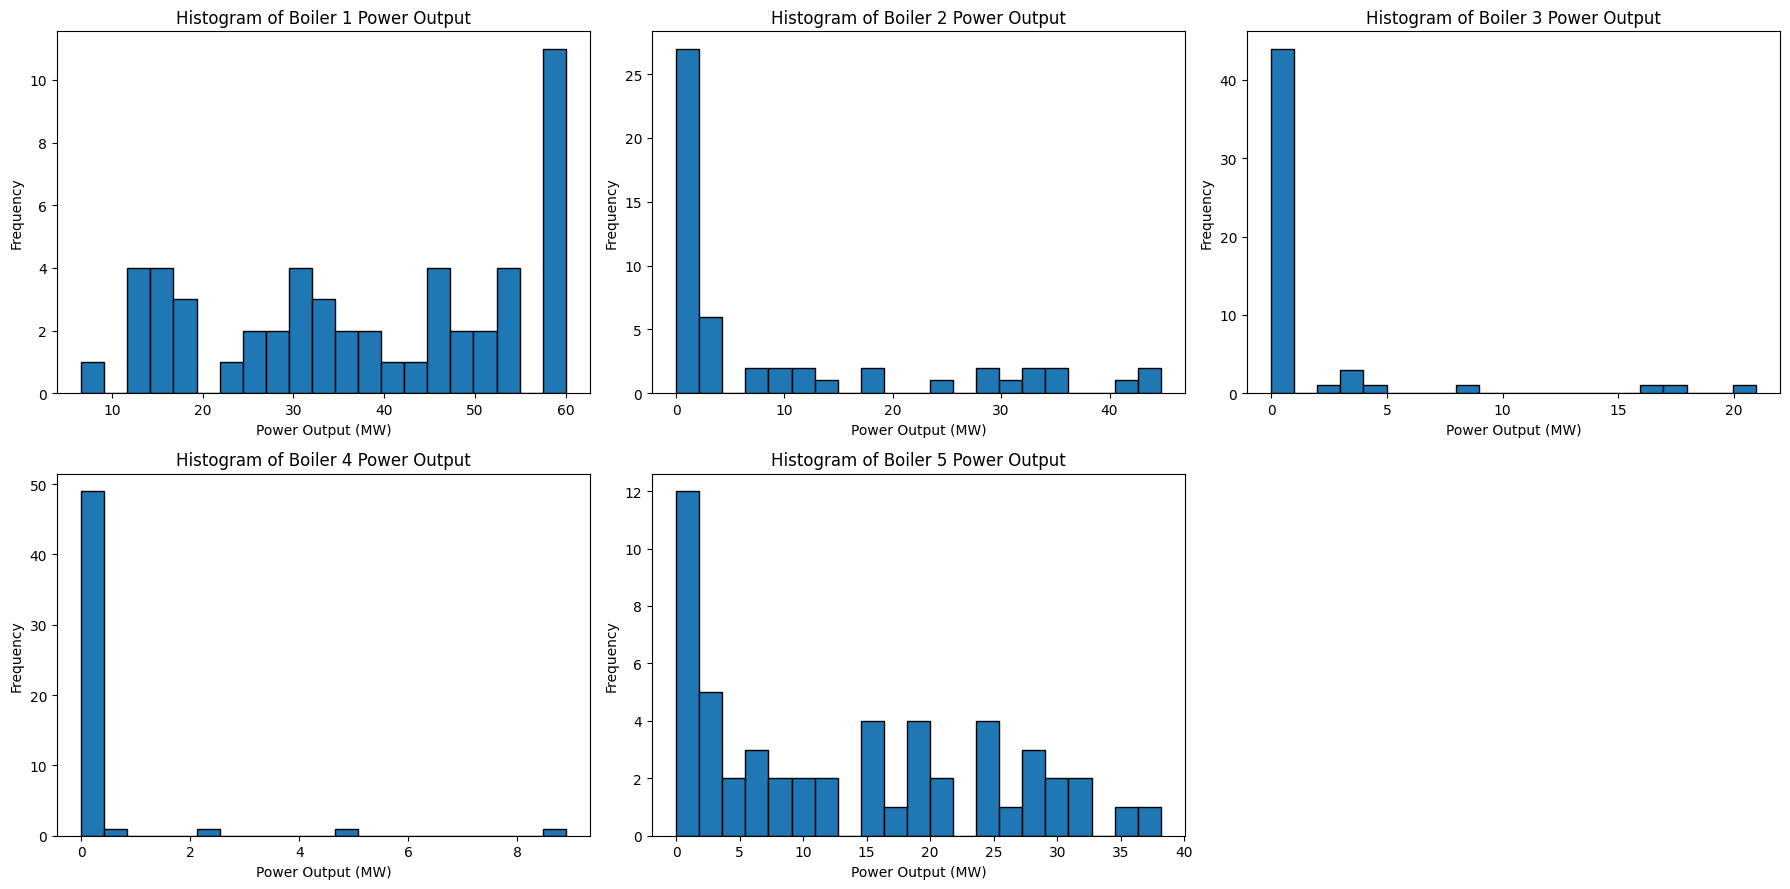

In [80]:
# Operational power of each boiler per week

# Create subplots with the correct number of boilers
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a histogram for each boiler in a separate subplot
num_boilers = boiler_df['Boiler Power max (MW)'].size  # Get the number of boilers
for i in range(num_boilers):
    ax = axes[i]  # Get the current subplot axis
    ax.hist(results_array[i::num_boilers, 0], bins=21, edgecolor='black')
    ax.set_title(f'Histogram of Boiler {i+1} Power Output')
    ax.set_xlabel('Power Output (MW)')
    ax.set_ylabel('Frequency')

# Hide the extra subplots if there are fewer than 6 boilers
num_subplots = axes.size
if num_boilers < num_subplots:
    for i in range(num_boilers, num_subplots):
        axes[i].set_visible(False)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

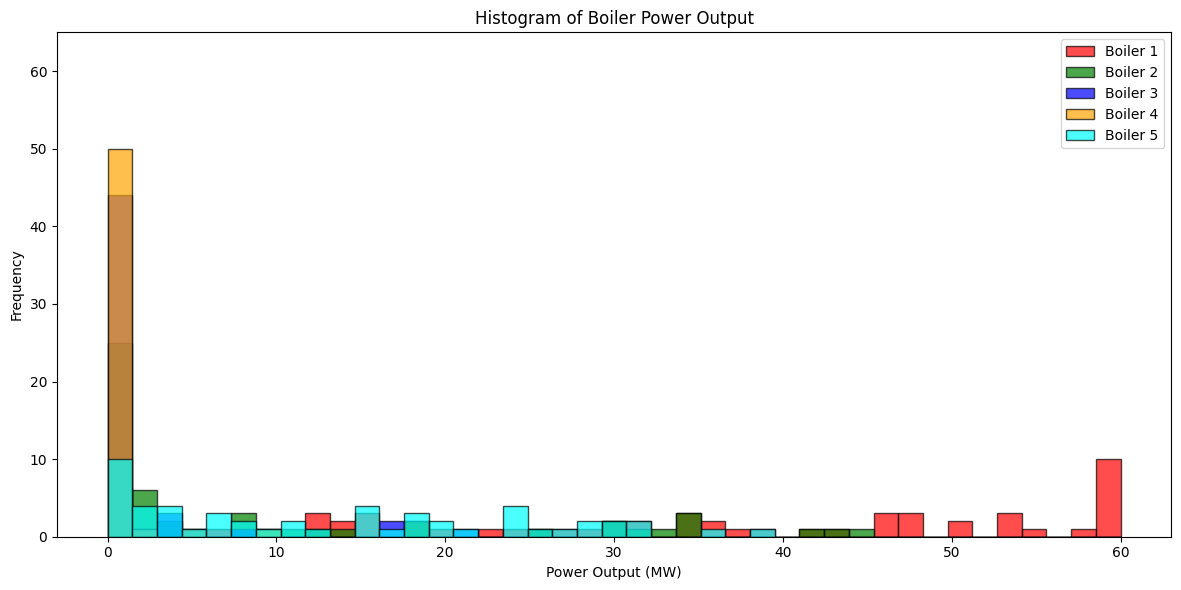

In [81]:
# Colors for each boiler
colors = ['red', 'green', 'blue', 'orange', 'cyan']

# Create a single plot
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Define a common bins for all histograms
all_boiler_data = results_array[:, 0]  # Combine all boiler data for determining the bins
num_bins = 41
_, bins, _ = plt.hist(all_boiler_data, bins=num_bins, edgecolor='black', alpha=0) # Get common bins for all boilers

# Plot the data for each boiler on the same plot using shared bins
for i in range(boiler_df['Boiler Power max (MW)'].size):
    plt.hist(results_array[i::boiler_df['Boiler Power max (MW)'].size, 0], bins=bins, edgecolor='black', alpha=0.7, label=f'Boiler {i+1}', color=colors[i])

plt.title('Histogram of Boiler Power Output')
plt.xlabel('Power Output (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(0, 65)
plt.show()

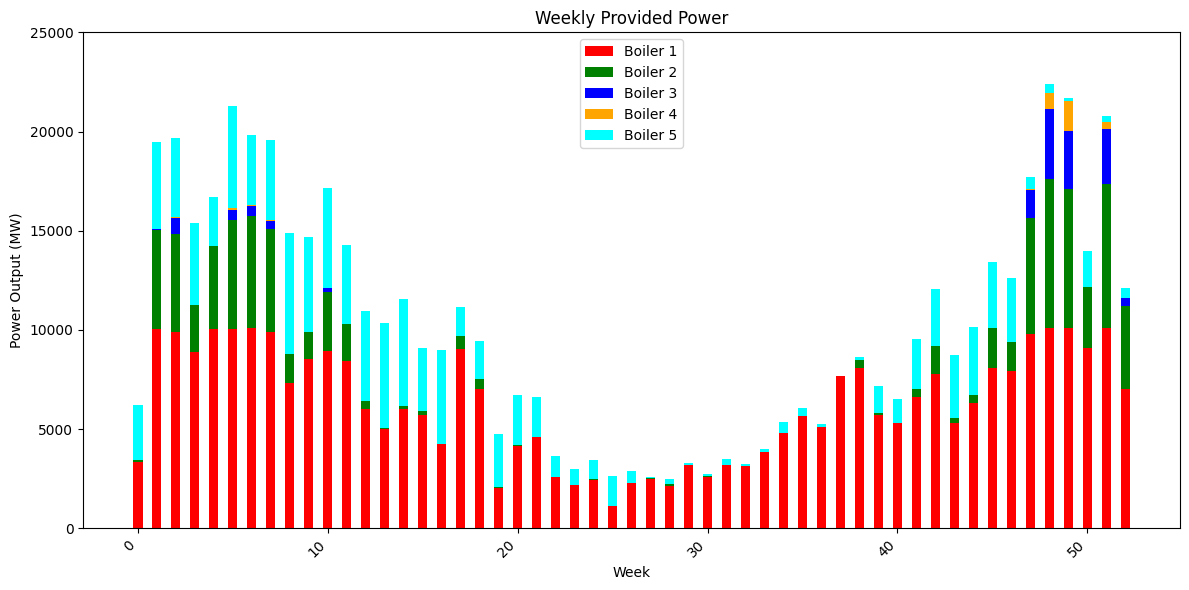

In [82]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# Sum the elements of each row (week) to get a vector of 52 elements
reshaped_results_scaled = reshaped_results.astype(float) * weekly_hours.values[:, np.newaxis].astype(float)    # Delete the .astype(float)
weekly_sums = np.sum(reshaped_results_scaled, axis=1)

# Plot each boiler's power output over time, stacking them
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_scaled[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i],
           bottom=np.sum(reshaped_results_scaled[:, :i], axis=1))  # Stack bars

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Power Output (MW)')
ax.set_title('Weekly Provided Power')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 25000)
plt.show()

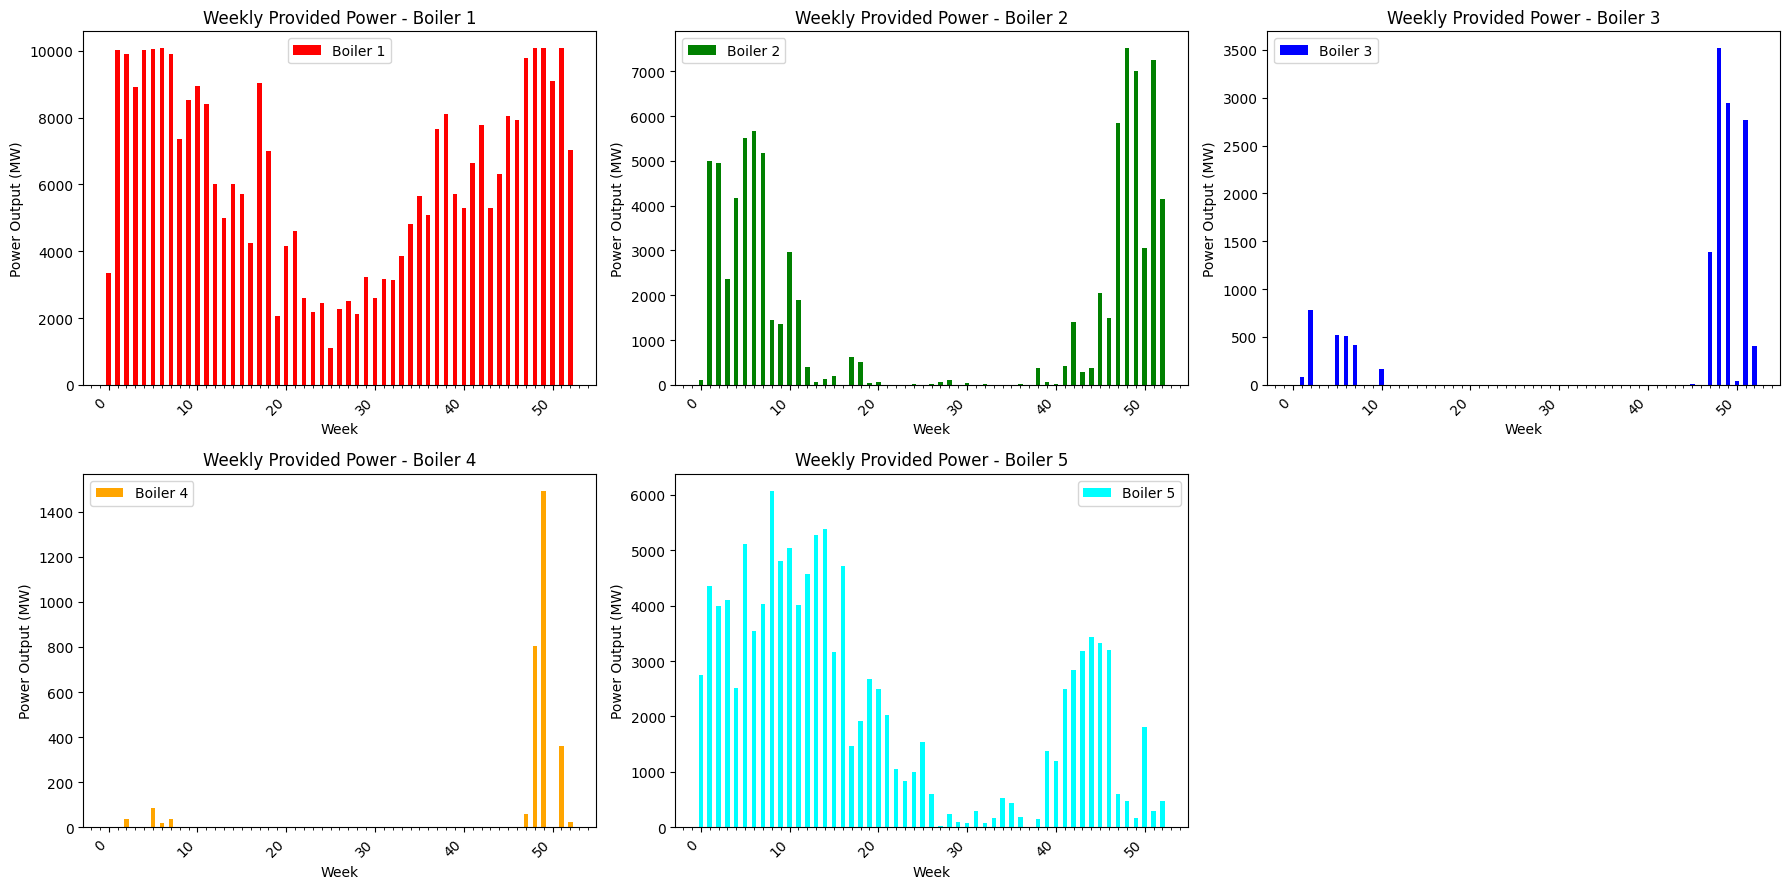

In [83]:
import matplotlib.ticker as ticker

# Create subplots, adjusted for 5 boilers (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each boiler and plot its data on a separate subplot
num_boilers = boiler_df['Boiler Power max (MW)'].size  # Get the number of boilers
for ii in range(num_boilers):
    ax = axes[ii]  # Get the current subplot axis

    ax.bar(weeks, reshaped_results_scaled[:, ii], width=0.5,
           label=f'Boiler {ii+1}', color=colors[ii])

    # Customize the subplot
    ax.set_xlabel('Week')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(f'Weekly Provided Power - Boiler {ii+1}')
    ax.legend()

    # Set x-axis ticks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}' if x % 10 == 0 else ''))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Hide the extra subplot (if there are fewer than 6 boilers)
num_subplots = axes.size
if num_boilers < num_subplots:
    for i in range(num_boilers, num_subplots):
        axes[i].set_visible(False)  # Hide the extra subplot

# Adjust layout to prevent overlapping and display the subplots
plt.tight_layout()
plt.show()

In [84]:
boiler_power_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_power_over_year[i] = (reshaped_results_scaled[:, i]).sum()

df_boiler_power = pd.DataFrame(boiler_power_over_year, columns=['Annual Power Output (MW)'])
df_boiler_power.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5']

# Calculate and add annual_provided_power to the DataFrame
annual_provided_power = reshaped_results_scaled.sum()
df_boiler_power.loc['Annual provided power'] = annual_provided_power  # Adding a new row with the name 'Total Provided'

# Calculate and add annual_requested_power to the DataFrame
annual_requested_power = weekly_data['Power Demand (MW)'].sum()
df_boiler_power.loc['Annual requested power'] = annual_requested_power  # Adding a new row with the name 'Total Requested'

# Calculate and add surplus/deficit to the DataFrame
surplus_deficit = annual_provided_power - annual_requested_power
df_boiler_power.loc['Surplus/Deficit'] = surplus_deficit  # Adding a new row for surplus/deficit

# Calculate the percentage for each boiler
df_boiler_power['Power output as percentage of Annual provided power'] = (df_boiler_power['Annual Power Output (MW)'] / annual_provided_power) * 100

# Filter out rows that are not boilers
boiler_rows = df_boiler_power.index.isin(['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5'])
df_boiler_power_filtered = df_boiler_power[boiler_rows]

# Format the percentage column
df_boiler_power['Power output as percentage of Annual provided power'] = df_boiler_power['Power output as percentage of Annual provided power'].map('{:.2f}%'.format)

df_boiler_power  # Displaying the DataFrame


,Annual Power Output (MW),Power output as percentage of Annual provided power
Boiler 1,331163.99,60.43%
Boiler 2,84258.67,15.38%
Boiler 3,13553.49,2.47%
Boiler 4,2921.39,0.53%
Boiler 5,116114.49,21.19%
Annual provided power,548012.03,100.00%
Annual requested power,547922.54,99.98%
Surplus/Deficit,89.49,0.02%


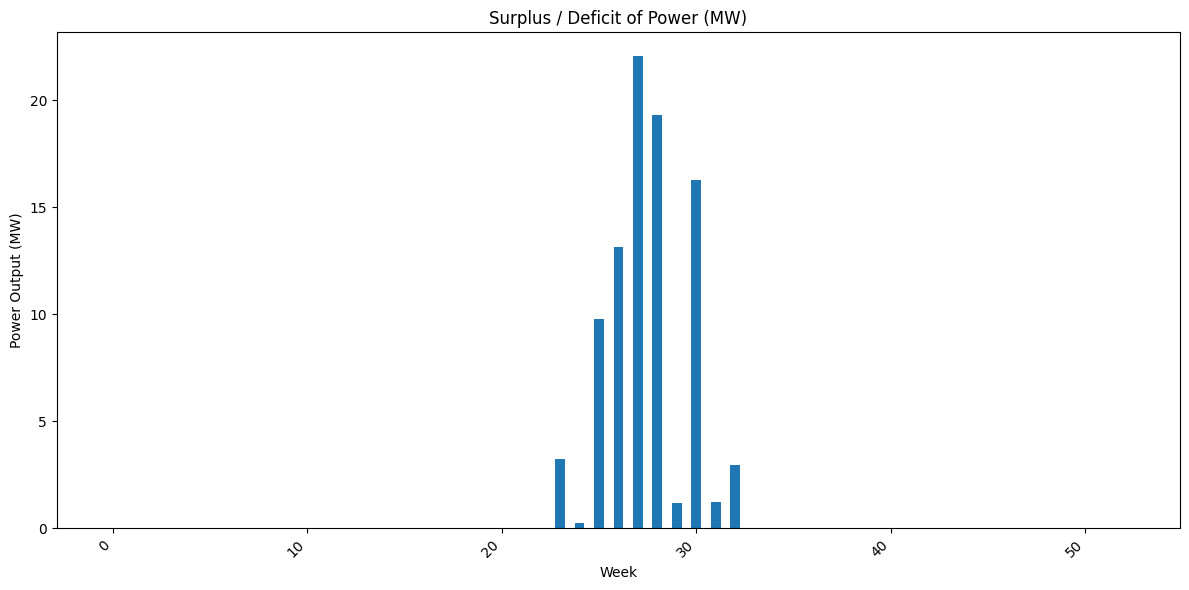

In [85]:
# Copmpute the error
error = weekly_sums - weekly_demand.values

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(weeks, error, width=0.5)  # Use bar plot for better visualization of weekly data

plt.xlabel('Week')
plt.ylabel('Power Output (MW)')
plt.title('Surplus / Deficit of Power (MW)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


/tmp/ipython-input-3276829451.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]


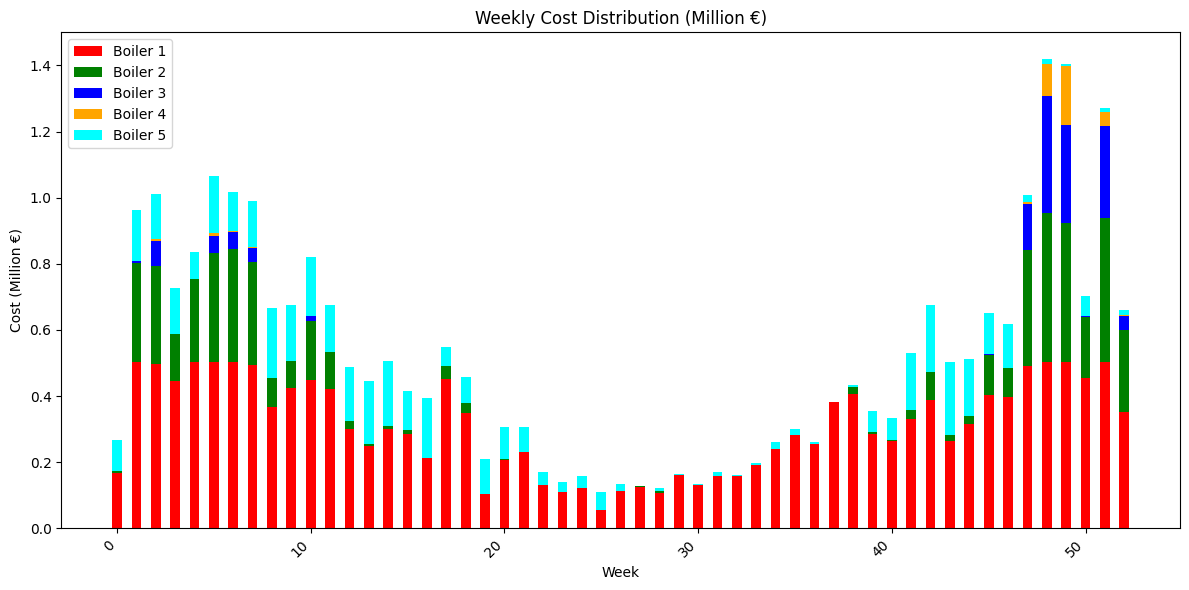

In [86]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Extract week numbers (assuming 'Week' column is a datetime index)
weeks = weekly_data.index  # or weekly_data['Week'] if it's not a datetime index

# Reshape the results array to have dimensions (num_weeks, num_boilers)
reshaped_results = results_array.reshape(len(weekly_demand), boiler_df['Boiler Power max (MW)'].size)

# --- Adapted section to handle electric boiler's cost ---
# Initialize an array to store the cost for each boiler each week
reshaped_results_cost = np.zeros_like(reshaped_results, dtype=float)

# Iterate through weeks and boilers to calculate costs
for week_index in range(len(weekly_demand)):
    for boiler_index in range(boiler_df['Boiler Power max (MW)'].size):
        # For the electric boiler, use spot prices for that week
        if boiler_index == boiler_df['Boiler Power max (MW)'].size - 1:  # Assuming electric boiler is the last one
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index][week_index]  # Get spot price for the week
        else:
            cost_per_mwh = boiler_df['Cost (€/MWh)'][boiler_index]  # Use fixed cost for other boilers

        # Calculate and store the cost for the boiler that week
        reshaped_results_cost[week_index, boiler_index] = (
            reshaped_results[week_index, boiler_index] * cost_per_mwh * weekly_hours[week_index]
        )

# --- End of adapted section ---

# Scale the weekly cost data to millions of euros
reshaped_results_cost_millions = reshaped_results_cost / 1000000

# Calculate weekly cost sums
weekly_cost_sums = np.sum(reshaped_results_cost_millions, axis=1)

# Plot each boiler's cost over time, stacking them
bottom = np.zeros(len(weekly_demand))  # Initialize bottom for stacking
for i in range(boiler_df['Boiler Power max (MW)'].size):
    ax.bar(weeks, reshaped_results_cost_millions[:, i], width=0.5,
           label=f'Boiler {i+1}', color=colors[i], bottom=bottom)
    bottom += reshaped_results_cost_millions[:, i]  # Update bottom for next boiler's stack

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Cost (Million €)')  # Update y-axis label
ax.set_title('Weekly Cost Distribution (Million €)')  # Update title
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0, 1.5)  # Update ylim to reflect million € scale
plt.show()

In [87]:
boiler_cost_over_year = np.zeros(boiler_df['Boiler Power max (MW)'].size)

for i in range(boiler_df['Boiler Power max (MW)'].size):
  boiler_cost_over_year[i] = (reshaped_results_cost_millions[:, i]).sum() # Use reshaped_results_cost_millions here

df_boiler_cost = pd.DataFrame(boiler_cost_over_year, columns=['Annual Cost (Million €)']) # Changed column name
df_boiler_cost.index = ['Boiler 1', 'Boiler 2', 'Boiler 3', 'Boiler 4', 'Boiler 5']

# Calculate and add annual_total_cost to the DataFrame
saving_list = []
annual_total_cost = reshaped_results_cost_millions.sum() # Use reshaped_results_cost_millions here
saving_list.append(annual_total_cost)
df_boiler_cost.loc['Annual total cost'] = annual_total_cost  # Adding a new row with the name 'Annual total cost'

# Calculate the percentage for each boiler (based on cost)
df_boiler_cost['Cost as percentage of Annual total cost'] = (df_boiler_cost['Annual Cost (Million €)'] / annual_total_cost) * 100 # Changed column name

# Format the percentage column
df_boiler_cost['Cost as percentage of Annual total cost'] = df_boiler_cost['Cost as percentage of Annual total cost'].map('{:.2f}%'.format)

df_boiler_cost  # Displaying the DataFrame

,Annual Cost (Million €),Cost as percentage of Annual total cost
Boiler 1,16.558200,59.40%
Boiler 2,5.055520,18.14%
Boiler 3,1.355349,4.86%
Boiler 4,0.350567,1.26%
Boiler 5,4.554575,16.34%
Annual total cost,27.874210,100.00%


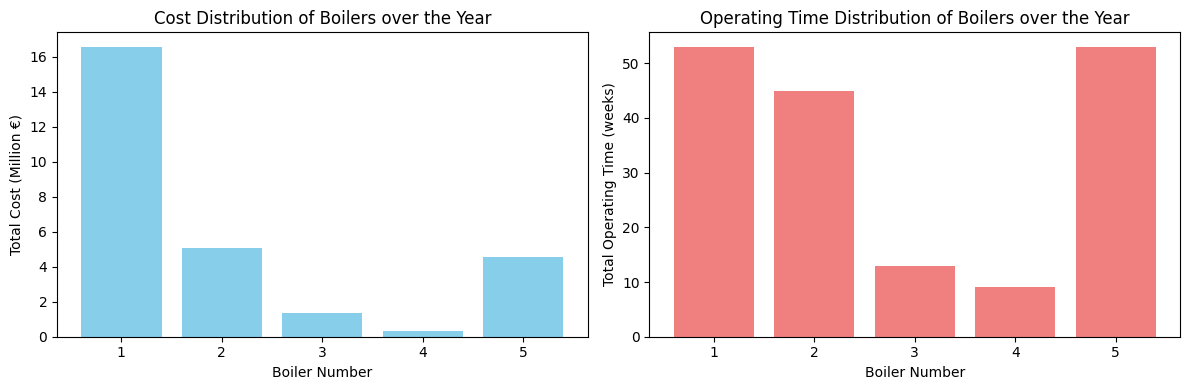

In [88]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot cost distribution on the first subplot
axes[0].bar(range(1, len(boiler_cost_over_year) + 1), boiler_cost_over_year, color='skyblue')
axes[0].set_xlabel("Boiler Number")
axes[0].set_ylabel("Total Cost (Million €)")
axes[0].set_title("Cost Distribution of Boilers over the Year")
axes[0].set_xticks(range(1, len(boiler_cost_over_year) + 1))

# Assuming reshaped_results_scaled contains weekly power output for each boiler
total_operating_time = (reshaped_results_scaled > 0).sum(axis=0)

# Plot operating time distribution on the second subplot
axes[1].bar(range(1, len(total_operating_time) + 1), total_operating_time, color='lightcoral')
axes[1].set_xlabel("Boiler Number")
axes[1].set_ylabel("Total Operating Time (weeks)")
axes[1].set_title("Operating Time Distribution of Boilers over the Year")
axes[1].set_xticks(range(1, len(total_operating_time) + 1))

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [89]:
# ADJUST saving_list BY EYE

# Analysis of Boiler Investment

# Given information
boiler_purchase_cost = 5  # Million €

# Data from previous analysis (assuming availability)
annual_total_cost = df_boiler_cost.loc['Annual total cost', 'Annual Cost (Million €)'] # Accessing the value directly

saving_list = [30.365815, 27.453277	, 27.450648]  # ADJUST THIS LINE with annual_total_cost of previous cases
scenario_names = ['Scenario 1 (All Gas)', 'Scenario 2 (Electric for Boiler 6)', 'Scenario 3 (Electric for Boilers 5 & 6)']  # Adjust names if needed
data = {'Scenario': scenario_names, 'Total Cost (Million €)': saving_list}
df = pd.DataFrame(data)
display(df)
print('\n')

annual_total_cost_original = saving_list[0]
annual_total_cost_electric = saving_list[2]
annual_savings = annual_total_cost_original - annual_total_cost_electric
print(f"Annual savings: {annual_savings:.2f} Million €")


# Calculate Key Metrics
# 1. Payback Time:
#    Payback Time = Boiler Purchase Cost / Annual Savings
if annual_savings != 0:
  payback_time = boiler_purchase_cost / annual_savings
  payback_time_months = payback_time * 12  # Convert to months
  print(f"Payback Time: {payback_time_months} months")
else:
  print("Annual savings are needed to calculate payback time")


# 2. Return on Investment (ROI):
#    ROI = (Annual Savings / Boiler Purchase Cost) * 100
if annual_savings != 0:
  roi = (annual_savings / boiler_purchase_cost) * 100
  print(f"Return on Investment (ROI): {roi:.2f}%")
else:
  print("Annual savings are needed to calculate ROI")


,Scenario,Total Cost (Million €)
0,Scenario 1 (All Gas),30.365815
1,Scenario 2 (Electric for Boiler 6),27.453277
2,Scenario 3 (Electric for Boilers 5 & 6),27.450648




Annual savings: 2.92 Million €
Payback Time: 20.582011253557685 months
Return on Investment (ROI): 58.30%
